In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from pickle import load
from pickle import dump
from myTools import *
import datetime

from lightgbm import LGBMClassifier

In [3]:
dfApplicationComplete = load(open('dfApplicationComplete.pkl','rb'))

In [4]:
dfApplication, dfApplicationVal = train_test_split(dfApplicationComplete, test_size=0.3, random_state=1)

In [5]:
dfApplicationDefault = load(open('dfApplicationDefault.pkl','rb'))
dfApplicationDefault = dfApplicationDefault.merge(dfApplication[['SK_ID_CURR']], left_on='SK_ID_CURR', right_on='SK_ID_CURR')

In [6]:
def imputeScaleAndEncode(df1, 
                    target='', 
                    identifier=''):
    
    df = df1.copy()
    
    if type(target) == str:
        target = [target]
    if type(identifier) == str:
        identifier = [identifier]
    
    colToExclude = target
    colToExclude.extend(identifier)
    
    for col in df.columns:
        if col not in colToExclude:
            if df[col].dtypes == 'object':
                df[col] = df[col].replace(np.nan, 'missing')
                df[col] = OrdinalEncoder().fit_transform(df[[col]])
            elif df[col].dtype in ['int64','float64']:
                df[col] = SimpleImputer(strategy='mean').fit_transform(df[[col]])
                df[col] = MinMaxScaler().fit_transform(df[[col]])  
                
    return df


In [7]:
results = []

# Evaluation sur les jeux de données par défaut et travaillés + paramètres optimisés précédemment

In [8]:
model = LGBMClassifier()

res = evaluateRocPrCurves(dfApplicationDefault, model=model, title_plot='Default data', display_plot=False, target='TARGET', identifier='SK_ID_CURR')
results.append(res)

res = evaluateRocPrCurves(dfApplication, model=model, title_plot='Worked data', display_plot=False, target='TARGET', identifier='SK_ID_CURR')
results.append(res)

model = LGBMClassifier(max_depth=4, learning_rate=0.1, num_leaves=8, min_child_samples=200, subsample_for_bin=25000, n_estimators=250, n_jobs=-1)

res = evaluateRocPrCurves(dfApplication, model=model, title_plot='Optim param 1', display_plot=False, target='TARGET', identifier='SK_ID_CURR')
results.append(res)

pd.concat(results).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

title  roc_auc_train  roc_auc_test  pr_auc_train  pr_auc_test  \
0   Default data       0.830893      0.771604      0.376599     0.259588   
1    Worked data       0.837280      0.777820      0.388404     0.267171   
2  Optim param 1       0.806599      0.781316      0.319230     0.272978   

   time_train  time_pred  nb_feat  nb_train     timestamp  
0    6.477907   2.005959      202    182349  1.615982e+09  
1    8.139615   2.282294      228    182349  1.615983e+09  
2    6.710408   2.215673      228    182349  1.615983e+09

# Suppression des features avec importance nulle

In [9]:
#https://www.kaggle.com/kylegilde/extracting-scikit-feature-names-importances
#https://towardsdatascience.com/extracting-feature-importances-from-scikit-learn-pipelines-18c79b4ae09a
#https://towardsdatascience.com/how-to-get-feature-importances-from-any-sklearn-pipeline-167a19f1214

In [7]:
model = LGBMClassifier(max_depth=4, learning_rate=0.1, num_leaves=8, min_child_samples=200, subsample_for_bin=25000, n_estimators=250, n_jobs=-1)
imp = featureImportance(imputeScaleAndEncode(dfApplication, target='TARGET', identifier='SK_ID_CURR'), target='TARGET', identifier='SK_ID_CURR', model=model)
imp[['feature','impMean']]

feature  impMean
0                                     EXT_SOURCE_1     80.0
1                                     EXT_SOURCE_3     73.0
2                                     EXT_SOURCE_2     66.0
3                                       DAYS_BIRTH     62.0
4                                       AMT_CREDIT     60.0
5                    POSCASH_CNT_INSTALMENT_FUTURE     47.0
6    INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG     42.0
7                                  AMT_GOODS_PRICE     40.0
8                                      AMT_ANNUITY     38.0
9                      PREVBURO_LAST_DAYS_DECISION     34.0
10                                   DAYS_EMPLOYED     33.0
11              POSCASH_CNT_INSTALMENT_FUTURE_LEFT     33.0
12              POSCASH_CNT_INSTALMENT_FUTURE_DONE     31.0
13                                 DAYS_ID_PUBLISH     30.0
14                             BURO_AMT_CREDIT_SUM     29.0
15                                PREV_AMT_ANNUITY     27.0
16                          BURO_AMT_CREDIT_ACTIVE     26.0
17                                     CODE_GENDER     26.0
18                     BURO_AMT_CREDIT_MAX_OVERDUE     26.0
19                               DAYS_REGISTRATION     25.0
20    INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS     24.0
21                        BURO_AMT_CREDIT_SUM_DEBT     23.0
22                       BURO_AMT_CREDIT_COMPLETED     22.0
23                            RATIO_ANNUITY_INCOME     22.0
24                              PREV_AMT_COMPLETED     22.0
25   INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_POS     21.0
26                              PREVBURO_DAYS_DIFF     21.0
27                              POSCASH_SK_DPD_DEF     20.0
28                       PREV_NAME_YIELD_GROUP_ORD     20.0
29                               ORGANIZATION_TYPE     19.0
30               CREDCARD_CNT_DRAWINGS_ATM_CURRENT     19.0
31         PREV_AMT_CREDIT_ACTIVE_REIMBURSED_INDIC     19.0
32                              NAME_FAMILY_STATUS     19.0
33                                NB_DOC_FURNISHED     18.0
34                                BURO_DAYS_CREDIT     17.0
35                          PREV_AMT_CREDIT_ACTIVE     17.0
36                           PREV_AMT_DOWN_PAYMENT     16.0
37                                 OCCUPATION_TYPE     16.0
38                          DAYS_LAST_PHONE_CHANGE     16.0
39                       BURO_AMT_CREDIT_SUM_LIMIT     15.0
40                             NAME_EDUCATION_TYPE     14.0
41    INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_NEG     13.0
42                   CREDCARD_CNT_DRAWINGS_CURRENT     13.0
43                         CREDCARD_MONTHS_BALANCE     13.0
44                     REGION_RATING_CLIENT_W_CITY     12.0
45                                NAME_INCOME_TYPE     12.0
46                     BURO_AMT_CREDIT_SUM_OVERDUE     12.0
47                         PREV_AMT_ANNUITY_ACTIVE     12.0
48                      INSTALPAYMT_AMT_INSTALMENT     12.0
49                      REGION_POPULATION_RELATIVE     12.0
50                                     OWN_CAR_AGE     11.0
51                        DEF_30_CNT_SOCIAL_CIRCLE     11.0
52                         PREV_CODE_REJECT_REASON     10.0
53                                 FLAG_DOCUMENT_3     10.0
54                                    FLAG_OWN_CAR     10.0
55                    PREV_HOUR_APPR_PROCESS_START     10.0
56                                AMT_INCOME_TOTAL      9.0
57                           PREV_SELLERPLACE_AREA      9.0
58               CREDCARD_AMT_DRAWINGS_ATM_CURRENT      9.0
59                            CREDCARD_AMT_BALANCE      9.0
60                  PREV_NFLAG_INSURED_ON_APPROVAL      8.0
61                         BURO_DAYS_CREDIT_UPDATE      8.0
62                         INSTALPAYMT_AMT_PAYMENT      8.0
63              CREDCARD_AMT_PAYMENT_TOTAL_CURRENT      8.0
64                              PREV_DAYS_DECISION      8.0
65                                 PREV_NB_REFUSED      8.0
66                     

In [14]:
cols = ['SK_ID_CURR','TARGET']
cols.extend(list(imp[imp.impMean > 0].feature))
cols

['SK_ID_CURR',
 'TARGET',
 'EXT_SOURCE_1',
 'EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'DAYS_BIRTH',
 'AMT_CREDIT',
 'POSCASH_CNT_INSTALMENT_FUTURE',
 'INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG',
 'AMT_GOODS_PRICE',
 'AMT_ANNUITY',
 'PREVBURO_LAST_DAYS_DECISION',
 'DAYS_EMPLOYED',
 'POSCASH_CNT_INSTALMENT_FUTURE_LEFT',
 'POSCASH_CNT_INSTALMENT_FUTURE_DONE',
 'DAYS_ID_PUBLISH',
 'BURO_AMT_CREDIT_SUM',
 'PREV_AMT_ANNUITY',
 'BURO_AMT_CREDIT_ACTIVE',
 'CODE_GENDER',
 'BURO_AMT_CREDIT_MAX_OVERDUE',
 'DAYS_REGISTRATION',
 'INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS',
 'BURO_AMT_CREDIT_SUM_DEBT',
 'BURO_AMT_CREDIT_COMPLETED',
 'RATIO_ANNUITY_INCOME',
 'PREV_AMT_COMPLETED',
 'INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_POS',
 'PREVBURO_DAYS_DIFF',
 'POSCASH_SK_DPD_DEF',
 'PREV_NAME_YIELD_GROUP_ORD',
 'ORGANIZATION_TYPE',
 'CREDCARD_CNT_DRAWINGS_ATM_CURRENT',
 'PREV_AMT_CREDIT_ACTIVE_REIMBURSED_INDIC',
 'NAME_FAMILY_STATUS',
 'NB_DOC_FURNISHED',
 'BURO_DAYS_CREDIT',
 'PREV_AMT_CREDIT_ACTIVE',
 'PRE

In [8]:
for index, row in imp.iterrows():
    if row.impMean == 0:
        del dfApplication[row.feature]

In [15]:
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='Data importance > 0', display_plot=False, target='TARGET', identifier='SK_ID_CURR')

results.append(res)
pd.concat(results).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

title  roc_auc_train  roc_auc_test  pr_auc_train  \
0         Default data       0.830893      0.771604      0.376599   
1          Worked data       0.837280      0.777820      0.388404   
2        Optim param 1       0.806599      0.781316      0.319230   
3  Data importance > 0       0.806461      0.781423      0.318548   

   pr_auc_test  time_train  time_pred  nb_feat  nb_train     timestamp  
0     0.259588    6.477907   2.005959      202    182349  1.615982e+09  
1     0.267171    8.139615   2.282294      228    182349  1.615983e+09  
2     0.272978    6.710408   2.215673      228    182349  1.615983e+09  
3     0.273607    4.840883   1.522613      152    182349  1.615983e+09

# Optimisation des paramètres

In [ ]:
results_tmp = []
lst = [2, 3, 4, 5, 6, 7, 8, 9, 10]
for param_value in lst:
    model = LGBMClassifier(max_depth=param_value, learning_rate=0.1, num_leaves=8, min_child_samples=200, subsample_for_bin=25000, n_estimators=250, n_jobs=-1)
    title = 'LGBMClassifier | max_depth = ' + str(param_value)
    res = evaluate(dfApplication, model=model, title=title)
    results_tmp.append(res)
    
displayPlotParamOptim(results_tmp)

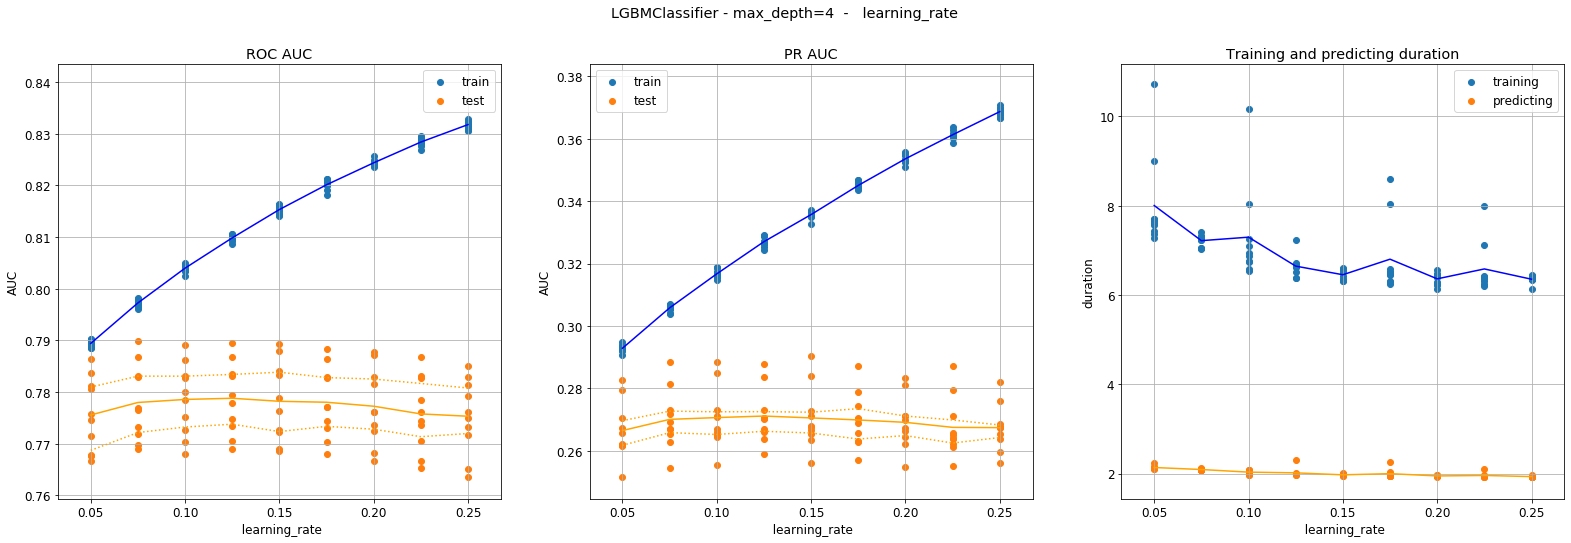

In [62]:
results_tmp = []
lst = [0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25]
for param_value in lst:
    print(param_value)
    model = LGBMClassifier(max_depth=7, learning_rate=param_value, num_leaves=8, min_child_samples=200, subsample_for_bin=25000, n_estimators=250, n_jobs=-1)
    title = 'LGBMClassifier |  learning_rate = ' + str(param_value)
    res = evaluate(dfApplication, model=model, title=title)
    results_tmp.append(res)
    
displayPlotParamOptim(results_tmp)

results.extend(results_tmp)

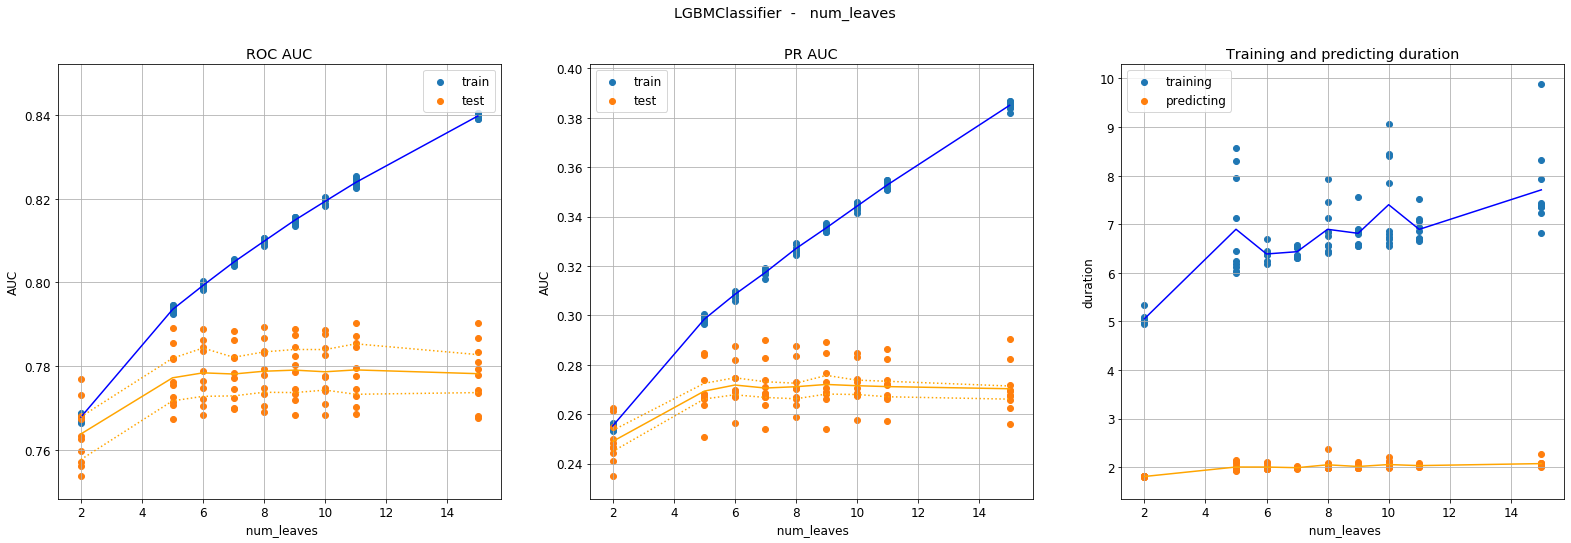

In [66]:
results_tmp = []
lst = [2, 5, 6, 7, 8, 9, 10, 11, 15]
for param_value in lst:
    print(param_value)
    model = LGBMClassifier(max_depth=7, learning_rate=0.125, num_leaves=param_value, min_child_samples=200, subsample_for_bin=25000, n_estimators=250, n_jobs=-1)
    title = 'LGBMClassifier |  num_leaves = ' + str(param_value)
    res = evaluate(dfApplication, model=model, title=title)
    results_tmp.append(res)
    
displayPlotParamOptim(results_tmp)


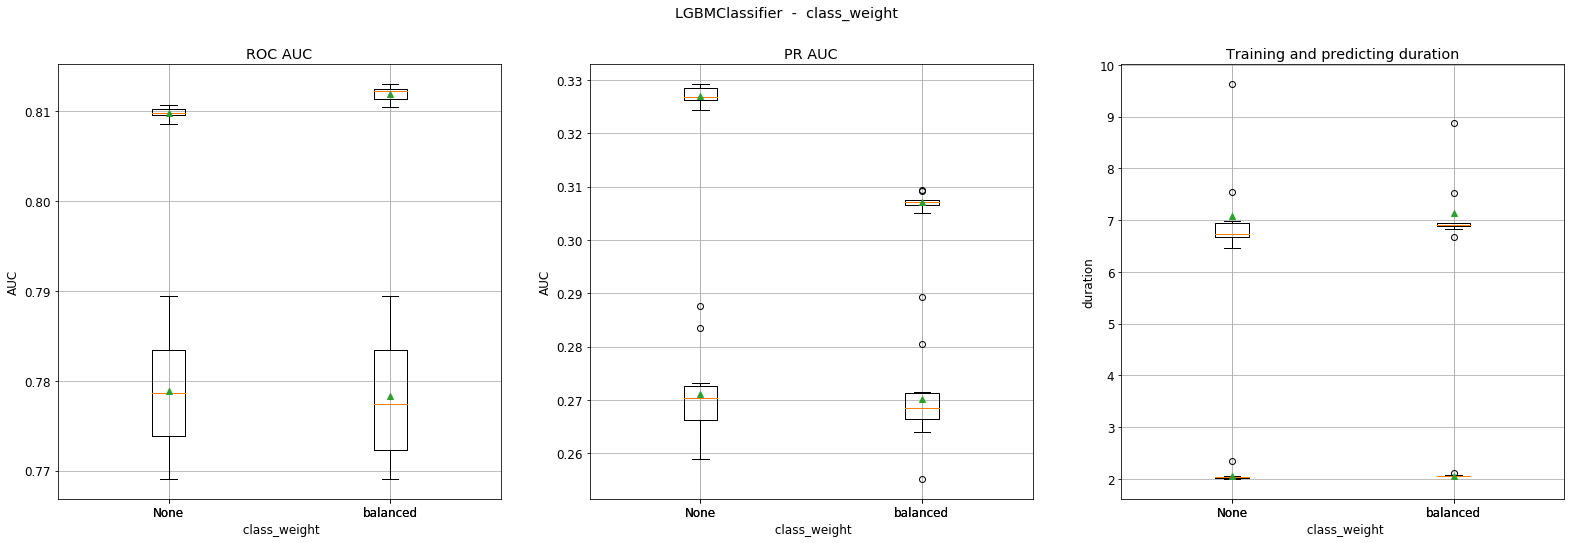

In [69]:
results_tmp = []

model = LGBMClassifier(max_depth=7, learning_rate=0.125, num_leaves=8, class_weight=None, min_child_samples=200, subsample_for_bin=25000, n_estimators=250, n_jobs=-1)
title = 'LGBMClassifier | class_weight=None'
res = evaluate(dfApplication, model=model, title=title)
results_tmp.append(res)

model = LGBMClassifier(max_depth=7, learning_rate=0.125, num_leaves=8, class_weight='balanced', min_child_samples=200, subsample_for_bin=25000, n_estimators=250, n_jobs=-1)
title = 'LGBMClassifier | class_weight=balanced'
res = evaluate(dfApplication, model=model, title=title)
results_tmp.append(res)

displayPlotParamOptimBox(results_tmp)

In [ ]:
results_tmp = []
lst = [10, 50, 100, 150, 200, 250, 300, 500]
for param_value in lst:
    print(param_value)
    model = LGBMClassifier(max_depth=7, learning_rate=0.125, num_leaves=8, min_child_samples=param_value, subsample_for_bin=25000, n_estimators=250, n_jobs=-1)
    title = 'LGBMClassifier |  num_leaves = ' + str(param_value)
    res = evaluate(dfApplication, model=model, title=title)
    results_tmp.append(res)
    
displayPlotParamOptim(results_tmp)


50
500
5000
10000
25000
50000


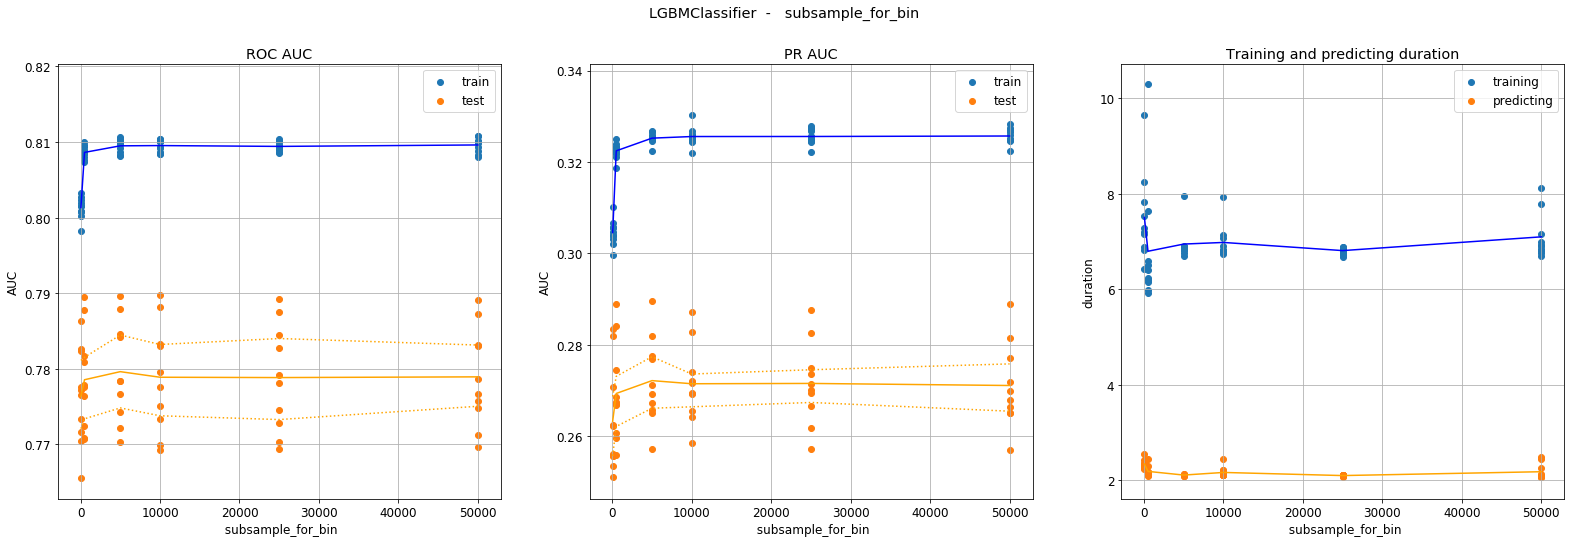

In [89]:
results_tmp = []
lst = [50, 500, 5000, 10000, 25000, 50000]
for param_value in lst:
    print(param_value)
    model = LGBMClassifier(max_depth=7, learning_rate=0.125, num_leaves=8, min_child_samples=300, subsample_for_bin=param_value, n_estimators=250, n_jobs=-1)
    title = 'LGBMClassifier |  subsample_for_bin = ' + str(param_value)
    res = evaluate(dfApplication, model=model, title=title)
    results_tmp.append(res)
    
displayPlotParamOptim(results_tmp)


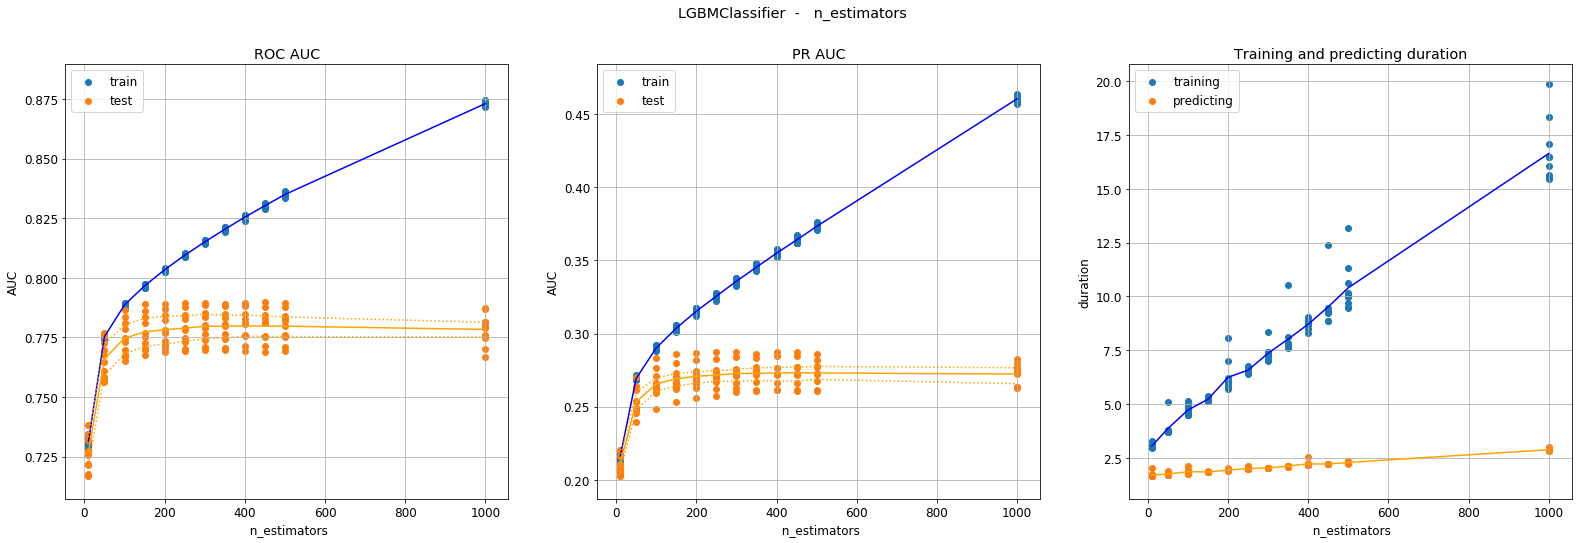

In [91]:
#results_tmp = []
lst = [10, 50, 100, 150, 200, 250, 300, 500, 1000]
lst = [350, 400, 450]
for param_value in lst:
    model = LGBMClassifier(max_depth=7, learning_rate=0.125, num_leaves=8, min_child_samples=300, subsample_for_bin=25000, n_estimators=param_value, n_jobs=-1)
    title = 'LGBMClassifier |  n_estimators = ' + str(param_value)
    res = evaluate(dfApplication, model=model, title=title)
    results_tmp.append(res)
    
displayPlotParamOptim(results_tmp)

In [12]:
model = LGBMClassifier(max_depth=7, learning_rate=0.125, num_leaves=8, min_child_samples=300, subsample_for_bin=25000, n_estimators=300, n_jobs=-1)
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='Optim param 2', display_plot=False, target='TARGET', identifier='SK_ID_CURR')

results.append(res)
pd.concat(results).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

title  roc_auc_train  roc_auc_test  pr_auc_train  \
0         Default data       0.830893      0.771604      0.376599   
1          Worked data       0.837280      0.777820      0.388404   
2  Data importance > 0       0.806461      0.781423      0.318548   
3          Optim param       0.818923      0.782068      0.339935   

   pr_auc_test  time_train  time_pred  nb_feat  nb_train     timestamp  
0     0.259588    7.251113   2.199451      202    182349  1.615875e+09  
1     0.267171    8.089405   2.221264      228    182349  1.615875e+09  
2     0.273607    6.648398   1.974747      152    182349  1.615875e+09  
3     0.274388    7.344924   2.016068      152    182349  1.615875e+09

# Optimisation des imputers

In [14]:
model = LGBMClassifier(max_depth=7, learning_rate=0.125, num_leaves=8, min_child_samples=300, subsample_for_bin=25000, n_estimators=300, n_jobs=-1)

## Optimisation des defaultImputer

### Variables catégorielles

In [15]:
results_tmp = []

defaultCatImputer = SimpleImputer(strategy='constant', fill_value='missing')
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='defaultCatImputer = missing', display_plot=False, target='TARGET', identifier='SK_ID_CURR',defaultCatImputer=defaultCatImputer)
results_tmp.append(res)

defaultCatImputer = SimpleImputer(strategy='most_frequent')
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='defaultCatImputer = most_frequent', display_plot=False, target='TARGET', identifier='SK_ID_CURR',defaultCatImputer=defaultCatImputer)
results_tmp.append(res)

pd.concat(results_tmp).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

title  roc_auc_train  roc_auc_test  \
0        defaultCatImputer = missing       0.819078      0.781964   
1  defaultCatImputer = most_frequent       0.818923      0.782068   

   pr_auc_train  pr_auc_test  time_train  time_pred  nb_feat  nb_train  \
0      0.339811     0.273486    9.123535   2.267463      152    182349   
1      0.339935     0.274388   12.245367   2.472312      152    182349   

      timestamp  
0  1.615875e+09  
1  1.615876e+09

### Variables ordinales

In [17]:
results_tmp = []

defaultCatImputer = SimpleImputer(strategy='most_frequent')
defaultOrdImputer = SimpleImputer(strategy='most_frequent')
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='defaultOrdImputer = most_frequent', display_plot=False, target='TARGET', identifier='SK_ID_CURR',defaultCatImputer=defaultCatImputer,defaultOrdImputer=defaultOrdImputer)
results_tmp.append(res)

defaultCatImputer = SimpleImputer(strategy='most_frequent')
defaultOrdImputer = SimpleImputer(strategy='mean')
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='defaultOrdImputer = mean', display_plot=False, target='TARGET', identifier='SK_ID_CURR',defaultCatImputer=defaultCatImputer,defaultOrdImputer=defaultOrdImputer)
results_tmp.append(res)

defaultCatImputer = SimpleImputer(strategy='most_frequent')
defaultOrdImputer = SimpleImputer(strategy='constant', fill_value=-1)
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='defaultOrdImputer = -1', display_plot=False, target='TARGET', identifier='SK_ID_CURR',defaultCatImputer=defaultCatImputer,defaultOrdImputer=defaultOrdImputer)
results_tmp.append(res)

defaultCatImputer = SimpleImputer(strategy='most_frequent')
defaultOrdImputer = IterativeImputer()
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='defaultOrdImputer = iterative', display_plot=False, target='TARGET', identifier='SK_ID_CURR',defaultCatImputer=defaultCatImputer,defaultOrdImputer=defaultOrdImputer)
results_tmp.append(res)

pd.concat(results_tmp).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

/home/pierre/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
/home/pierre/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
/home/pierre/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
/home/pierre/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
/home/pierre/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:685: Con

title  roc_auc_train  roc_auc_test  \
0  defaultOrdImputer = most_frequent       0.818923      0.782068   
1           defaultOrdImputer = mean       0.818925      0.781747   
2             defaultOrdImputer = -1       0.818928      0.781943   
3      defaultOrdImputer = iterative       0.819297      0.781982   

   pr_auc_train  pr_auc_test  time_train  time_pred  nb_feat  nb_train  \
0      0.339935     0.274388    6.903162   1.650537      152    182349   
1      0.339512     0.273386    5.478532   1.529181      152    182349   
2      0.340153     0.274198    5.106351   1.478007      152    182349   
3      0.340110     0.273268   28.361580   2.119281      152    182349   

      timestamp  
0  1.615877e+09  
1  1.615877e+09  
2  1.615877e+09  
3  1.615878e+09

### Variables continues

In [19]:
results_tmp = []

defaultCatImputer = SimpleImputer(strategy='most_frequent')
defaultOrdImputer = SimpleImputer(strategy='most_frequent')
defaultNumImputer = SimpleImputer(strategy='constant', fill_value=-1)
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='defaultNumImputer = -1', display_plot=False, target='TARGET', identifier='SK_ID_CURR',defaultCatImputer=defaultCatImputer,defaultOrdImputer=defaultOrdImputer,defaultNumImputer=defaultNumImputer)
results_tmp.append(res)

defaultCatImputer = SimpleImputer(strategy='most_frequent')
defaultOrdImputer = SimpleImputer(strategy='most_frequent')
defaultNumImputer = SimpleImputer(strategy='mean')
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='defaultNumImputer = mean', display_plot=False, target='TARGET', identifier='SK_ID_CURR',defaultCatImputer=defaultCatImputer,defaultOrdImputer=defaultOrdImputer,defaultNumImputer=defaultNumImputer)
results_tmp.append(res)

defaultCatImputer = SimpleImputer(strategy='most_frequent')
defaultOrdImputer = SimpleImputer(strategy='most_frequent')
defaultNumImputer = IterativeImputer()
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='defaultNumImputer = iterative', display_plot=False, target='TARGET', identifier='SK_ID_CURR',defaultCatImputer=defaultCatImputer,defaultOrdImputer=defaultOrdImputer,defaultNumImputer=defaultNumImputer)
results_tmp.append(res)

pd.concat(results_tmp).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

title  roc_auc_train  roc_auc_test  pr_auc_train  \
0         defaultNumImputer = -1       0.819152      0.782014      0.337689   
1       defaultNumImputer = mean       0.818923      0.782068      0.339935   
2  defaultNumImputer = iterative       0.820317      0.781649      0.342077   

   pr_auc_test  time_train  time_pred  nb_feat  nb_train     timestamp  
0     0.272978    4.843501   1.467187      152    182349  1.615880e+09  
1     0.274388    4.978461   1.470621      152    182349  1.615880e+09  
2     0.272827   77.412449   3.513810      152    182349  1.615881e+09

## Imputer spécifiques

### Variables appartement: missing imputer

In [44]:
results_tmp = []

In [45]:
model = LGBMClassifier(max_depth=7, learning_rate=0.125, num_leaves=8, min_child_samples=300, subsample_for_bin=25000, n_estimators=300, n_jobs=-1)
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='Initial', display_plot=False, target='TARGET', identifier='SK_ID_CURR')
results_tmp.append(res)

In [46]:
meanImputer,iterativeImputer, mostFrequentImputer, constantImputer, power, quantile, kbins10, kbins50,kbins100,minmax,standard,robust,noScale,ordinal,onehot = [],[],[],{},[],[],[],[],[],[],[],[],[],[],[]

for col in dfApplication.columns:
    if (col.find('MEDI')>0) | (col.find('AVG')>0) | (col.find('MODE')>0):
        if dfApplication[col].dtypes == 'object':
            constantImputer[col] = 'missing'
        else:
            constantImputer[col] = -1

res = evaluateRocPrCurves(dfApplication, model=model, title_plot='missing imputer sur variables appartement', display_plot=False, target='TARGET', identifier='SK_ID_CURR', constantImputer=constantImputer)
results_tmp.append(res)

In [47]:
pd.concat(results_tmp).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

title  roc_auc_train  roc_auc_test  \
0                                    Initial       0.818923      0.782068   
1  missing imputer sur variables appartement       0.818850      0.781911   

   pr_auc_train  pr_auc_test  time_train  time_pred  nb_feat  nb_train  \
0      0.339935     0.274388    5.194140   1.462293      152    182349   
1      0.339528     0.274013    4.976021   1.448672      152    182349   

      timestamp  
0  1.615886e+09  
1  1.615886e+09

### Variables catégorielles: constant imputer

In [48]:
for col in dfApplication.columns:
    if not ((col.find('MEDI')>0) | (col.find('AVG')>0) | (col.find('MODE')>0)):
        if (dfApplication[col].dtypes == 'object') & (dfApplication[dfApplication[col].isnull()].shape[0] > 2000):
            constantImputer = {}
            constantImputer[col] = 'missing'
            res = evaluateRocPrCurves(dfApplication, model=model, title_plot='missing imputer sur ' + col, display_plot=False, target='TARGET', identifier='SK_ID_CURR', constantImputer=constantImputer)
            results_tmp.append(res)

### Variables ordinales: constant imputer

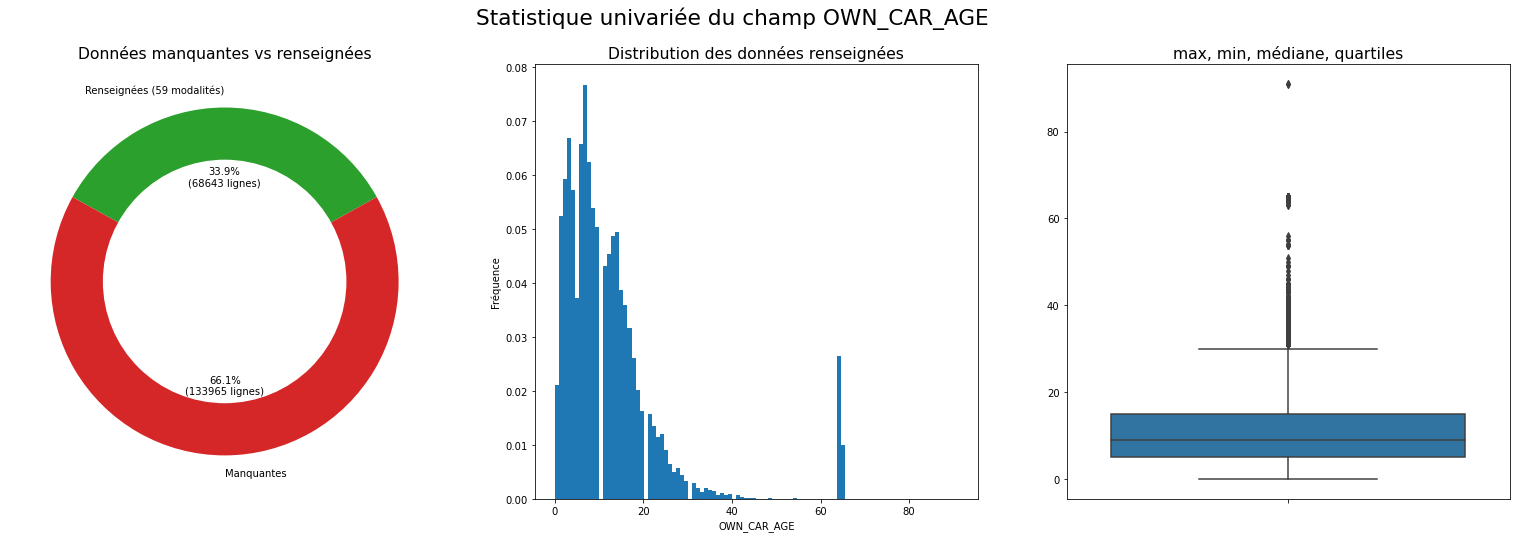

Mesures de position
 - Moyenne: 12.26
 - Médiane: 9.0
Mesures de dispertion
 - Ecart type: 12.08
 - Min: 0.0
 - Q25: 5.0
 - Q75: 15.0
 - Max: 91.0
Mesures de forme
 - Skewness (asymétrie): 2.72
 - Kurtosis (applatissement): 8.98


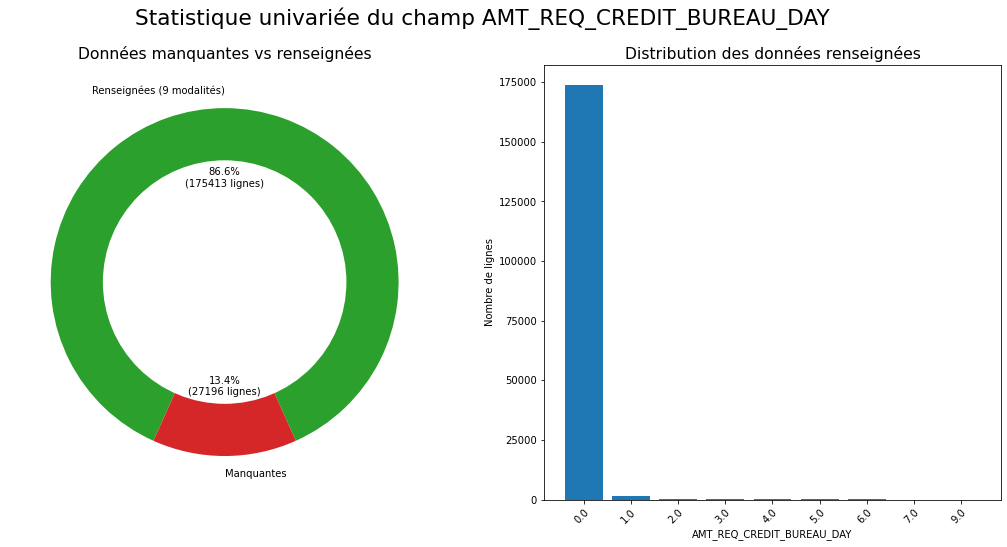

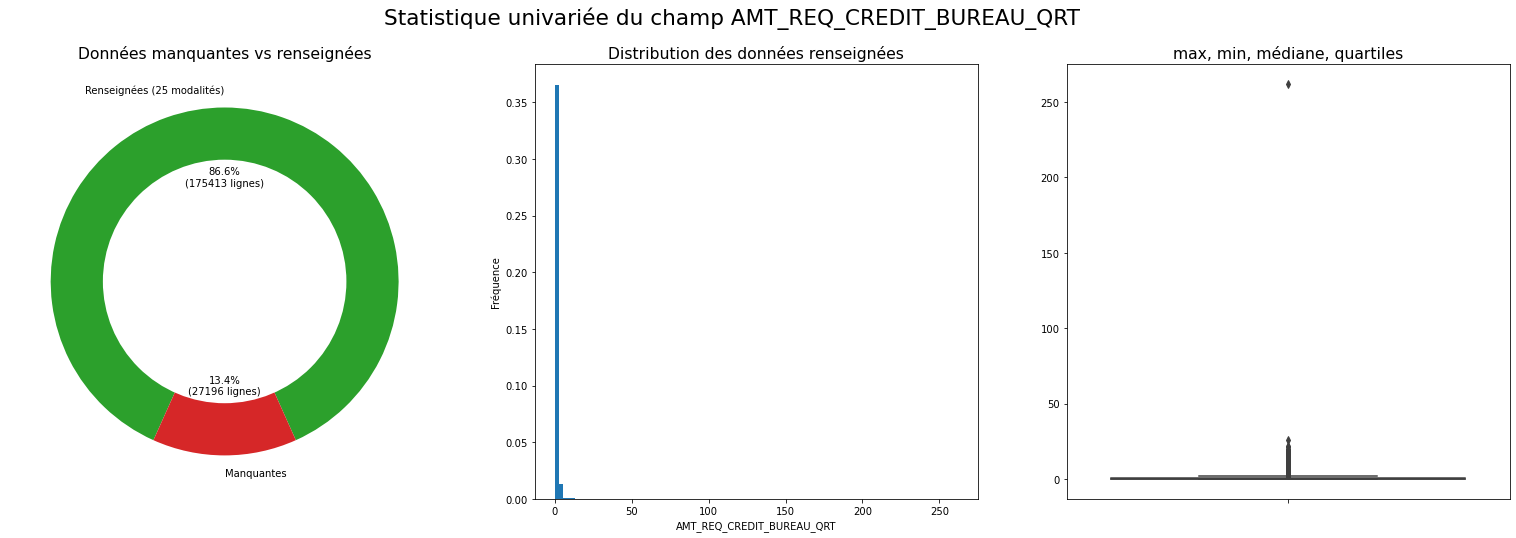

Mesures de position
 - Moyenne: 0.59
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 1.28
 - Min: 0.0
 - Q25: 0.0
 - Q75: 1.0
 - Max: 262.0
Mesures de forme
 - Skewness (asymétrie): 51.32
 - Kurtosis (applatissement): 9832.72


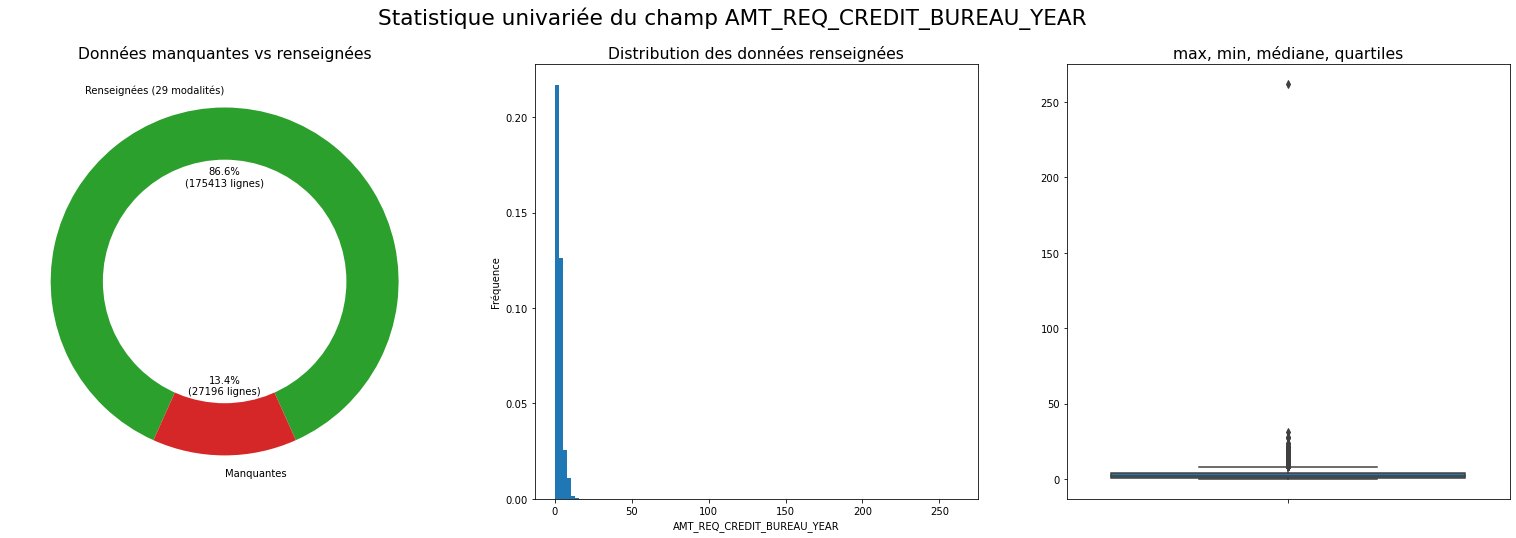

Mesures de position
 - Moyenne: 2.59
 - Médiane: 2.0
Mesures de dispertion
 - Ecart type: 2.31
 - Min: 0.0
 - Q25: 1.0
 - Q75: 4.0
 - Max: 262.0
Mesures de forme
 - Skewness (asymétrie): 9.31
 - Kurtosis (applatissement): 912.61


In [49]:
for col in dfApplication.columns:
    if not ((col.find('MEDI')>0) | (col.find('AVG')>0) | (col.find('MODE')>0)):
        if (dfApplication[col].dtypes != 'object') & (dfApplication[col].nunique() < 100) & (dfApplication[dfApplication[col].isnull()].shape[0] > 2000):
            myDf(dfApplication).Stat(col, statsNan=True)

In [50]:
constantImputer = {}
constantImputer['OWN_CAR_AGE'] = 100
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='constant imputer 100 sur OWN_CAR_AGE' + col, display_plot=False, target='TARGET', identifier='SK_ID_CURR', constantImputer=constantImputer)
results_tmp.append(res)

constantImputer = {}
constantImputer['OWN_CAR_AGE'] = -1
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='constant imputer -1 sur OWN_CAR_AGE' + col, display_plot=False, target='TARGET', identifier='SK_ID_CURR', constantImputer=constantImputer)
results_tmp.append(res)

constantImputer = {}
constantImputer['OWN_CAR_AGE'] = -10
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='constant imputer -10 sur OWN_CAR_AGE' + col, display_plot=False, target='TARGET', identifier='SK_ID_CURR', constantImputer=constantImputer)
results_tmp.append(res)

### Variables continues: constant ou iterative imputer

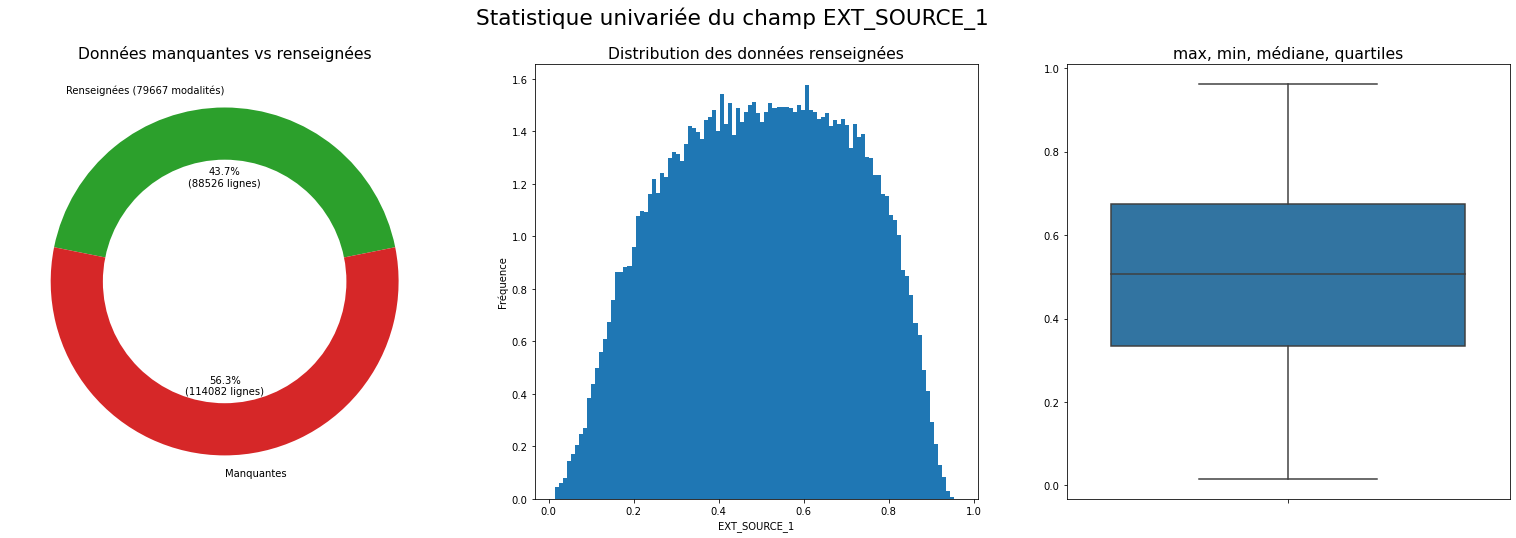

Mesures de position
 - Moyenne: 0.5
 - Médiane: 0.51
Mesures de dispertion
 - Ecart type: 0.21
 - Min: 0.02
 - Q25: 0.33
 - Q75: 0.67
 - Max: 0.96
Mesures de forme
 - Skewness (asymétrie): -0.07
 - Kurtosis (applatissement): -0.97


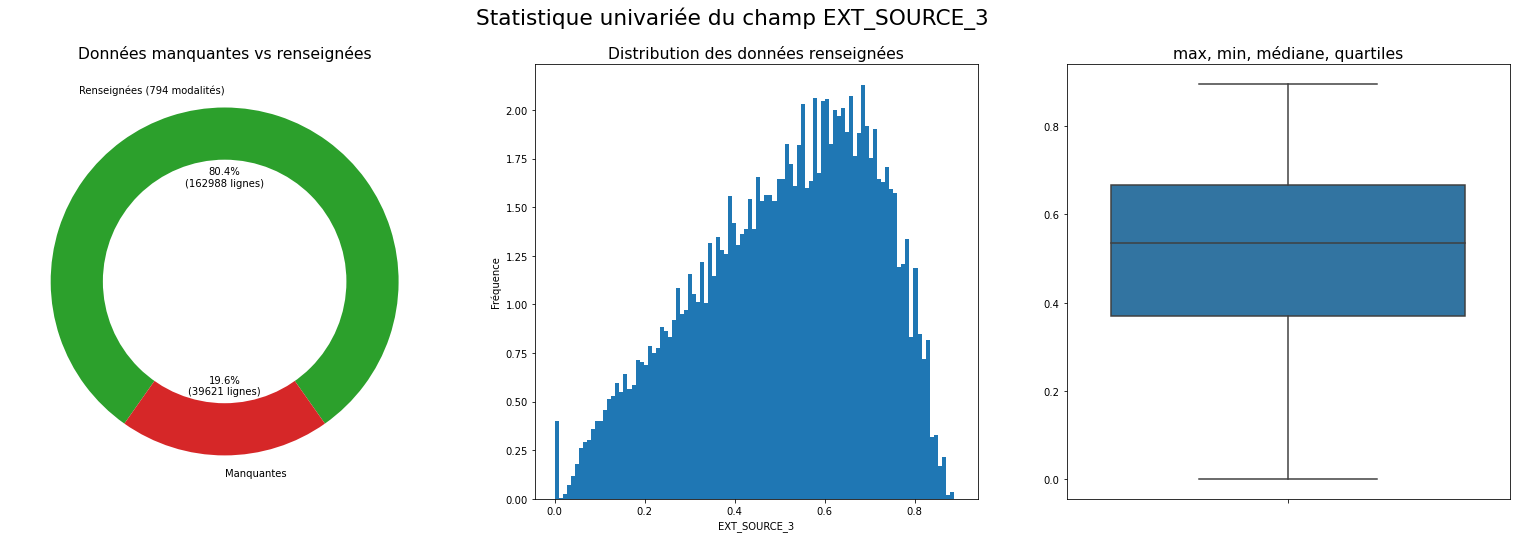

Mesures de position
 - Moyenne: 0.51
 - Médiane: 0.54
Mesures de dispertion
 - Ecart type: 0.19
 - Min: 0.0
 - Q25: 0.37
 - Q75: 0.67
 - Max: 0.9
Mesures de forme
 - Skewness (asymétrie): -0.41
 - Kurtosis (applatissement): -0.66


In [51]:
for col in dfApplication.columns:
    if not ((col.find('MEDI')>0) | (col.find('AVG')>0) | (col.find('MODE')>0)):
        if (dfApplication[col].dtypes != 'object') & (dfApplication[col].nunique() >= 100) & (dfApplication[dfApplication[col].isnull()].shape[0] > 2000):
            myDf(dfApplication).Stat(col, statsNan=True)

In [52]:
constantImputer = {}
constantImputer['EXT_SOURCE_1'] = 0
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='constant imputer 0 sur EXT_SOURCE_1' + col, display_plot=False, target='TARGET', identifier='SK_ID_CURR', constantImputer=constantImputer)
results_tmp.append(res)

constantImputer = {}
constantImputer['EXT_SOURCE_1'] = -1
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='constant imputer -1 sur EXT_SOURCE_1' + col, display_plot=False, target='TARGET', identifier='SK_ID_CURR', constantImputer=constantImputer)
results_tmp.append(res)

iterativeImputer = ['EXT_SOURCE_1']
constantImputer = {}
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='iterative imputer sur EXT_SOURCE_1' + col, display_plot=False, target='TARGET', identifier='SK_ID_CURR', constantImputer=constantImputer)
results_tmp.append(res)


constantImputer = {}
constantImputer['EXT_SOURCE_3'] = 0
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='constant imputer 0 sur EXT_SOURCE_3' + col, display_plot=False, target='TARGET', identifier='SK_ID_CURR', constantImputer=constantImputer)
results_tmp.append(res)

constantImputer = {}
constantImputer['EXT_SOURCE_3'] = 1
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='constant imputer 1 sur EXT_SOURCE_3' + col, display_plot=False, target='TARGET', identifier='SK_ID_CURR', constantImputer=constantImputer)
results_tmp.append(res)

iterativeImputer = ['EXT_SOURCE_3']
constantImputer = {}
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='iterative imputer sur EXT_SOURCE_3' + col, display_plot=False, target='TARGET', identifier='SK_ID_CURR', constantImputer=constantImputer)
results_tmp.append(res)



### Bilan

In [54]:
results_tmp_svg = results_tmp.copy()

In [55]:
results_tmp= pd.concat(results_tmp).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)
results_tmp = results_tmp[['title','roc_auc_train','roc_auc_test','pr_auc_train','pr_auc_test']]
roc_auc_test_ini = results_tmp[results_tmp.title == 'Initial'].roc_auc_test.values[0]
pr_auc_test_ini = results_tmp[results_tmp.title == 'Initial'].pr_auc_test.values[0]
results_tmp['gain_roc'] = results_tmp.apply(lambda x: 1000 * (x.roc_auc_test - roc_auc_test_ini), axis=1)
results_tmp['gain_pr'] = results_tmp.apply(lambda x: 1000 * (x.pr_auc_test - pr_auc_test_ini), axis=1)
results_tmp['gain'] = results_tmp.apply(lambda x: 1000 * (x.roc_auc_test - roc_auc_test_ini + x.pr_auc_test - pr_auc_test_ini), axis=1)
results_tmp

title  roc_auc_train  \
0                                                      Initial       0.818923   
1                    missing imputer sur variables appartement       0.818850   
2                          missing imputer sur OCCUPATION_TYPE       0.818977   
3                        missing imputer sur ORGANIZATION_TYPE       0.818832   
4                     missing imputer sur PREV_NAME_TYPE_SUITE       0.818951   
5                 missing imputer sur PREV_NAME_GOODS_CATEGORY       0.818854   
6                missing imputer sur PREV_NAME_SELLER_INDUSTRY       0.818900   
7                       missing imputer sur BURO_CREDIT_ACTIVE       0.818904   
8                         missing imputer sur BURO_CREDIT_TYPE       0.818914   
9              missing imputer sur PREV_NAME_CASH_LOAN_PURPOSE       0.818943   
10  constant imputer 100 sur OWN_CAR_AGEBUROBAL_MONTHS_BALANCE       0.819166   
11   constant imputer -1 sur OWN_CAR_AGEBUROBAL_MONTHS_BALANCE       0.818866   
12  constant imputer -10 sur OWN_CAR_AGEBUROBAL_MONTHS_BALANCE       0.818866   
13   constant imputer 0 sur EXT_SOURCE_1BUROBAL_MONTHS_BALANCE       0.819060   
14  constant imputer -1 sur EXT_SOURCE_1BUROBAL_MONTHS_BALANCE       0.819060   
15    iterative imputer sur EXT_SOURCE_1BUROBAL_MONTHS_BALANCE       0.818923   
16   constant imputer 0 sur EXT_SOURCE_3BUROBAL_MONTHS_BALANCE       0.819122   
17   constant imputer 1 sur EXT_SOURCE_3BUROBAL_MONTHS_BALANCE       0.818807   
18    iterative imputer sur EXT_SOURCE_3BUROBAL_MONTHS_BALANCE       0.818923   

    roc_auc_test  pr_auc_train  pr_auc_test  gain_roc   gain_pr      gain  
0       0.782068      0.339935     0.274388  0.000000  0.000000  0.000000  
1       0.781911      0.339528     0.274013 -0.157596 -0.375233 -0.532829  
2       0.781841      0.339911     0.274107 -0.226934 -0.281493 -0.508426  
3       0.781563      0.339361     0.273984 -0.505009 -0.404400 -0.909409  
4       0.782036      0.339839     0.274393 -0.031900  0.004378 -0.027522  
5       0.782071      0.339808     0.274071  0.002847 -0.317302 -0.314455  
6       0.781869      0.339746     0.274204 -0.198907 -0.184819 -0.383726  
7       0.781810      0.339779     0.273698 -0.258526 -0.690596 -0.949121  
8       0.782118      0.339587     0.274336  0.049499 -0.052409 -0.002910  
9       0.781862      0.339355     0.274705 -0.206745  0.316370  0.109625  
10      0.782120      0.339583     0.273339  0.051824 -1.049087 -0.997263  
11      0.782040      0.339670     0.274225 -0.028214 -0.163734 -0.191948  
12      0.782040      0.339670     0.274225 -0.028214 -0.163734 -0.191948  
13      0.781909      0.338853     0.274277 -0.159504 -0.111553 -0.271057  
14      0.781909      0.338853     0.274277 -0.159504 -0.111553 -0.271057  
15      0.782068      0.339935     0.274388  0.000000  0.000000  0.000000  
16      0.782068      0.338934     0.274291 -0.000367 -0.096924 -0.097291  
17      0.781663      0.340450     0.272171 -0.405590 -2.217565 -2.623154  
18      0.782068      0.339935     0.274388  0.000000  0.000000  0.000000

## Essai de kBinsTransformers

In [70]:
results_tmp = []

In [71]:
model = LGBMClassifier(max_depth=7, learning_rate=0.125, num_leaves=8, min_child_samples=300, subsample_for_bin=25000, n_estimators=300, n_jobs=-1)
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='Initial', display_plot=False, target='TARGET', identifier='SK_ID_CURR')
results_tmp.append(res)

In [ ]:
cols = list(dfApplication.columns)
cols.remove('TARGET')
cols.remove('SK_ID_CURR')
for col in cols:
    if (dfApplication[col].dtypes != 'object') & (dfApplication[col].nunique() >= 1000):
        kbins50=[col]
        res = evaluateRocPrCurves(dfApplication, model=model, title_plot='kbins sur '+ col, display_plot=False, target='TARGET', identifier='SK_ID_CURR',kbins50=kbins50)
        results_tmp.append(res)

In [ ]:
results_tmp= pd.concat(results_tmp).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)
results_tmp = results_tmp[['title','roc_auc_train','roc_auc_test','pr_auc_train','pr_auc_test']]
roc_auc_test_ini = results_tmp[results_tmp.title == 'Initial'].roc_auc_test.values[0]
pr_auc_test_ini = results_tmp[results_tmp.title == 'Initial'].pr_auc_test.values[0]
results_tmp['gain_roc'] = results_tmp.apply(lambda x: 1000 * (x.roc_auc_test - roc_auc_test_ini), axis=1)
results_tmp['gain_pr'] = results_tmp.apply(lambda x: 1000 * (x.pr_auc_test - pr_auc_test_ini), axis=1)
results_tmp['gain'] = results_tmp.apply(lambda x: 1000 * (x.roc_auc_test - roc_auc_test_ini + x.pr_auc_test - pr_auc_test_ini), axis=1)
results_tmp = results_tmp[results_tmp.title != 'Initial']
results_kbins = results_tmp

In [89]:
results_kbins[results_kbins.gain>0].sort_values('gain', ascending=False)

title  roc_auc_train  \
28       kbins sur PREV_AMT_CREDIT_ACTIVE_REIMBURSED_INDIC       0.818925   
10                                kbins sur APARTMENTS_AVG       0.818870   
17                                 kbins sur LANDAREA_MODE       0.818800   
45                          kbins sur PREV_AMT_GOODS_PRICE       0.818839   
84                       kbins sur INSTALPAYMT_AMT_PAYMENT       0.818913   
74             kbins sur CREDCARD_CNT_DRAWINGS_ATM_CURRENT       0.819066   
52                         kbins sur PREV_DAYS_TERMINATION       0.818811   
1                               kbins sur AMT_INCOME_TOTAL       0.818817   
75                 kbins sur CREDCARD_CNT_DRAWINGS_CURRENT       0.818966   
35  kbins sur INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS       0.818891   
19                            kbins sur NONLIVINGAREA_MODE       0.818766   
82                kbins sur INSTALPAYMT_DAYS_ENTRY_PAYMENT       0.818850   
78                        kbins sur POSCASH_MONTHS_BALANCE       0.818717   
71             kbins sur CREDCARD_AMT_RECEIVABLE_PRINCIPAL       0.818831   
83                    kbins sur INSTALPAYMT_AMT_INSTALMENT       0.818759   
66                 kbins sur CREDCARD_AMT_DRAWINGS_CURRENT       0.818748   
51                            kbins sur PREV_DAYS_LAST_DUE       0.818788   
12                                kbins sur COMMONAREA_AVG       0.818852   
14                                kbins sur LIVINGAREA_AVG       0.818703   
76             kbins sur CREDCARD_CNT_DRAWINGS_POS_CURRENT       0.818884   
42                          kbins sur PREV_AMT_APPLICATION       0.818655   

    roc_auc_test  pr_auc_train  pr_auc_test  gain_roc   gain_pr      gain  
28      0.782423      0.339634     0.274946  0.354982  0.557286  0.912268  
10      0.782507      0.339569     0.274767  0.438671  0.378449  0.817119  
17      0.782471      0.339546     0.274649  0.402450  0.261083  0.663533  
45      0.782101      0.339538     0.274910  0.032661  0.521802  0.554463  
84      0.782342      0.339953     0.274635  0.273806  0.247103  0.520909  
74      0.782262      0.340259     0.274672  0.194055  0.283663  0.477717  
52      0.782035      0.339463     0.274855 -0.032907  0.466601  0.433694  
1       0.782390      0.339174     0.274491  0.321364  0.103083  0.424447  
75      0.782302      0.339668     0.274503  0.233518  0.115013  0.348531  
35      0.782091      0.339877     0.274678  0.022260  0.289762  0.312022  
19      0.782107      0.339586     0.274642  0.038907  0.253510  0.292417  
82      0.782243      0.339865     0.274486  0.174611  0.098029  0.272640  
78      0.782263      0.339578     0.274430  0.194555  0.042067  0.236623  
71      0.782318      0.339913     0.274329  0.250147 -0.059335  0.190812  
83      0.782203      0.339601     0.274402  0.134465  0.013964  0.148429  
66      0.782225      0.339971     0.274331  0.156576 -0.057436  0.099140  
51      0.782220      0.339493     0.274328  0.152093 -0.060011  0.092082  
12      0.782283      0.339303     0.274249  0.214412 -0.139771  0.074640  
14      0.782257      0.339959     0.274264  0.188992 -0.124588  0.064404  
76      0.781879      0.339761     0.274641 -0.189004  0.252437  0.063433  
42      0.782006      0.339940     0.274484 -0.062681  0.095568  0.032888

In [101]:
results_tmp = []

In [102]:
model = LGBMClassifier(max_depth=7, learning_rate=0.125, num_leaves=8, min_child_samples=300, subsample_for_bin=25000, n_estimators=300, n_jobs=-1)
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='Initial', display_plot=False, target='TARGET', identifier='SK_ID_CURR')
results_tmp.append(res)

In [103]:
kbins50 = []
for col in results_kbins[results_kbins.gain>0].title:
    kbins50.append(col.split(' ')[2])
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='kbins', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50)
results_tmp.append(res)

In [104]:
pd.concat(results_tmp).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

title  roc_auc_train  roc_auc_test  pr_auc_train  pr_auc_test  \
0  Initial       0.818923      0.782068      0.339935     0.274388   
1    kbins       0.818379      0.782516      0.338712     0.274768   

   time_train  time_pred  nb_feat  nb_train     timestamp  
0    4.944150   1.445674      152    182349  1.615899e+09  
1    6.041529   1.633219      152    182349  1.615899e+09

In [36]:
kbins50 = ['AMT_INCOME_TOTAL',
 'APARTMENTS_AVG',
 'COMMONAREA_AVG',
 'LIVINGAREA_AVG',
 'LANDAREA_MODE',
 'NONLIVINGAREA_MODE',
 'PREV_AMT_CREDIT_ACTIVE_REIMBURSED_INDIC',
 'INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS',
 'PREV_AMT_APPLICATION',
 'PREV_AMT_GOODS_PRICE',
 'PREV_DAYS_LAST_DUE',
 'PREV_DAYS_TERMINATION',
 'CREDCARD_AMT_DRAWINGS_CURRENT',
 'CREDCARD_AMT_RECEIVABLE_PRINCIPAL',
 'CREDCARD_CNT_DRAWINGS_ATM_CURRENT',
 'CREDCARD_CNT_DRAWINGS_CURRENT',
 'CREDCARD_CNT_DRAWINGS_POS_CURRENT',
 'POSCASH_MONTHS_BALANCE',
 'INSTALPAYMT_DAYS_ENTRY_PAYMENT',
 'INSTALPAYMT_AMT_INSTALMENT',
 'INSTALPAYMT_AMT_PAYMENT']

## Scaler optimisation

In [108]:
results_tmp = []

defaultScaler = MinMaxScaler()
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='MinMax', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, defaultScaler=defaultScaler)
results_tmp.append(res)

defaultScaler = StandardScaler()
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='Standard', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, defaultScaler=defaultScaler)
results_tmp.append(res)

defaultScaler = RobustScaler()
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='Robust', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, defaultScaler=defaultScaler)
results_tmp.append(res)

pd.concat(results_tmp).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

title  roc_auc_train  roc_auc_test  pr_auc_train  pr_auc_test  \
0    MinMax       0.818379      0.782516      0.338712     0.274768   
1  Standard       0.818412      0.782615      0.338366     0.274137   
2    Robust       0.818520      0.782369      0.338820     0.274995   

   time_train  time_pred  nb_feat  nb_train     timestamp  
0    6.356329   1.726433      152    182349  1.615902e+09  
1    7.795216   1.747252      152    182349  1.615902e+09  
2    6.446701   1.622779      152    182349  1.615902e+09

In [109]:
imp = featureImportance(imputeScaleAndEncode(dfApplication, target='TARGET', identifier='SK_ID_CURR'), target='TARGET', identifier='SK_ID_CURR', model=model)
imp[['feature','impMean']]

feature  impMean
0                                     EXT_SOURCE_3     77.0
1                                     EXT_SOURCE_1     70.0
2                                     EXT_SOURCE_2     66.0
3                                       AMT_CREDIT     64.0
4                                       DAYS_BIRTH     58.0
5                    POSCASH_CNT_INSTALMENT_FUTURE     51.0
6                                    DAYS_EMPLOYED     44.0
7                                  AMT_GOODS_PRICE     40.0
8    INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG     40.0
9                      PREVBURO_LAST_DAYS_DECISION     39.0
10                                 DAYS_ID_PUBLISH     39.0
11                                     AMT_ANNUITY     38.0
12                             BURO_AMT_CREDIT_SUM     37.0
13                               DAYS_REGISTRATION     34.0
14                              PREV_AMT_COMPLETED     32.0
15              POSCASH_CNT_INSTALMENT_FUTURE_DONE     31.0
16              POSCASH_CNT_INSTALMENT_FUTURE_LEFT     31.0
17                        BURO_AMT_CREDIT_SUM_DEBT     30.0
18   INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_POS     30.0
19                          BURO_AMT_CREDIT_ACTIVE     29.0
20                                PREV_AMT_ANNUITY     28.0
21                               ORGANIZATION_TYPE     26.0
22    INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS     25.0
23                              PREVBURO_DAYS_DIFF     25.0
24                    PREV_HOUR_APPR_PROCESS_START     24.0
25                      REGION_POPULATION_RELATIVE     24.0
26                            RATIO_ANNUITY_INCOME     24.0
27                     BURO_AMT_CREDIT_MAX_OVERDUE     24.0
28                              NAME_FAMILY_STATUS     23.0
29               CREDCARD_CNT_DRAWINGS_ATM_CURRENT     23.0
30         PREV_AMT_CREDIT_ACTIVE_REIMBURSED_INDIC     22.0
31                                     CODE_GENDER     22.0
32                                 OCCUPATION_TYPE     22.0
33                       BURO_AMT_CREDIT_COMPLETED     21.0
34                           PREV_SELLERPLACE_AREA     21.0
35                           PREV_AMT_DOWN_PAYMENT     20.0
36                          PREV_AMT_CREDIT_ACTIVE     19.0
37                                BURO_DAYS_CREDIT     19.0
38                              POSCASH_SK_DPD_DEF     19.0
39                       PREV_NAME_YIELD_GROUP_ORD     18.0
40                       BURO_AMT_CREDIT_SUM_LIMIT     18.0
41                      INSTALPAYMT_AMT_INSTALMENT     17.0
42                                NB_DOC_FURNISHED     17.0
43                        BURO_DAYS_CREDIT_ENDDATE     17.0
44                                PREV_CNT_PAYMENT     16.0
45                          DAYS_LAST_PHONE_CHANGE     15.0
46                         CREDCARD_MONTHS_BALANCE     15.0
47                                AMT_INCOME_TOTAL     15.0
48                         INSTALPAYMT_AMT_PAYMENT     14.0
49    INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_NEG     14.0
50                                     OWN_CAR_AGE     13.0
51              CREDCARD_AMT_PAYMENT_TOTAL_CURRENT     13.0
52                   CREDCARD_CNT_DRAWINGS_CURRENT     13.0
53                           PREV_DAYS_TERMINATION     12.0
54                     BURO_AMT_CREDIT_SUM_OVERDUE     12.0
55                  PREV_DAYS_LAST_DUE_1ST_VERSION     12.0
56                              PREV_DAYS_LAST_DUE     12.0
57                         PREV_AMT_ANNUITY_ACTIVE     12.0
58                        DEF_30_CNT_SOCIAL_CIRCLE     12.0
59                  INSTALPAYMT_DAYS_ENTRY_PAYMENT     11.0
60                          POSCASH_MONTHS_BALANCE     11.0
61                             NAME_EDUCATION_TYPE     11.0
62                          BURO_DAYS_ENDDATE_FACT     11.0
63                         PREV_CODE_REJECT_REASON     11.0
64               CREDCARD_AMT_DRAWINGS_ATM_CURRENT     10.0
65                         BURO_DAYS_CREDIT_UPDATE     10.0
66                    C

In [122]:
results_tmp = []
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='Initial', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50)
results_tmp.append(res)

In [115]:
for index, row in imp.head(10).iterrows():
    if dfApplication[row.feature].dtypes != 'object':
        print(row.feature)
        standard, robust = [row.feature], []
        res = evaluateRocPrCurves(dfApplication, model=model, title_plot=row.feature+' standard', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, standard=standard, robust=robust)
        results_tmp.append(res)
        standard, robust = [], [row.feature]
        res = evaluateRocPrCurves(dfApplication, model=model, title_plot=row.feature+' robust', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, standard=standard, robust=robust)
        results_tmp.append(res)

EXT_SOURCE_3
EXT_SOURCE_1
EXT_SOURCE_2
AMT_CREDIT
DAYS_BIRTH
POSCASH_CNT_INSTALMENT_FUTURE
DAYS_EMPLOYED
AMT_GOODS_PRICE
INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG
PREVBURO_LAST_DAYS_DECISION


In [124]:
results_tmp_svg = results_tmp.copy()

In [125]:
results_tmp= pd.concat(results_tmp).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)
results_tmp = results_tmp[['title','roc_auc_train','roc_auc_test','pr_auc_train','pr_auc_test']]
roc_auc_test_ini = results_tmp[results_tmp.title == 'Initial'].roc_auc_test.values[0]
pr_auc_test_ini = results_tmp[results_tmp.title == 'Initial'].pr_auc_test.values[0]
results_tmp['gain_roc'] = results_tmp.apply(lambda x: 1000 * (x.roc_auc_test - roc_auc_test_ini), axis=1)
results_tmp['gain_pr'] = results_tmp.apply(lambda x: 1000 * (x.pr_auc_test - pr_auc_test_ini), axis=1)
results_tmp['gain'] = results_tmp.apply(lambda x: 1000 * (x.roc_auc_test - roc_auc_test_ini + x.pr_auc_test - pr_auc_test_ini), axis=1)


title  roc_auc_train  \
0                                    EXT_SOURCE_3 standard       0.818332   
1                                      EXT_SOURCE_3 robust       0.818332   
2                                    EXT_SOURCE_1 standard       0.818280   
3                                      EXT_SOURCE_1 robust       0.818280   
4                                    EXT_SOURCE_2 standard       0.818239   
5                                      EXT_SOURCE_2 robust       0.818239   
6                                      AMT_CREDIT standard       0.818256   
7                                        AMT_CREDIT robust       0.818256   
8                                      DAYS_BIRTH standard       0.818266   
9                                        DAYS_BIRTH robust       0.818266   
10                  POSCASH_CNT_INSTALMENT_FUTURE standard       0.818266   
11                    POSCASH_CNT_INSTALMENT_FUTURE robust       0.818266   
12                                  DAYS_EMPLOYED standard       0.818286   
13                                    DAYS_EMPLOYED robust       0.818286   
14                                AMT_GOODS_PRICE standard       0.818339   
15                                  AMT_GOODS_PRICE robust       0.818339   
16  INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG standard       0.818145   
17    INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG robust       0.818145   
18                    PREVBURO_LAST_DAYS_DECISION standard       0.818333   
19                      PREVBURO_LAST_DAYS_DECISION robust       0.818333   
20                                                 Initial       0.818379   

    roc_auc_test  pr_auc_train  pr_auc_test  gain_roc   gain_pr      gain  
0       0.781816      0.338198     0.273691 -0.699443 -1.076137 -1.775579  
1       0.781816      0.338198     0.273691 -0.699443 -1.076137 -1.775579  
2       0.782666      0.338415     0.275031  0.150832  0.263874  0.414706  
3       0.782666      0.338415     0.275031  0.150832  0.263874  0.414706  
4       0.782965      0.339153     0.273841  0.449182 -0.926528 -0.477347  
5       0.782965      0.339153     0.273841  0.449182 -0.926528 -0.477347  
6       0.781948      0.338822     0.274385 -0.568072 -0.382781 -0.950853  
7       0.781948      0.338822     0.274385 -0.568072 -0.382781 -0.950853  
8       0.783038      0.339004     0.274638  0.522252 -0.129264  0.392989  
9       0.783038      0.339004     0.274638  0.522252 -0.129264  0.392989  
10      0.782832      0.338517     0.275199  0.316162  0.431299  0.747461  
11      0.782832      0.338517     0.275199  0.316162  0.431299  0.747461  
12      0.782136      0.338645     0.273586 -0.379429 -1.181186 -1.560616  
13      0.782136      0.338645     0.273586 -0.379429 -1.181186 -1.560616  
14      0.782801      0.338536     0.274967  0.285451  0.199044  0.484495  
15      0.782801      0.338536     0.274967  0.285451  0.199044  0.484495  
16      0.782156      0.338921     0.274828 -0.359838  0.060090 -0.299748  
17      0.782156      0.338921     0.274828 -0.359838  0.060090 -0.299748  
18      0.782083      0.338441     0.274452 -0.432481 -0.315808 -0.748289  
19      0.782083      0.338441     0.274452 -0.432481 -0.315808 -0.748289  
20      0.782516      0.338712     0.274768  0.000000  0.000000  0.000000

In [126]:
results_tmp[results_tmp.gain > 0].sort_values('gain', ascending=False)

title  roc_auc_train  roc_auc_test  \
10  POSCASH_CNT_INSTALMENT_FUTURE standard       0.818266      0.782832   
11    POSCASH_CNT_INSTALMENT_FUTURE robust       0.818266      0.782832   
14                AMT_GOODS_PRICE standard       0.818339      0.782801   
15                  AMT_GOODS_PRICE robust       0.818339      0.782801   
2                    EXT_SOURCE_1 standard       0.818280      0.782666   
3                      EXT_SOURCE_1 robust       0.818280      0.782666   
8                      DAYS_BIRTH standard       0.818266      0.783038   
9                        DAYS_BIRTH robust       0.818266      0.783038   

    pr_auc_train  pr_auc_test  gain_roc   gain_pr      gain  
10      0.338517     0.275199  0.316162  0.431299  0.747461  
11      0.338517     0.275199  0.316162  0.431299  0.747461  
14      0.338536     0.274967  0.285451  0.199044  0.484495  
15      0.338536     0.274967  0.285451  0.199044  0.484495  
2       0.338415     0.275031  0.150832  0.263874  0.414706  
3       0.338415     0.275031  0.150832  0.263874  0.414706  
8       0.339004     0.274638  0.522252 -0.129264  0.392989  
9       0.339004     0.274638  0.522252 -0.129264  0.392989

In [138]:
standard = ['EXT_SOURCE_1',
 'DAYS_BIRTH',
 'POSCASH_CNT_INSTALMENT_FUTURE',
 'AMT_GOODS_PRICE']
standard = ['POSCASH_CNT_INSTALMENT_FUTURE','AMT_GOODS_PRICE']

In [139]:
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='Initial', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, standard=standard)
res.groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

title  roc_auc_train  roc_auc_test  pr_auc_train  pr_auc_test  \
0  Initial       0.818278      0.782752      0.338463     0.274986   

   time_train  time_pred  nb_feat  nb_train     timestamp  
0    4.772773   1.528189      152    182349  1.615908e+09

## Over-under sampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN

In [35]:
model = LGBMClassifier(max_depth=7, learning_rate=0.125, num_leaves=8, min_child_samples=300, subsample_for_bin=25000, n_estimators=300, n_jobs=-1)

In [39]:
results_tmp = []
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='Initial', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50)
results_tmp.append(res)

In [11]:
over=RandomOverSampler()
under=None
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='RandomOverSampler() | None', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [12]:
over=None
under=RandomUnderSampler()
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='None | RandomUnderSampler()', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [13]:
over=RandomOverSampler()
under=RandomUnderSampler()
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='RandomOverSampler() | RandomUnderSampler()', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [16]:
over=RandomOverSampler(sampling_strategy=0.3)
under=None
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='RandomOverSampler(sampling_strategy=0.3) | None', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [17]:
over=RandomOverSampler(sampling_strategy=0.7)
under=None
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='RandomOverSampler(sampling_strategy=0.7) | None', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [18]:
over=RandomOverSampler(sampling_strategy=1)
under=None
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='RandomOverSampler(sampling_strategy=1) | None', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [19]:
over=None
under=RandomUnderSampler(sampling_strategy=0.3)
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='None | RandomUnderSampler(sampling_strategy=0.3)', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [20]:
over=None
under=RandomUnderSampler(sampling_strategy=0.7)
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='None | RandomUnderSampler(sampling_strategy=0.7)', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [21]:
over=None
under=RandomUnderSampler(sampling_strategy=1)
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='None | RandomUnderSampler(sampling_strategy=1)', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [33]:
over=SMOTE()
under=None
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='SMOTE() | None', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [34]:
over=SMOTE(sampling_strategy=0.1, k_neighbors=5)
under=None
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='SMOTE(sampling_strategy=0.1, k_neighbors=5) | None', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [35]:
over=SMOTE(sampling_strategy=0.5, k_neighbors=5)
under=None
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='SMOTE(sampling_strategy=0.5, k_neighbors=5) | None', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [36]:
over=SMOTE(sampling_strategy=1, k_neighbors=5)
under=None
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='SMOTE(sampling_strategy=1, k_neighbors=5) | None', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [39]:
over=BorderlineSMOTE(kind='borderline-1')
under=None
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='BorderlineSMOTE(kind=borderline-1) | None', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [40]:
over=BorderlineSMOTE(kind='borderline-2')
under=None
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='BorderlineSMOTE(kind=borderline-2) | None', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [44]:
over=BorderlineSMOTE(kind='borderline-2', sampling_strategy=0.1, k_neighbors=5)
under=None
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='BorderlineSMOTE(kind=borderline-2, sampling_strategy=0.1, k_neighbors=5) | None', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [45]:
over=BorderlineSMOTE(kind='borderline-2', sampling_strategy=0.5, k_neighbors=5)
under=None
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='BorderlineSMOTE(kind=borderline-2, sampling_strategy=0.5, k_neighbors=5) | None', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [46]:
over= BorderlineSMOTE(kind='borderline-2', sampling_strategy=1, k_neighbors=5)
under=None
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='BorderlineSMOTE(kind=borderline-2, sampling_strategy=1, k_neighbors=5) | None', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [14]:
over=ADASYN()
under=None
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='ADASYN() | None', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [18]:
over=None
under = NearMiss(version=1, n_neighbors=3)
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='None | NearMiss(version=1, n_neighbors=3)', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [ ]:
over=None
under = NearMiss(version=2, n_neighbors=3)
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='None | NearMiss(version=2, n_neighbors=3)', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [ ]:
over=None
under = NearMiss(version=3, n_neighbors_ver3=3)
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='None | NearMiss(version=3, n_neighbors_ver3=3)', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [ ]:
over=None
under = CondensedNearestNeighbour(n_neighbors=1)
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='None | CondensedNearestNeighbour(n_neighbors=1)', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [ ]:
over=None
under = TomekLinks()
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='None | TomekLinks()', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [ ]:
over=None
under = EditedNearestNeighbours(n_neighbors=3)
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='None | EditedNearestNeighbours(n_neighbors=3)', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [ ]:
over=None
under = OneSidedSelection(n_neighbors=1, n_seeds_S=200)
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='None | OneSidedSelection(n_neighbors=1, n_seeds_S=200)', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [ ]:
over=None
under = NeighbourhoodCleaningRule(n_neighbors=3, threshold_cleaning=0.5)
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='None | NeighbourhoodCleaningRule(n_neighbors=3, threshold_cleaning=0.5)', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

In [13]:
over=None
under = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='None | SMOTETomek(tomek=TomekLinks(sampling_strategy=majority))', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

KeyboardInterrupt: 

In [14]:
over=None
under = SMOTEENN()
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='None | SMOTEENN()', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=over, under=under)
results_tmp.append(res)

KeyboardInterrupt: 

In [47]:
pd.concat(results_tmp).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

title  \
0                                                                          Initial   
1                                                                   SMOTE() | None   
2                               SMOTE(sampling_strategy=0.1, k_neighbors=5) | None   
3                               SMOTE(sampling_strategy=0.5, k_neighbors=5) | None   
4                                 SMOTE(sampling_strategy=1, k_neighbors=5) | None   
5                                        BorderlineSMOTE(kind=borderline-1) | None   
6                                        BorderlineSMOTE(kind=borderline-2) | None   
7  BorderlineSMOTE(kind=borderline-2, sampling_strategy=0.1, k_neighbors=5) | None   
8  BorderlineSMOTE(kind=borderline-2, sampling_strategy=0.5, k_neighbors=5) | None   
9    BorderlineSMOTE(kind=borderline-2, sampling_strategy=1, k_neighbors=5) | None   

   roc_auc_train  roc_auc_test  pr_auc_train  pr_auc_test  time_train  \
0       0.818379      0.782516      0.338712     0.274768    7.739383   
1       0.800411      0.777909      0.307368     0.266298   18.785233   
2       0.815386      0.782308      0.332995     0.273595   11.285184   
3       0.804120      0.779708      0.314219     0.269599   13.934275   
4       0.800385      0.777538      0.307900     0.264827   15.874913   
5       0.800336      0.776945      0.307495     0.265365   60.382553   
6       0.801543      0.778850      0.309940     0.268639   60.996075   
7       0.815614      0.781625      0.333004     0.272440   55.108157   
8       0.805211      0.780549      0.316617     0.270831   57.643042   
9       0.801518      0.778365      0.309899     0.267623   58.257848   

   time_pred  nb_feat  nb_train     timestamp  
0   1.900598      152    182349  1.615923e+09  
1   1.956358      152    182349  1.615923e+09  
2   1.910507      152    182349  1.615923e+09  
3   1.923276      152    182349  1.615924e+09  
4   1.869994      152    182349  1.615924e+09  
5   1.912616      152    182349  1.615925e+09  
6   1.980480      152    182349  1.615925e+09  
7   1.887596      152    182349  1.615926e+09  
8   1.919389      152    182349  1.615927e+09  
9   1.879968      152    182349  1.615927e+09

# Métriques finales

In [20]:
dfApplication = load(open('dfApplicationComplete.pkl','rb'))

In [21]:
cols = ['SK_ID_CURR',
 'TARGET',
 'EXT_SOURCE_1',
 'EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'DAYS_BIRTH',
 'AMT_CREDIT',
 'POSCASH_CNT_INSTALMENT_FUTURE',
 'INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG',
 'AMT_GOODS_PRICE',
 'AMT_ANNUITY',
 'PREVBURO_LAST_DAYS_DECISION',
 'DAYS_EMPLOYED',
 'POSCASH_CNT_INSTALMENT_FUTURE_LEFT',
 'POSCASH_CNT_INSTALMENT_FUTURE_DONE',
 'DAYS_ID_PUBLISH',
 'BURO_AMT_CREDIT_SUM',
 'PREV_AMT_ANNUITY',
 'BURO_AMT_CREDIT_ACTIVE',
 'CODE_GENDER',
 'BURO_AMT_CREDIT_MAX_OVERDUE',
 'DAYS_REGISTRATION',
 'INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS',
 'BURO_AMT_CREDIT_SUM_DEBT',
 'BURO_AMT_CREDIT_COMPLETED',
 'RATIO_ANNUITY_INCOME',
 'PREV_AMT_COMPLETED',
 'INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_POS',
 'PREVBURO_DAYS_DIFF',
 'POSCASH_SK_DPD_DEF',
 'PREV_NAME_YIELD_GROUP_ORD',
 'ORGANIZATION_TYPE',
 'CREDCARD_CNT_DRAWINGS_ATM_CURRENT',
 'PREV_AMT_CREDIT_ACTIVE_REIMBURSED_INDIC',
 'NAME_FAMILY_STATUS',
 'NB_DOC_FURNISHED',
 'BURO_DAYS_CREDIT',
 'PREV_AMT_CREDIT_ACTIVE',
 'PREV_AMT_DOWN_PAYMENT',
 'OCCUPATION_TYPE',
 'DAYS_LAST_PHONE_CHANGE',
 'BURO_AMT_CREDIT_SUM_LIMIT',
 'NAME_EDUCATION_TYPE',
 'INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_NEG',
 'CREDCARD_CNT_DRAWINGS_CURRENT',
 'CREDCARD_MONTHS_BALANCE',
 'REGION_RATING_CLIENT_W_CITY',
 'NAME_INCOME_TYPE',
 'BURO_AMT_CREDIT_SUM_OVERDUE',
 'PREV_AMT_ANNUITY_ACTIVE',
 'INSTALPAYMT_AMT_INSTALMENT',
 'REGION_POPULATION_RELATIVE',
 'OWN_CAR_AGE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'PREV_CODE_REJECT_REASON',
 'FLAG_DOCUMENT_3',
 'FLAG_OWN_CAR',
 'PREV_HOUR_APPR_PROCESS_START',
 'AMT_INCOME_TOTAL',
 'PREV_SELLERPLACE_AREA',
 'CREDCARD_AMT_DRAWINGS_ATM_CURRENT',
 'CREDCARD_AMT_BALANCE',
 'PREV_NFLAG_INSURED_ON_APPROVAL',
 'BURO_DAYS_CREDIT_UPDATE',
 'INSTALPAYMT_AMT_PAYMENT',
 'CREDCARD_AMT_PAYMENT_TOTAL_CURRENT',
 'PREV_DAYS_DECISION',
 'PREV_NB_REFUSED',
 'WEEKDAY_APPR_PROCESS_START',
 'CREDCARD_SK_DPD_DEF',
 'PREV_DAYS_TERMINATION',
 'CREDCARD_AMT_PAYMENT_CURRENT',
 'BURO_DAYS_CREDIT_ENDDATE',
 'CREDCARD_AMT_RECIVABLE',
 'PREV_PRODUCT_COMBINATION',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'PREV_NAME_SELLER_INDUSTRY',
 'INSTALPAYMT_DAYS_ENTRY_PAYMENT',
 'PREV_DAYS_LAST_DUE_1ST_VERSION',
 'REG_CITY_NOT_LIVE_CITY',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'PREV_NAME_CONTRACT_STATUS',
 'FLAG_DOCUMENT_11',
 'PREV_NAME_TYPE_SUITE',
 'INSTALPAYMT_DAYS_INSTALMENT',
 'PREV_RATE_DOWN_PAYMENT',
 'PREV_CNT_PAYMENT',
 'FLAG_WORK_PHONE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'POSCASH_CNT_INSTALMENT',
 'CREDCARD_AMT_CREDIT_LIMIT_ACTUAL',
 'PREV_NAME_CLIENT_TYPE',
 'CREDCARD_CNT_DRAWINGS_POS_CURRENT',
 'ELEVATORS_AVG',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'PREV_NAME_CASH_LOAN_PURPOSE',
 'BUROBAL_MONTHS_BALANCE',
 'PREV_LAST_NAME_CONTRACT_STATUS',
 'CREDCARD_AMT_DRAWINGS_CURRENT',
 'CREDCARD_AMT_DRAWINGS_OTHER_CURRENT',
 'CREDCARD_CNT_INSTALMENT_MATURE_CUM',
 'FLAG_DOCUMENT_18',
 'PREV_DAYS_LAST_DUE',
 'PREV_AMT_GOODS_PRICE',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'NONLIVINGAPARTMENTS_MEDI',
 'YEARS_BEGINEXPLUATATION_AVG',
 'COMMONAREA_MEDI',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'CREDCARD_AMT_TOTAL_RECEIVABLE',
 'PREV_NAME_GOODS_CATEGORY',
 'PREV_NAME_PORTFOLIO',
 'LIVINGAPARTMENTS_AVG',
 'CREDCARD_AMT_DRAWINGS_POS_CURRENT',
 'PREV_NB_COMPLETED',
 'LIVINGAREA_AVG',
 'PREV_AMT_APPLICATION',
 'NONLIVINGAREA_MODE',
 'HOUR_APPR_PROCESS_START',
 'PREV_AMT_CREDIT',
 'ENTRANCES_AVG',
 'CNT_CHILDREN',
 'NONLIVINGAPARTMENTS_AVG',
 'COMMONAREA_MODE',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'NAME_HOUSING_TYPE',
 'NAME_TYPE_SUITE',
 'ENTRANCES_MEDI',
 'BUROBAL_SK_DPD',
 'PREV_NAME_CONTRACT_TYPE',
 'PREV_WEEKDAY_APPR_PROCESS_START',
 'BURO_CREDIT_TYPE',
 'NONLIVINGAPARTMENTS_MODE',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'BURO_DAYS_ENDDATE_FACT',
 'FLOORSMIN_MODE',
 'COMMONAREA_AVG',
 'LIVINGAREA_MODE',
 'BURO_AMT_ANNUITY',
 'POSCASH_SK_DPD',
 'BURO_CREDIT_ACTIVE',
 'BASEMENTAREA_AVG',
 'POSCASH_MONTHS_BALANCE',
 'APARTMENTS_AVG',
 'WALLSMATERIAL_MODE',
 'CREDCARD_AMT_RECEIVABLE_PRINCIPAL',
 'TOTALAREA_MODE',
 'FLAG_OWN_REALTY',
 'LIVINGAPARTMENTS_MEDI']

In [22]:
dfApplication = dfApplication[cols]

In [23]:
kbins50 = ['AMT_INCOME_TOTAL',
 'APARTMENTS_AVG',
 'COMMONAREA_AVG',
 'LIVINGAREA_AVG',
 'LANDAREA_MODE',
 'NONLIVINGAREA_MODE',
 'PREV_AMT_CREDIT_ACTIVE_REIMBURSED_INDIC',
 'INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS',
 'PREV_AMT_APPLICATION',
 'PREV_AMT_GOODS_PRICE',
 'PREV_DAYS_LAST_DUE',
 'PREV_DAYS_TERMINATION',
 'CREDCARD_AMT_DRAWINGS_CURRENT',
 'CREDCARD_AMT_RECEIVABLE_PRINCIPAL',
 'CREDCARD_CNT_DRAWINGS_ATM_CURRENT',
 'CREDCARD_CNT_DRAWINGS_CURRENT',
 'CREDCARD_CNT_DRAWINGS_POS_CURRENT',
 'POSCASH_MONTHS_BALANCE',
 'INSTALPAYMT_DAYS_ENTRY_PAYMENT',
 'INSTALPAYMT_AMT_INSTALMENT',
 'INSTALPAYMT_AMT_PAYMENT']

In [24]:
model = LGBMClassifier(max_depth=7, learning_rate=0.125, num_leaves=8, min_child_samples=300, subsample_for_bin=25000, n_estimators=300, n_jobs=-1)

## Cross-validation 10

In [25]:
results_tmp = []
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='Final', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50)
results_tmp.append(res)

In [26]:
pd.concat(results_tmp).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

title  roc_auc_train  roc_auc_test  pr_auc_train  pr_auc_test  time_train  \
0  Final        0.80826       0.78168      0.323027     0.276497   17.246227   

   time_pred  nb_feat  nb_train     timestamp  
0   3.365202    152.0  260499.6  1.616000e+09

## Serie de 10000 train-test split

In [47]:
results_tmp = []

In [12]:
dump(results_tmp, open('results_tmp.pkl','wb'))

In [48]:
for rnd in np.arange(100):
    res = evaluateRocPrCurves(dfApplication, model=model, title_plot=str(rnd), display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, random_state=rnd)
    results_tmp.append(res)
    #dump(results_tmp, open('results_tmpx.pkl','wb'))

In [27]:
if True:
    results_tmp = load(open('results_tmp.pkl', 'rb'))

In [28]:
results = pd.concat(results_tmp).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

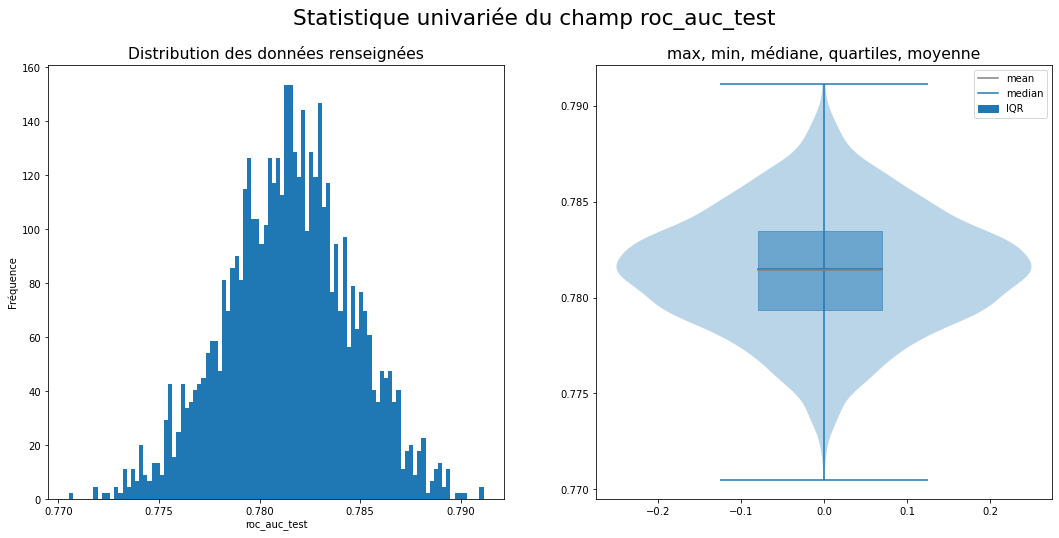

Mesures de position
 - Moyenne: 0.78143
 - Médiane: 0.78149
Mesures de dispertion
 - Ecart type: 0.00315
 - Min: 0.77051
 - Q25: 0.77937
 - Q75: 0.78348
 - Max: 0.79113
Mesures de forme
 - Skewness (asymétrie): -0.078
 - Kurtosis (applatissement): -0.054


In [29]:
myDf(results).Stat('roc_auc_test', violinPlot=True)

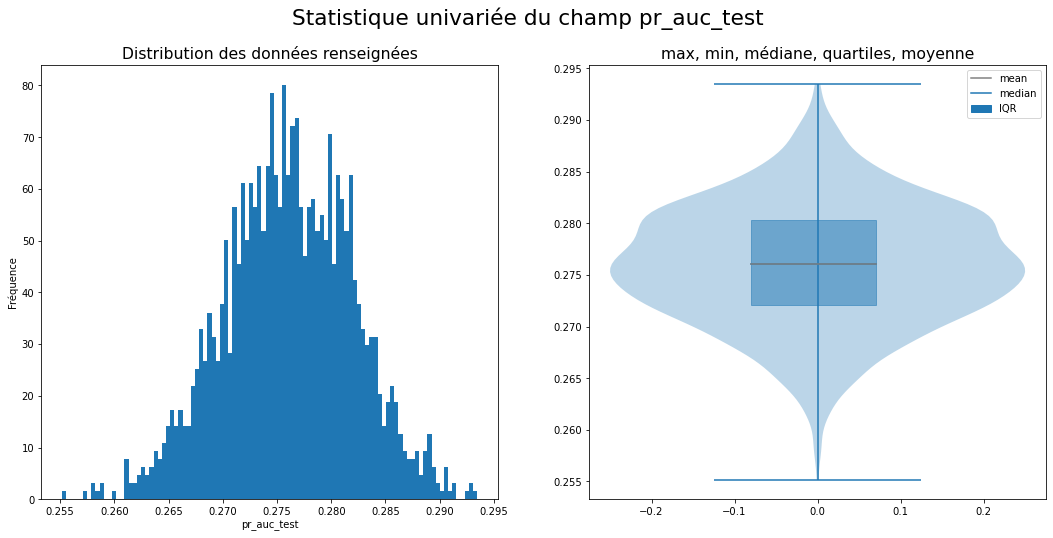

Mesures de position
 - Moyenne: 0.27606
 - Médiane: 0.27607
Mesures de dispertion
 - Ecart type: 0.00592
 - Min: 0.25518
 - Q25: 0.27207
 - Q75: 0.28031
 - Max: 0.29347
Mesures de forme
 - Skewness (asymétrie): -0.088
 - Kurtosis (applatissement): -0.06


In [17]:
myDf(results).Stat('pr_auc_test', violinPlot=True)

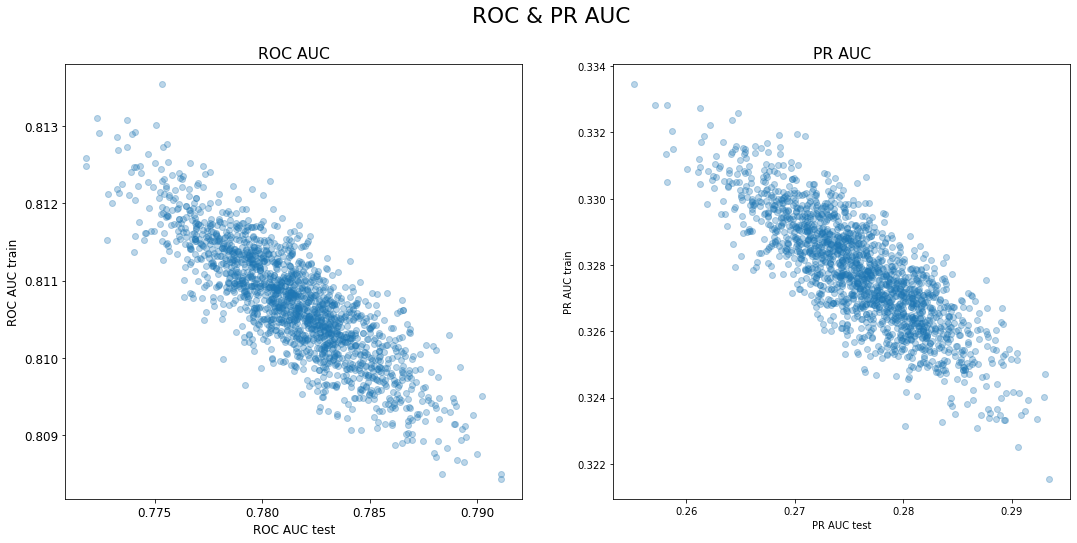

In [46]:
plt.rcParams.update({'font.size':12})

fig = plt.figure(figsize=(1 * (18 * 2/2), 1 * 8))

# 1 - Affichage d'un scatter plot
sub = fig.add_subplot(1,2,1)
plt.rcParams.update({'font.size':13, 'font.style':'italic'})
sub.set_title('ROC AUC')

plt.rcParams.update({'font.size':10, 'font.style':'normal'})
plt.scatter(results.roc_auc_test, results.roc_auc_train, alpha=0.3)
plt.gca().set_xlabel('ROC AUC test')
plt.gca().set_ylabel('ROC AUC train')

# 2 - Affichage de boites parallèles
sub = fig.add_subplot(1,2,2)
plt.rcParams.update({'font.size':13, 'font.style':'italic'})
sub.set_title('PR AUC')

plt.rcParams.update({'font.size':10, 'font.style':'normal'})
plt.scatter(results.pr_auc_test, results.pr_auc_train, alpha=0.3)
plt.gca().set_xlabel('PR AUC test')
plt.gca().set_ylabel('PR AUC train')


plt.rcParams.update({'font.size':18})
plt.suptitle("ROC & PR AUC")

plt.show()


## Feature importance

In [47]:
imp = featureImportance(imputeScaleAndEncode(dfApplication, target='TARGET', identifier='SK_ID_CURR'), target='TARGET', identifier='SK_ID_CURR', model=model)
imp[['feature','impMean']]

feature  impMean
0                                     EXT_SOURCE_3     87.0
1                                     EXT_SOURCE_1     84.0
2                                     EXT_SOURCE_2     76.0
3                                       DAYS_BIRTH     74.0
4                                       AMT_CREDIT     65.0
5    INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG     55.0
6                                      AMT_ANNUITY     49.0
7                                  AMT_GOODS_PRICE     46.0
8                    POSCASH_CNT_INSTALMENT_FUTURE     43.0
9                      PREVBURO_LAST_DAYS_DECISION     39.0
10                                   DAYS_EMPLOYED     39.0
11                          BURO_AMT_CREDIT_ACTIVE     37.0
12                        BURO_AMT_CREDIT_SUM_DEBT     37.0
13              POSCASH_CNT_INSTALMENT_FUTURE_LEFT     35.0
14                             BURO_AMT_CREDIT_SUM     35.0
15                               DAYS_REGISTRATION     34.0
16                                 DAYS_ID_PUBLISH     34.0
17              POSCASH_CNT_INSTALMENT_FUTURE_DONE     33.0
18                              PREV_AMT_COMPLETED     30.0
19                     BURO_AMT_CREDIT_MAX_OVERDUE     27.0
20    INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS     27.0
21                               ORGANIZATION_TYPE     27.0
22                       BURO_AMT_CREDIT_COMPLETED     26.0
23                                PREV_AMT_ANNUITY     25.0
24                              PREVBURO_DAYS_DIFF     24.0
25         PREV_AMT_CREDIT_ACTIVE_REIMBURSED_INDIC     23.0
26                              NAME_FAMILY_STATUS     23.0
27   INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_POS     22.0
28                                AMT_INCOME_TOTAL     21.0
29                      REGION_POPULATION_RELATIVE     21.0
30                            RATIO_ANNUITY_INCOME     21.0
31                                     CODE_GENDER     21.0
32                          DAYS_LAST_PHONE_CHANGE     21.0
33                                BURO_DAYS_CREDIT     19.0
34                              POSCASH_SK_DPD_DEF     19.0
35                         INSTALPAYMT_AMT_PAYMENT     19.0
36               CREDCARD_CNT_DRAWINGS_ATM_CURRENT     19.0
37                                NB_DOC_FURNISHED     18.0
38                       BURO_AMT_CREDIT_SUM_LIMIT     18.0
39                        BURO_DAYS_CREDIT_ENDDATE     17.0
40                                PREV_CNT_PAYMENT     17.0
41                       PREV_NAME_YIELD_GROUP_ORD     16.0
42                          PREV_AMT_CREDIT_ACTIVE     16.0
43    INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_NEG     16.0
44                           PREV_AMT_DOWN_PAYMENT     15.0
45                                 OCCUPATION_TYPE     15.0
46                           PREV_SELLERPLACE_AREA     15.0
47                   CREDCARD_CNT_DRAWINGS_CURRENT     14.0
48                         PREV_AMT_ANNUITY_ACTIVE     14.0
49                      INSTALPAYMT_AMT_INSTALMENT     14.0
50                     REGION_RATING_CLIENT_W_CITY     13.0
51                          PREV_RATE_DOWN_PAYMENT     12.0
52                                    FLAG_OWN_CAR     12.0
53                     BURO_AMT_CREDIT_SUM_OVERDUE     12.0
54                         CREDCARD_MONTHS_BALANCE     12.0
55                         HOUR_APPR_PROCESS_START     12.0
56                CREDCARD_AMT_CREDIT_LIMIT_ACTUAL     11.0
57                          POSCASH_CNT_INSTALMENT     11.0
58                         PREV_CODE_REJECT_REASON     11.0
59               CREDCARD_CNT_DRAWINGS_POS_CURRENT     11.0
60               CREDCARD_AMT_DRAWINGS_ATM_CURRENT     11.0
61                            PREV_AMT_GOODS_PRICE     11.0
62              CREDCARD_AMT_PAYMENT_TOTAL_CURRENT     11.0
63                  INSTALPAYMT_DAYS_ENTRY_PAYMENT     11.0
64              CREDCARD_CNT_INSTALMENT_MATURE_CUM     10.0
65                  PREV_DAYS_LAST_DUE_1ST_VERSION     10.0
66                     

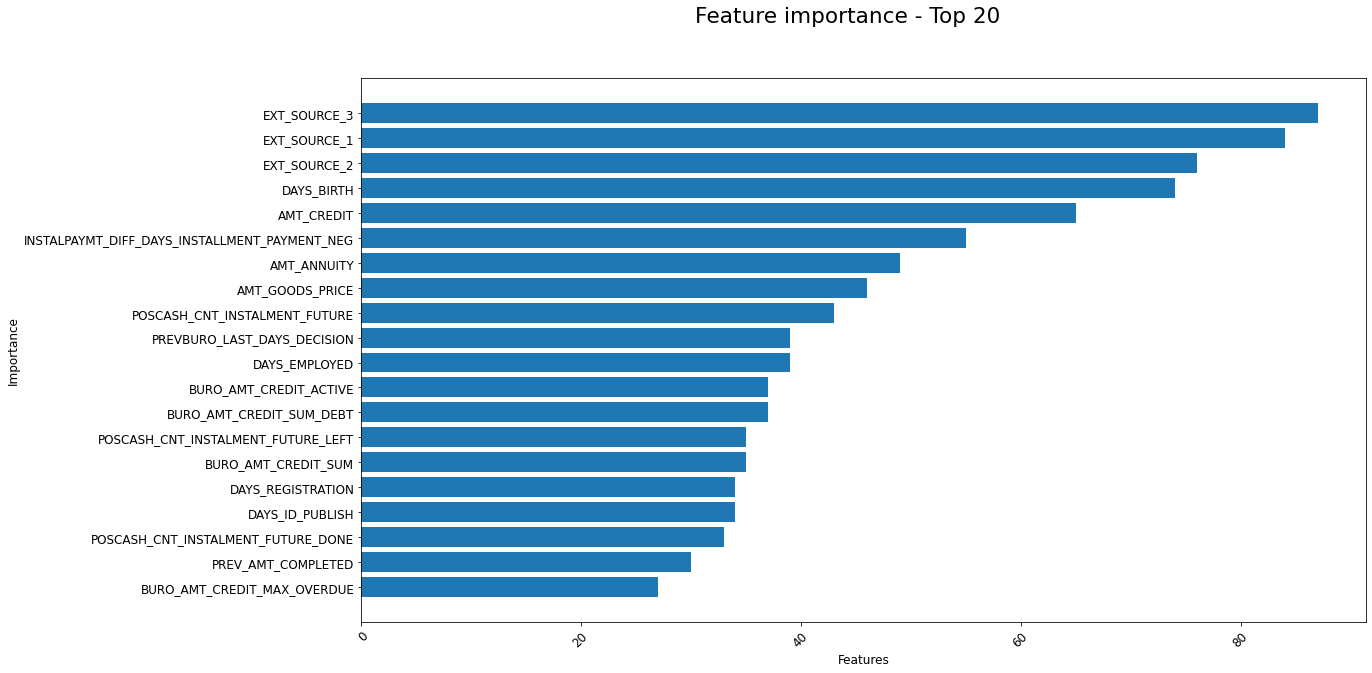

In [55]:
plt.rcParams.update({'font.size':12})

fig = plt.figure(figsize=(18, 10))

impplot = imp[0:20].sort_values('impMean', ascending=True)

sub = fig.add_subplot(1,1,1)

plt.rcParams.update({'font.size':10, 'font.style':'normal'})
plt.barh(impplot['feature'], impplot['impMean'])
plt.gca().set_xlabel('Features')
plt.gca().set_ylabel('Importance')


plt.rcParams.update({'font.size':18})
plt.suptitle("Feature importance - Top 20")

plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

plt.show()

In [22]:
dfApplicationComplete.shape

(289444, 230)

In [142]:
results_tmp = []
res = evaluateRocPrCurves(dfApplication, model=model, title_plot='Initial', display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50)
res.groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

title  roc_auc_train  roc_auc_test  pr_auc_train  pr_auc_test  \
0  Initial       0.818379      0.782516      0.338712     0.274768   

   time_train  time_pred  nb_feat  nb_train     timestamp  
0    4.884299   1.536819      152    182349  1.615909e+09

In [28]:
from pickle import load
from pickle import dump
from myTools import *
import datetime

from lightgbm import LGBMClassifier

def imputeScaleAndEncode(df1, 
                    target='', 
                    identifier=''):
    
    df = df1.copy()
    
    if type(target) == str:
        target = [target]
    if type(identifier) == str:
        identifier = [identifier]
    
    colToExclude = target
    colToExclude.extend(identifier)
    
    for col in df.columns:
        if col not in colToExclude:
            if df[col].dtypes == 'object':
                df[col] = df[col].replace(np.nan, 'missing')
                df[col] = OrdinalEncoder().fit_transform(df[[col]])
            elif df[col].dtype in ['int64','float64']:
                df[col] = SimpleImputer(strategy='mean').fit_transform(df[[col]])
                df[col] = MinMaxScaler().fit_transform(df[[col]])  
                
    return df


dfApplicationComplete = load(open('dfApplicationComplete.pkl','rb'))
dfApplication, dfApplicationVal = train_test_split(dfApplicationComplete, test_size=0.3, random_state=1)

model = LGBMClassifier(max_depth=4, learning_rate=0.1, num_leaves=8, min_child_samples=200, subsample_for_bin=25000, n_estimators=250, n_jobs=-1)
imp = featureImportance(imputeScaleAndEncode(dfApplication, target='TARGET', identifier='SK_ID_CURR'), target='TARGET', identifier='SK_ID_CURR', model=model)
imp[['feature','impMean']]
for index, row in imp.iterrows():
    if row.impMean == 0:
        del dfApplication[row.feature]

model = LGBMClassifier(max_depth=7, learning_rate=0.125, num_leaves=8, min_child_samples=300, subsample_for_bin=25000, n_estimators=300, n_jobs=-1)
kbins50 = ['AMT_INCOME_TOTAL',
 'APARTMENTS_AVG',
 'COMMONAREA_AVG',
 'LIVINGAREA_AVG',
 'LANDAREA_MODE',
 'NONLIVINGAREA_MODE',
 'PREV_AMT_CREDIT_ACTIVE_REIMBURSED_INDIC',
 'INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS',
 'PREV_AMT_APPLICATION',
 'PREV_AMT_GOODS_PRICE',
 'PREV_DAYS_LAST_DUE',
 'PREV_DAYS_TERMINATION',
 'CREDCARD_AMT_DRAWINGS_CURRENT',
 'CREDCARD_AMT_RECEIVABLE_PRINCIPAL',
 'CREDCARD_CNT_DRAWINGS_ATM_CURRENT',
 'CREDCARD_CNT_DRAWINGS_CURRENT',
 'CREDCARD_CNT_DRAWINGS_POS_CURRENT',
 'POSCASH_MONTHS_BALANCE',
 'INSTALPAYMT_DAYS_ENTRY_PAYMENT',
 'INSTALPAYMT_AMT_INSTALMENT',
 'INSTALPAYMT_AMT_PAYMENT']

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN

results_tmp = []

for rnd in np.arange(2):
    res = evaluateRocPrCurves(dfApplication, model=model, title_plot=str(rnd), display_plot=False, target='TARGET', identifier='SK_ID_CURR', kbins50=kbins50, over=None, under=None)
    results_tmp.append(res)
    dump(results_tmp, open('results_tmpx.pkl','wb'))

In [20]:
dump(list(dfApplicationComplete.columns), open('colApplicationFinal','wb'))

In [30]:
r = load(open('results_tmpx.pkl','rb'))

In [2]:
pipeline = load(open('pipeline.pkl','rb'))

In [4]:
pipeline[1]

LGBMClassifier(learning_rate=0.125, max_depth=7, min_child_samples=300,
               n_estimators=300, num_leaves=8, subsample_for_bin=25000)

In [14]:
pipeline = load(open('pipeline.pkl','rb'))
pipeline[0].transformers

[('1',
  Pipeline(steps=[('imp', SimpleImputer(strategy='most_frequent')),
                  ('trans',
                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                  unknown_value=-10)),
                  ('scal', IdentityTransformer())]),
  ['NAME_CONTRACT_TYPE',
   'CODE_GENDER',
   'FLAG_OWN_CAR',
   'FLAG_OWN_REALTY',
   'NAME_TYPE_SUITE',
   'NAME_INCOME_TYPE',
   'NAME_EDUCATION_TYPE',
   'NAME_FAMILY_STATUS',
   'NAME_HOUSING_TYPE',
   'OCCUPATION_TYPE',
   'WEEKDAY_APPR_PROCESS_START',
   'ORGANIZATION_TYPE',
   'FONDKAPREMONT_MODE',
   'HOUSETYPE_MODE',
   'WALLSMATERIAL_MODE',
   'EMERGENCYSTATE_MODE',
   'PREV_CODE_REJECT_REASON',
   'PREV_NAME_CONTRACT_TYPE',
   'PREV_WEEKDAY_APPR_PROCESS_START',
   'PREV_NAME_PAYMENT_TYPE',
   'PREV_NAME_TYPE_SUITE',
   'PREV_NAME_CLIENT_TYPE',
   'PREV_NAME_GOODS_CATEGORY',
   'PREV_NAME_PORTFOLIO',
   'PREV_NAME_PRODUCT_TYPE',
   'PREV_CHANNEL_TYPE',
   'PREV_NAME_SELLER_INDUSTRY',
   'PREV_NAME_Y

In [17]:
results_tmp= pd.concat(results_tmp).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)
results_tmp = results_tmp[['title','roc_auc_train','roc_auc_test','pr_auc_train','pr_auc_test']]
roc_auc_test_ini = results_tmp[results_tmp.title == 'Initial'].roc_auc_test.values[0]
pr_auc_test_ini = results_tmp[results_tmp.title == 'Initial'].pr_auc_test.values[0]
results_tmp['gain_roc'] = results_tmp.apply(lambda x: 1000 * (x.roc_auc_test - roc_auc_test_ini), axis=1)
results_tmp['gain_pr'] = results_tmp.apply(lambda x: 1000 * (x.pr_auc_test - pr_auc_test_ini), axis=1)
results_tmp['gain'] = results_tmp.apply(lambda x: 1000 * (x.roc_auc_test - roc_auc_test_ini + x.pr_auc_test - pr_auc_test_ini), axis=1)
results_tmp

title  \
0                                                                 Initial   
1               Optimisation imputer sur variables appartement - constant   
2  Optimisation imputer sur variables appartement - mean et most frequent   

   roc_auc_train  roc_auc_test  pr_auc_train  pr_auc_test  gain_roc   gain_pr  \
0       0.819053      0.781632      0.340811     0.273632  0.000000  0.000000   
1       0.819153      0.782633      0.340570     0.272937  1.000709 -0.694611   
2       0.819228      0.781717      0.340416     0.273460  0.084705 -0.171848   

       gain  
0  0.000000  
1  0.306098  
2 -0.087144

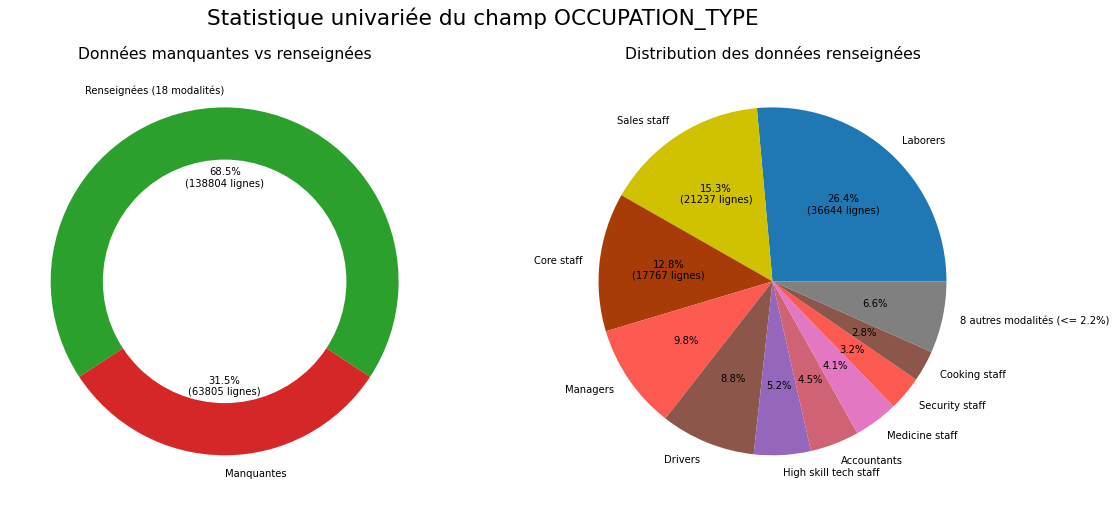

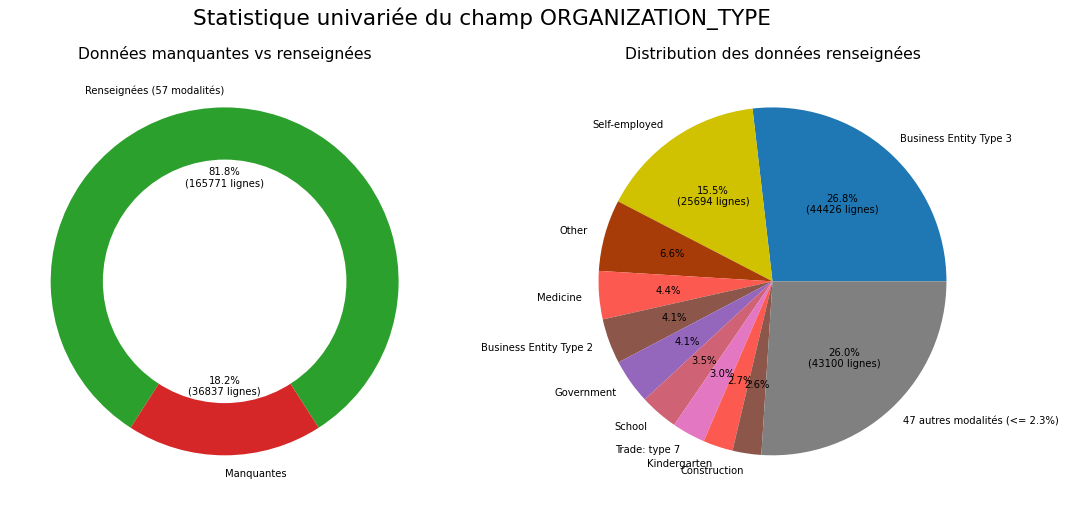

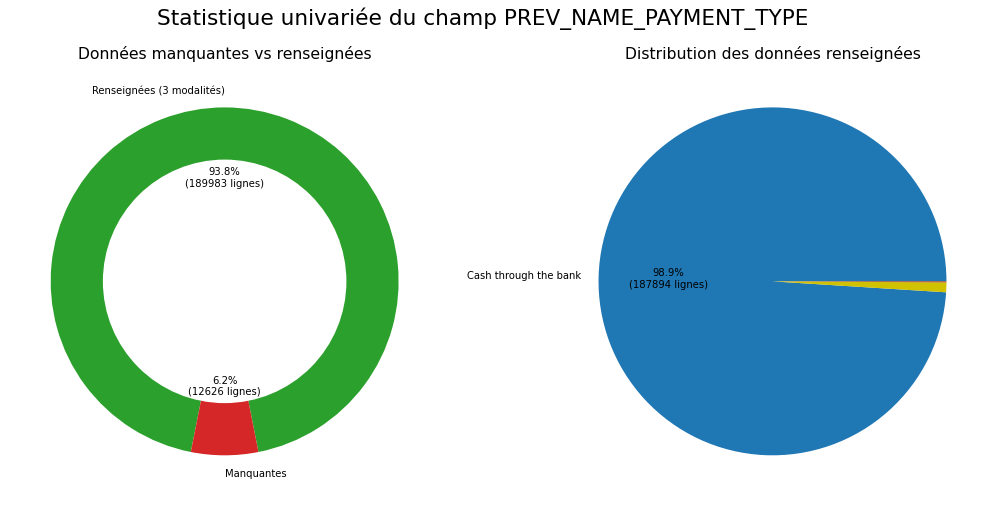

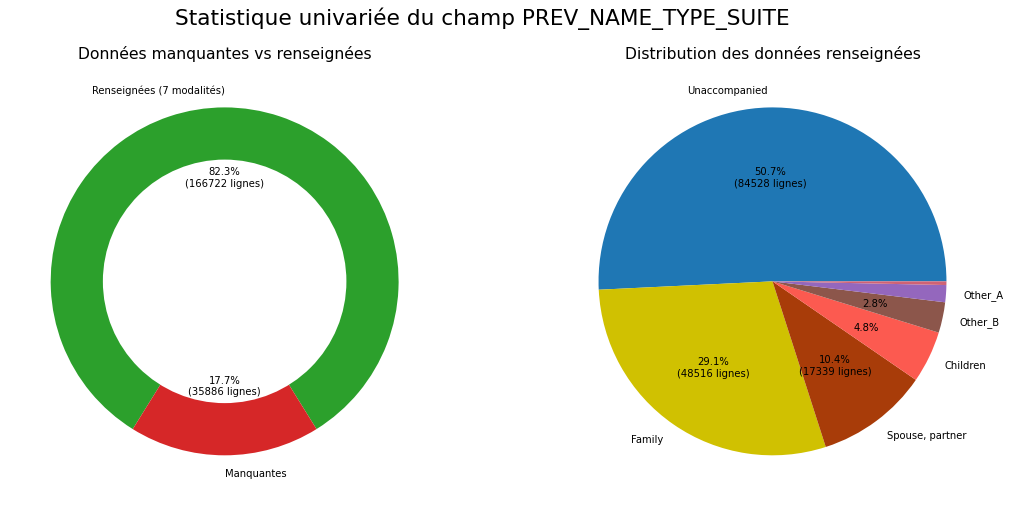

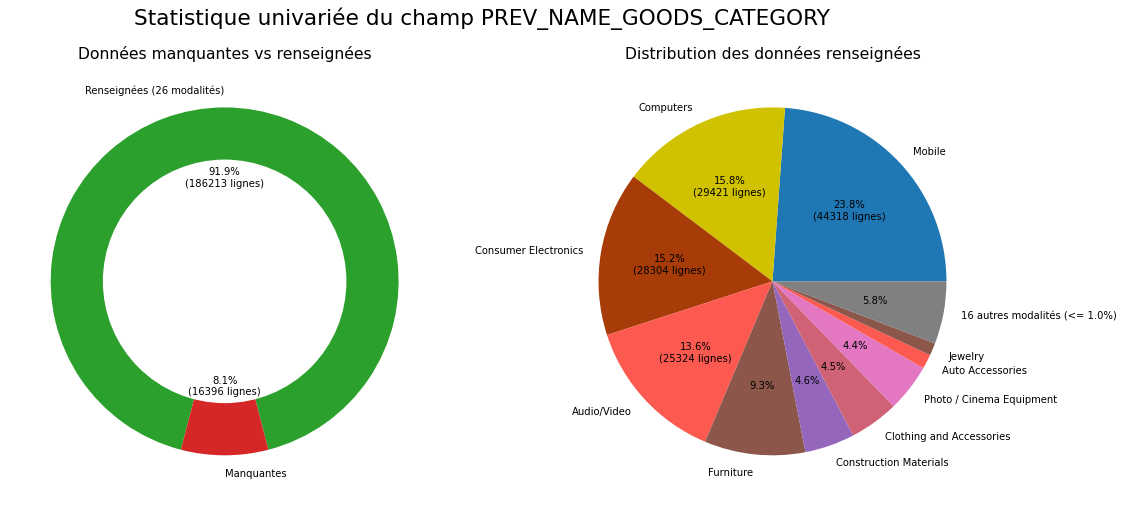

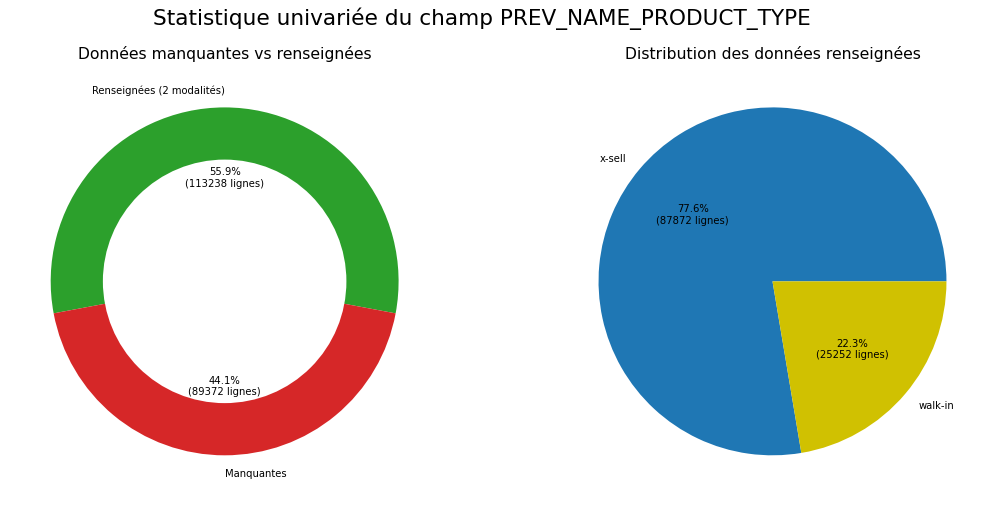

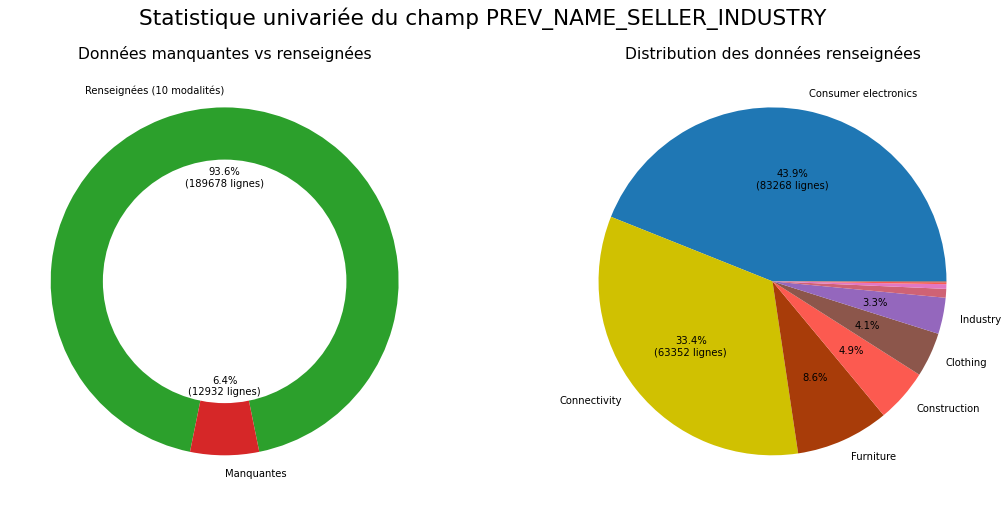

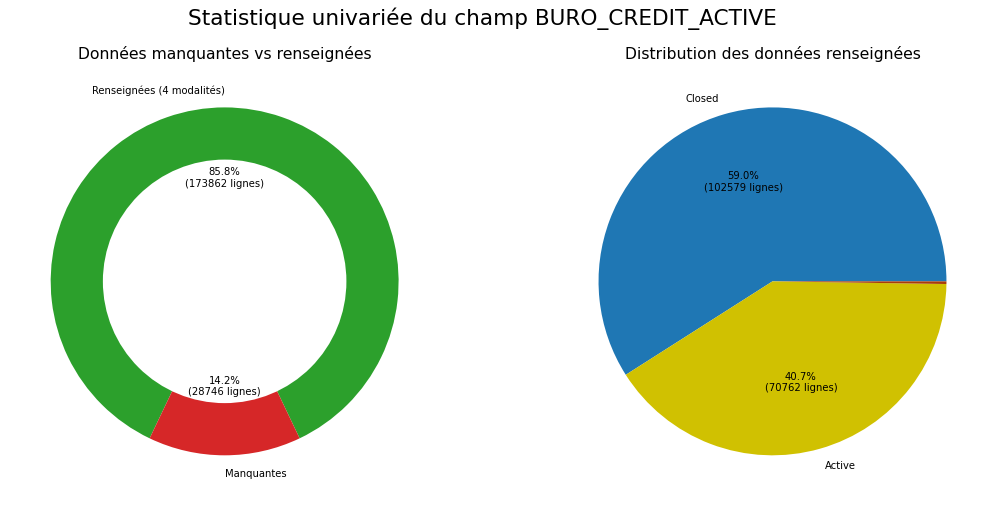

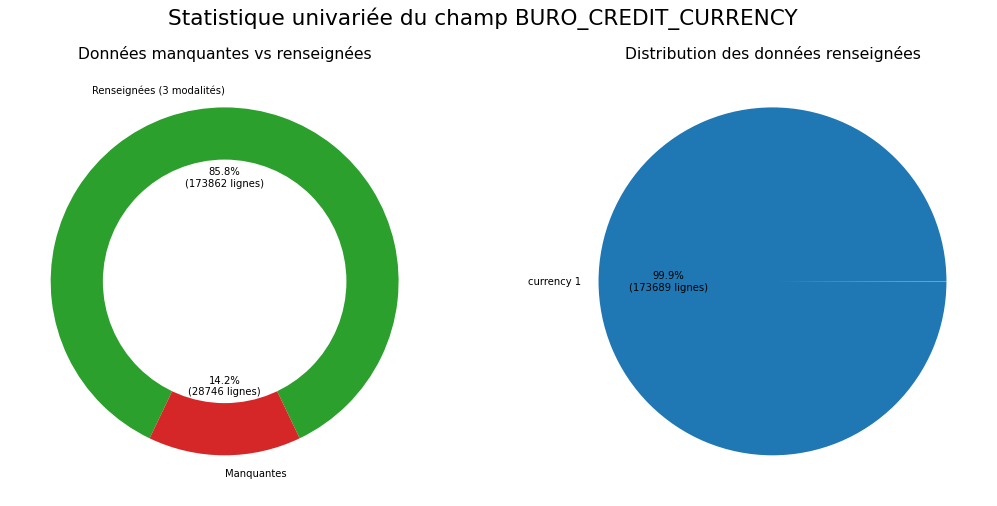

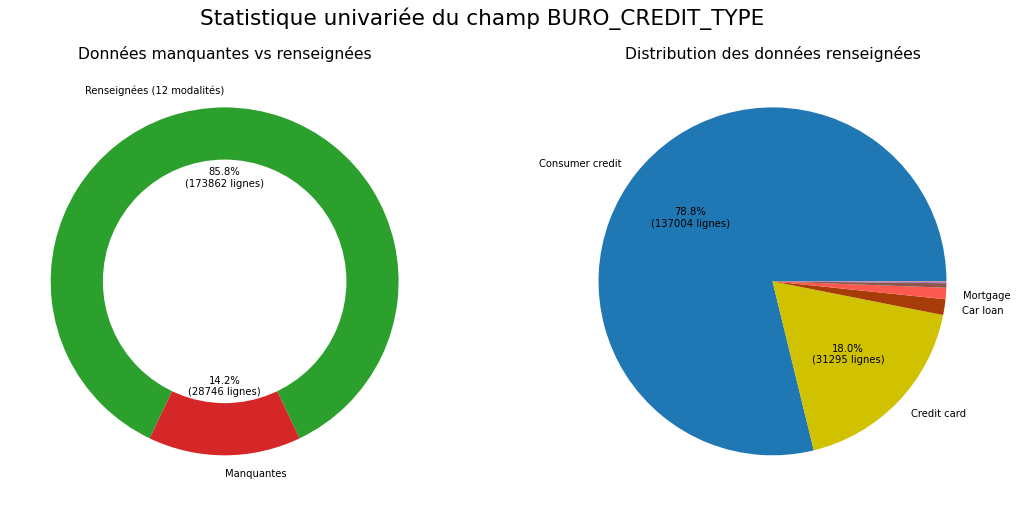

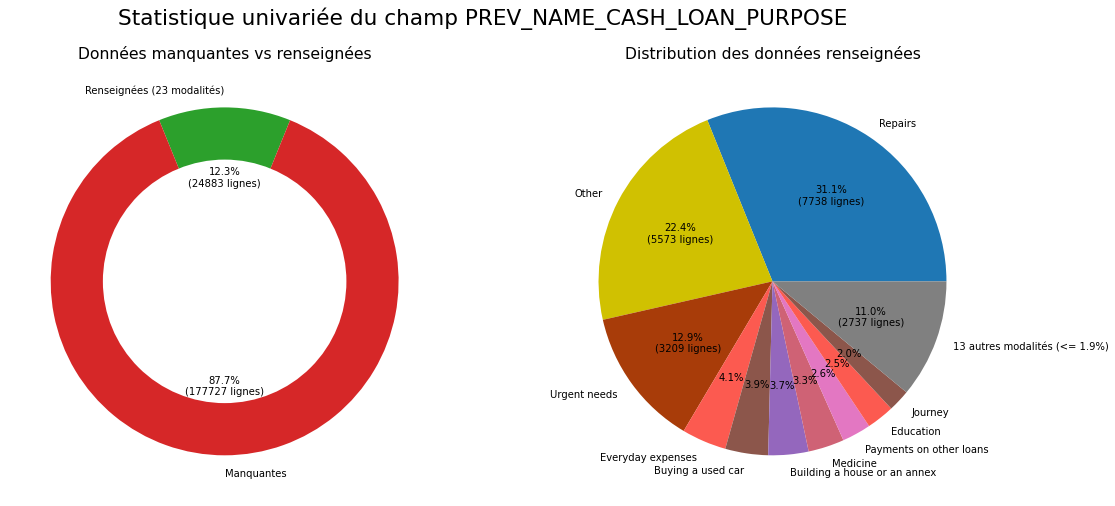

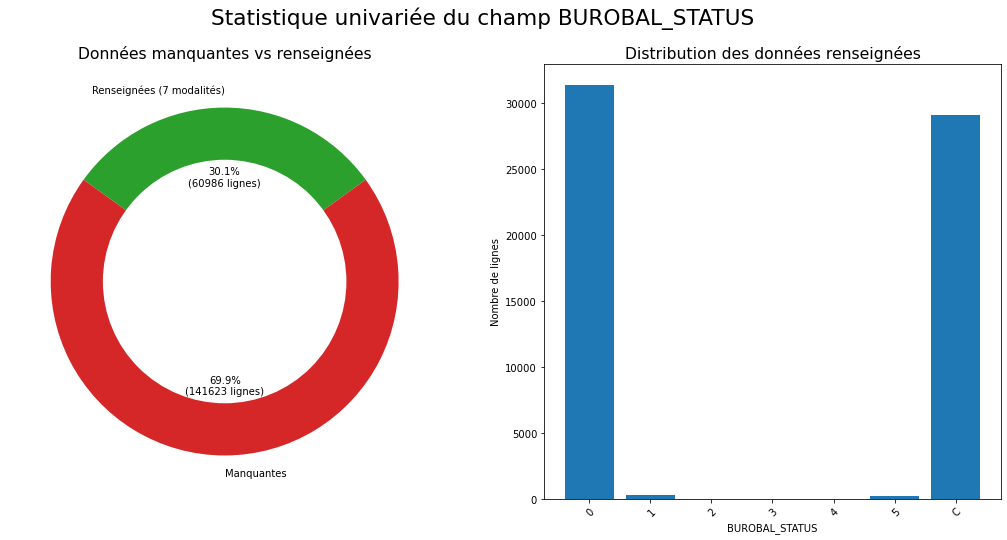

In [21]:
for col in dfApplication.columns:
    if not ((col.find('MEDI')>0) | (col.find('AVG')>0) | (col.find('MODE')>0)):
        if (dfApplication[col].dtypes == 'object') & (dfApplication[dfApplication[col].isnull()].shape[0] > 2000):
            myDf(dfApplication).Stat(col, statsNan=True)

# Suppression des features qui diminuent les performances

In [8]:
model = LGBMClassifier(max_depth=7, learning_rate=0.125, num_leaves=8, min_child_samples=300, subsample_for_bin=25000, n_estimators=300, n_jobs=-1)
imp = featureImportance(imputeScaleAndEncode(dfApplication, target='TARGET', identifier='SK_ID_CURR'), target='TARGET', identifier='SK_ID_CURR', model=model)
imp = imp[['feature','impMean']]

In [9]:
imp

feature  impMean
0                                     EXT_SOURCE_3     90.0
1                                     EXT_SOURCE_1     84.0
2                                     EXT_SOURCE_2     72.0
3                                       DAYS_BIRTH     64.0
4                                       AMT_CREDIT     59.0
5                    POSCASH_CNT_INSTALMENT_FUTURE     56.0
6                           BURO_AMT_CREDIT_ACTIVE     40.0
7                                      AMT_ANNUITY     39.0
8                         BURO_AMT_CREDIT_SUM_DEBT     39.0
9                                    DAYS_EMPLOYED     35.0
10                               DAYS_REGISTRATION     33.0
11                              PREV_AMT_COMPLETED     33.0
12                             BURO_AMT_CREDIT_SUM     33.0
13   INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG     33.0
14                     PREVBURO_LAST_DAYS_DECISION     33.0
15                                 AMT_GOODS_PRICE     32.0
16                                 DAYS_ID_PUBLISH     31.0
17                            RATIO_ANNUITY_INCOME     30.0
18                          PREV_AMT_CREDIT_ACTIVE     29.0
19    INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS     29.0
20                       BURO_AMT_CREDIT_COMPLETED     29.0
21                          DAYS_LAST_PHONE_CHANGE     28.0
22                              PREVBURO_DAYS_DIFF     27.0
23                     BURO_AMT_CREDIT_MAX_OVERDUE     26.0
24                               ORGANIZATION_TYPE     24.0
25                                     CODE_GENDER     24.0
26                              NAME_FAMILY_STATUS     23.0
27         PREV_AMT_CREDIT_ACTIVE_REIMBURSED_INDIC     21.0
28                       PREV_NAME_YIELD_GROUP_ORD     21.0
29                              POSCASH_SK_DPD_DEF     21.0
30                              PREV_DAYS_LAST_DUE     20.0
31                        BURO_DAYS_CREDIT_ENDDATE     20.0
32                                PREV_AMT_ANNUITY     19.0
33                     REGION_RATING_CLIENT_W_CITY     19.0
34    INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_NEG     18.0
35                           PREV_AMT_DOWN_PAYMENT     18.0
36                       BURO_AMT_CREDIT_SUM_LIMIT     18.0
37   INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_POS     18.0
38                      REGION_POPULATION_RELATIVE     17.0
39                                AMT_INCOME_TOTAL     17.0
40                           PREV_SELLERPLACE_AREA     16.0
41                   CREDCARD_CNT_DRAWINGS_CURRENT     16.0
42                                BURO_DAYS_CREDIT     16.0
43                                NB_DOC_FURNISHED     15.0
44                                 PREV_NB_REFUSED     15.0
45               CREDCARD_CNT_DRAWINGS_ATM_CURRENT     15.0
46                      INSTALPAYMT_AMT_INSTALMENT     14.0
47                         BURO_DAYS_CREDIT_UPDATE     14.0
48                          POSCASH_CNT_INSTALMENT     14.0
49                         INSTALPAYMT_AMT_PAYMENT     14.0
50                             NAME_EDUCATION_TYPE     14.0
51                    PREV_HOUR_APPR_PROCESS_START     13.0
52                                PREV_CNT_PAYMENT     13.0
53                                 OCCUPATION_TYPE     13.0
54               CREDCARD_AMT_DRAWINGS_ATM_CURRENT     13.0
55                          POSCASH_MONTHS_BALANCE     12.0
56                     BURO_AMT_CREDIT_SUM_OVERDUE     12.0
57                  INSTALPAYMT_DAYS_ENTRY_PAYMENT     12.0
58                         CREDCARD_MONTHS_BALANCE     12.0
59                         PREV_AMT_ANNUITY_ACTIVE     12.0
60                          PREV_RATE_DOWN_PAYMENT     11.0
61                         PREV_CODE_REJECT_REASON     11.0
62                                    FLAG_OWN_CAR     11.0
63              CREDCARD_AMT_PAYMENT_TOTAL_CURRENT     11.0
64                                 PREV_AMT_CREDIT     10.0
65               CREDCARD_AMT_RECEIVABLE_PRINCIPAL     10.0
66                     

In [ ]:
results_tmp = []

model = LGBMClassifier(max_depth=7, learning_rate=0.125, num_leaves=8, min_child_samples=300, subsample_for_bin=25000, n_estimators=300, n_jobs=-1)
res = evaluate(dfApplication, model, title='Initial', display_plot=False)
results_tmp.append(res)

i = 1
for index, row in imp.iterrows():
    print(datetime.datetime.now())
    print(str(i) + ' ' + row.feature)
    i+=1
    df = dfApplication.copy()
    del df[row.feature]
    res = evaluate(df, model, title=row.feature, display_plot=False)
    results_tmp.append(res)
    dump(results_tmp, open('results_tmp.pkl','wb'))
    
dump(results_tmp, open('results_remove_feature.pkl','wb'))

In [30]:
results_tmp = load(open('results_remove_feature.pkl','rb'))
results_tmp= pd.concat(results_tmp).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)
results_tmp = results_tmp[['title','roc_auc_train','roc_auc_test','pr_auc_train','pr_auc_test']]
roc_auc_test_ini = results_tmp[results_tmp.title == 'Initial'].roc_auc_test.values[0]
pr_auc_test_ini = results_tmp[results_tmp.title == 'Initial'].pr_auc_test.values[0]
results_tmp['gain_roc'] = results_tmp.apply(lambda x: 1000 * (x.roc_auc_test - roc_auc_test_ini), axis=1)
results_tmp['gain_pr'] = results_tmp.apply(lambda x: 1000 * (x.pr_auc_test - pr_auc_test_ini), axis=1)
results_tmp['gain'] = results_tmp.apply(lambda x: 1000 * (x.roc_auc_test - roc_auc_test_ini + x.pr_auc_test - pr_auc_test_ini), axis=1)



In [31]:
for col in dfApplication:
    if (col not in list(results_tmp.title)) and (col not in ['SK_ID_CURR','TARGET']):
        del dfApplication[col]

In [34]:
results_tmp = results_tmp[results_tmp.gain > 0]
results_tmp.sort_values('gain', ascending=False)

title  roc_auc_train  \
99                  PREV_NFLAG_INSURED_ON_APPROVAL       0.815046   
79                        PREV_NAME_GOODS_CATEGORY       0.815205   
50               CREDCARD_CNT_DRAWINGS_ATM_CURRENT       0.815024   
103                                 LIVINGAREA_AVG       0.815211   
69                            PREV_NAME_TYPE_SUITE       0.815240   
46                                 OCCUPATION_TYPE       0.815164   
28                                PREV_AMT_ANNUITY       0.815201   
68                                 PREV_NB_REFUSED       0.815298   
94                       PREV_NAME_CONTRACT_STATUS       0.814988   
116                   YEARS_BEGINEXPLUATATION_MODE       0.815314   
65                              PREV_DAYS_DECISION       0.815215   
54                           PREV_DAYS_TERMINATION       0.815223   
81                                 LIVINGAREA_MODE       0.815142   
16                             BURO_AMT_CREDIT_SUM       0.814894   
119                    PREV_NAME_CASH_LOAN_PURPOSE       0.814986   
59                  PREV_DAYS_LAST_DUE_1ST_VERSION       0.815124   
33                    PREV_HOUR_APPR_PROCESS_START       0.815120   
135                             BURO_CREDIT_ACTIVE       0.815143   
43                                PREV_CNT_PAYMENT       0.815075   
83                           LIVINGAPARTMENTS_MEDI       0.815269   
78                            PREV_AMT_APPLICATION       0.815277   
92               CREDCARD_CNT_DRAWINGS_POS_CURRENT       0.815251   
67               CREDCARD_AMT_DRAWINGS_ATM_CURRENT       0.815228   
30                          PREV_AMT_CREDIT_ACTIVE       0.815039   
111             CREDCARD_CNT_INSTALMENT_MATURE_CUM       0.815159   
128                 PREV_LAST_NAME_CONTRACT_STATUS       0.815151   
102                      PREV_NAME_SELLER_INDUSTRY       0.815080   
75                                BURO_AMT_ANNUITY       0.815106   
71                    CREDCARD_AMT_PAYMENT_CURRENT       0.815124   
74                CREDCARD_AMT_CREDIT_LIMIT_ACTUAL       0.815161   
100                               BURO_CREDIT_TYPE       0.815121   
157                                 BUROBAL_STATUS       0.815082   
107                   YEARS_BEGINEXPLUATATION_MEDI       0.815197   
37                      INSTALPAYMT_AMT_INSTALMENT       0.815125   
55                          POSCASH_CNT_INSTALMENT       0.814989   
149                               YEARS_BUILD_MODE       0.815347   
87                                  BUROBAL_SK_DPD       0.815094   
125                       OBS_60_CNT_SOCIAL_CIRCLE       0.815101   
93                            CREDCARD_AMT_BALANCE       0.815242   
39                          BURO_DAYS_ENDDATE_FACT       0.815081   
97                               BASEMENTAREA_MODE       0.815250   
112                              BASEMENTAREA_MEDI       0.815153   
66                          POSCASH_MONTHS_BALANCE       0.815042   
137                             WALLSMATERIAL_MODE       0.815010   
95                            PREV_AMT_GOODS_PRICE       0.815153   
114                                FLAG_DOCUMENT_3       0.815044   
142                         PREV_NAME_PAYMENT_TYPE       0.815120   
25                               ORGANIZATION_TYPE       0.814890   
34                      REGION_POPULATION_RELATIVE       0.815087   
115                                  ENTRANCES_AVG       0.815105   
62                                     OWN_CAR_AGE       0.815071   
20   INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_POS       0.815037   
143                         REG_CITY_NOT_WORK_CITY       0.815179   
141                                 ELEVATORS_MODE       0.815129   
121                                   CNT_CHILDREN       0.815264   
145                            PREV_NAME_PORTFOLIO       0.815165   
155                                CNT_FAM_MEMBERS       0.815123   
96                        DEF_60_CNT_SOCIAL

In [38]:
results_tmp2 = []

model = LGBMClassifier(max_depth=7, learning_rate=0.125, num_leaves=8, min_child_samples=300, subsample_for_bin=25000, n_estimators=300, n_jobs=-1)
res = evaluate(dfApplication[0:100000], model, title='Initial', display_plot=False)
results_tmp2.append(res)

for col in ['PREV_NFLAG_INSURED_ON_APPROVAL','PREV_NAME_GOODS_CATEGORY','CREDCARD_CNT_DRAWINGS_ATM_CURRENT','LIVINGAREA_AVG','PREV_NAME_TYPE_SUITE','OCCUPATION_TYPE']:
    df = dfApplication[0:100000].copy()
    del df[col]
    res = evaluate(df, model, title=col, display_plot=False)
    results_tmp2.append(res)

In [39]:
results_tmp2= pd.concat(results_tmp2).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)
results_tmp2 = results_tmp2[['title','roc_auc_train','roc_auc_test','pr_auc_train','pr_auc_test']]
roc_auc_test_ini = results_tmp2[results_tmp2.title == 'Initial'].roc_auc_test.values[0]
pr_auc_test_ini = results_tmp2[results_tmp2.title == 'Initial'].pr_auc_test.values[0]
results_tmp2['gain_roc'] = results_tmp2.apply(lambda x: 1000 * (x.roc_auc_test - roc_auc_test_ini), axis=1)
results_tmp2['gain_pr'] = results_tmp2.apply(lambda x: 1000 * (x.pr_auc_test - pr_auc_test_ini), axis=1)
results_tmp2['gain'] = results_tmp2.apply(lambda x: 1000 * (x.roc_auc_test - roc_auc_test_ini + x.pr_auc_test - pr_auc_test_ini), axis=1)
results_tmp2

title  roc_auc_train  roc_auc_test  \
0                            Initial       0.843291      0.773248   
1     PREV_NFLAG_INSURED_ON_APPROVAL       0.842906      0.773092   
2           PREV_NAME_GOODS_CATEGORY       0.843134      0.773371   
3  CREDCARD_CNT_DRAWINGS_ATM_CURRENT       0.843330      0.772764   
4                     LIVINGAREA_AVG       0.843315      0.773057   
5               PREV_NAME_TYPE_SUITE       0.843236      0.773493   
6                    OCCUPATION_TYPE       0.842575      0.773005   

   pr_auc_train  pr_auc_test  gain_roc   gain_pr      gain  
0      0.393692     0.266136  0.000000  0.000000  0.000000  
1      0.393637     0.265032 -0.155795 -1.104304 -1.260099  
2      0.393007     0.265082  0.123309 -1.053709 -0.930400  
3      0.393626     0.263888 -0.483704 -2.248598 -2.732302  
4      0.393792     0.265714 -0.190574 -0.422498 -0.613072  
5      0.393685     0.265828  0.245055 -0.308076 -0.063021  
6      0.393026     0.264939 -0.242537 -1.197446 -1.439983

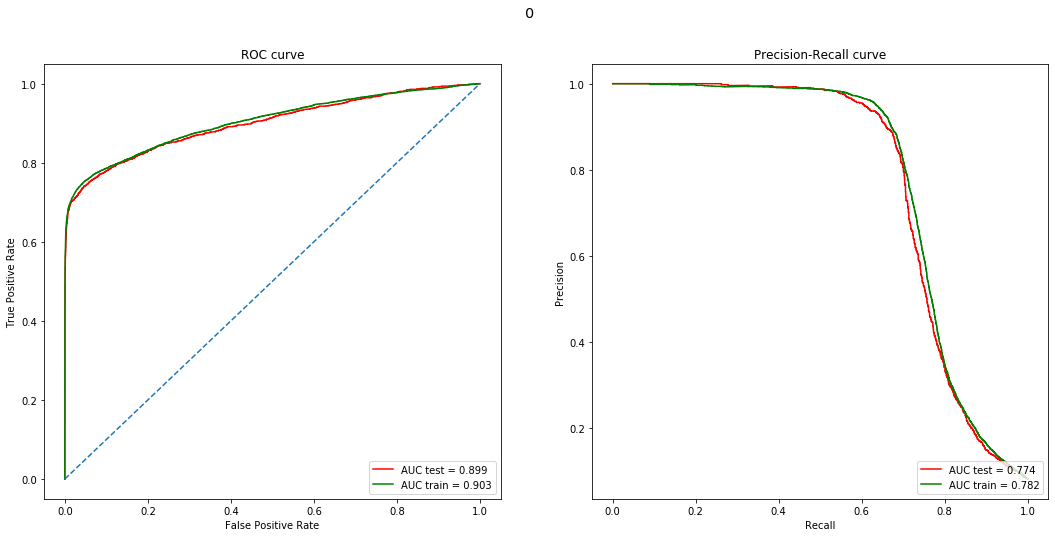

TRAIN SET: ROC AUC=0.903, PR AUC=0.782
TEST SET:  ROC AUC=0.899, PR AUC=0.774


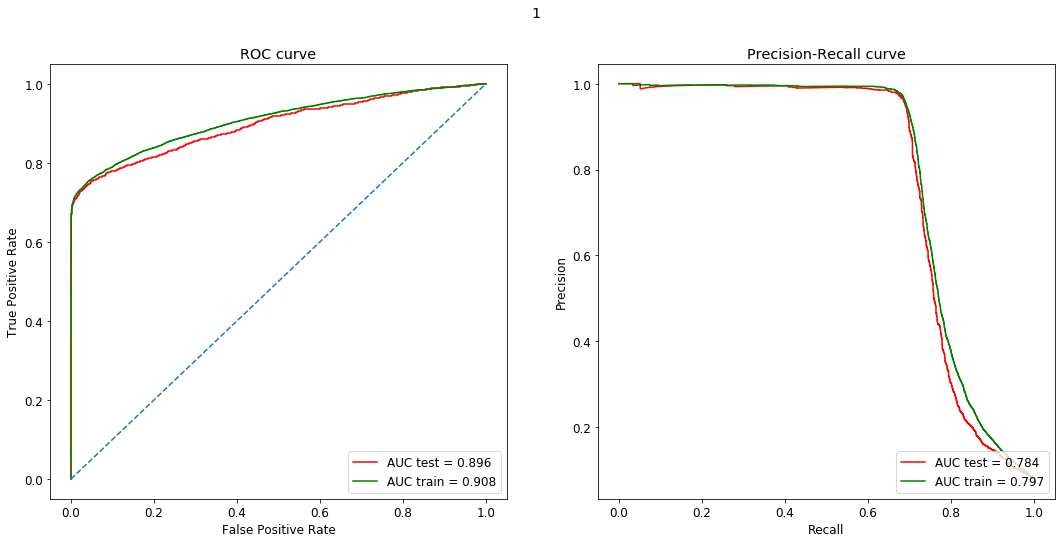

TRAIN SET: ROC AUC=0.908, PR AUC=0.797
TEST SET:  ROC AUC=0.896, PR AUC=0.784


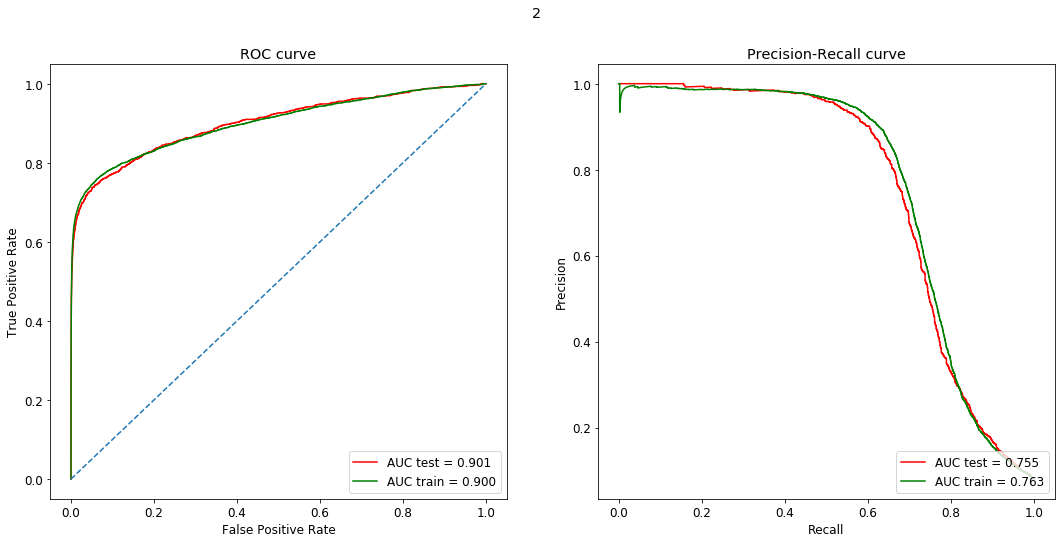

TRAIN SET: ROC AUC=0.900, PR AUC=0.763
TEST SET:  ROC AUC=0.901, PR AUC=0.755


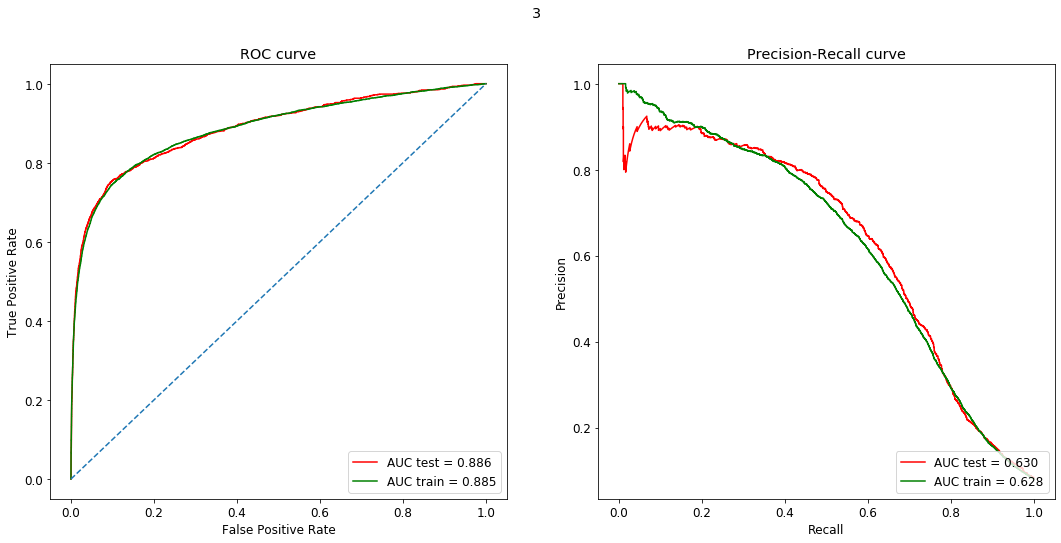

TRAIN SET: ROC AUC=0.885, PR AUC=0.628
TEST SET:  ROC AUC=0.886, PR AUC=0.630


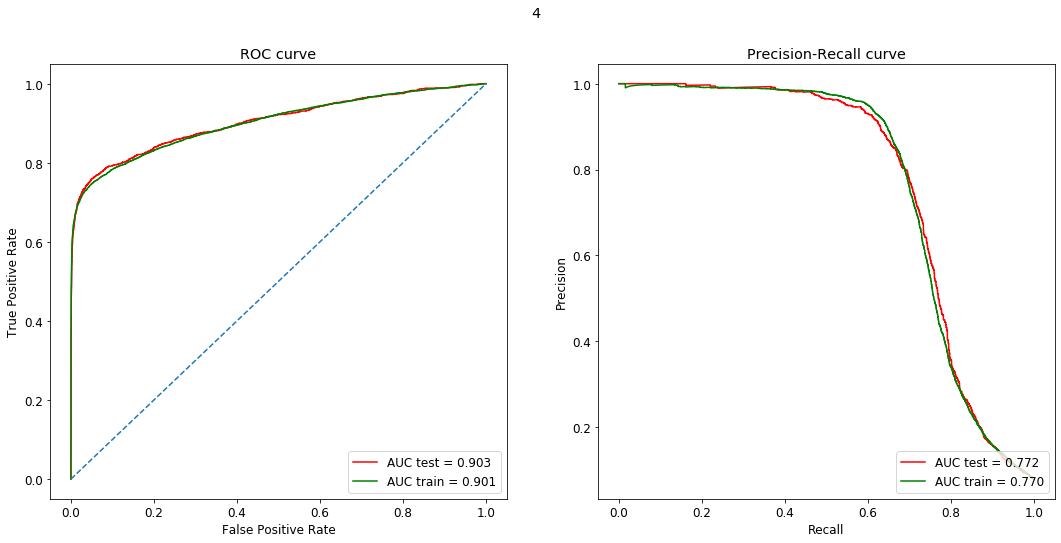

TRAIN SET: ROC AUC=0.901, PR AUC=0.770
TEST SET:  ROC AUC=0.903, PR AUC=0.772


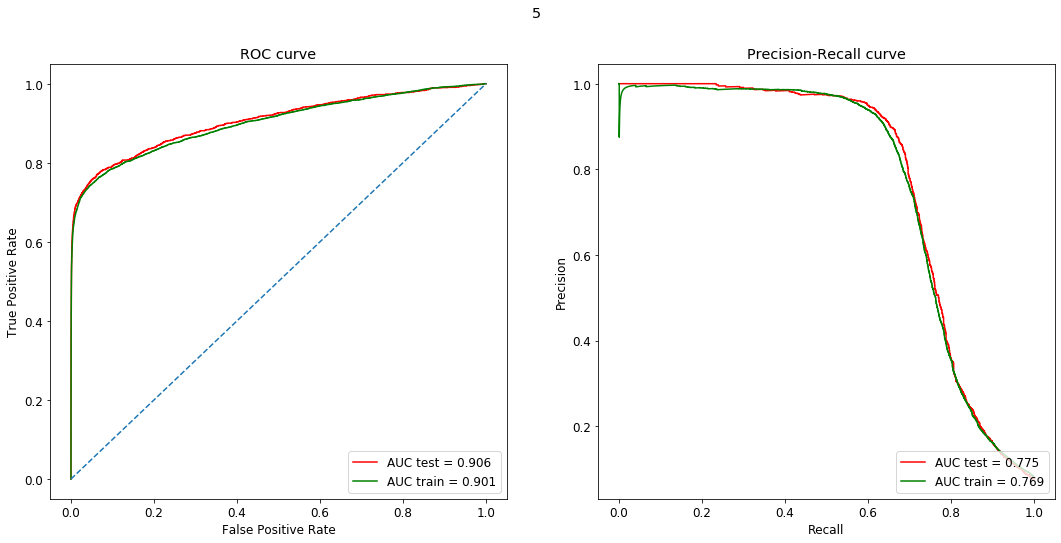

TRAIN SET: ROC AUC=0.901, PR AUC=0.769
TEST SET:  ROC AUC=0.906, PR AUC=0.775


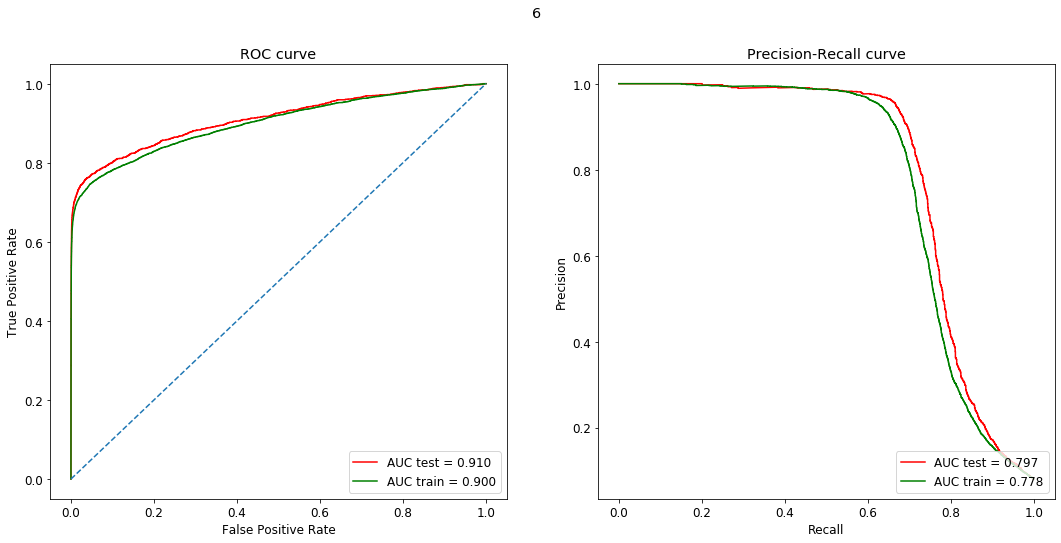

TRAIN SET: ROC AUC=0.900, PR AUC=0.778
TEST SET:  ROC AUC=0.910, PR AUC=0.797


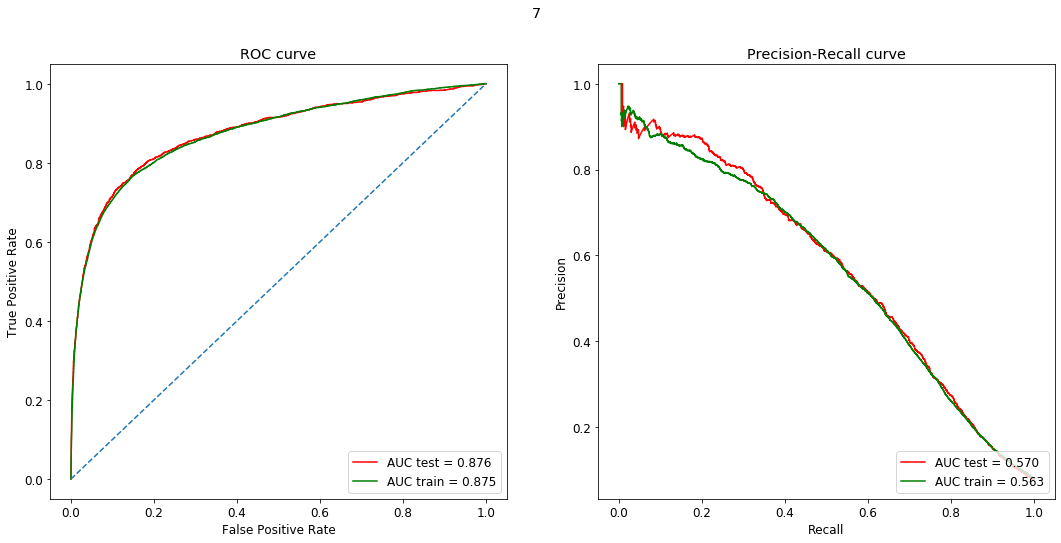

TRAIN SET: ROC AUC=0.875, PR AUC=0.563
TEST SET:  ROC AUC=0.876, PR AUC=0.570


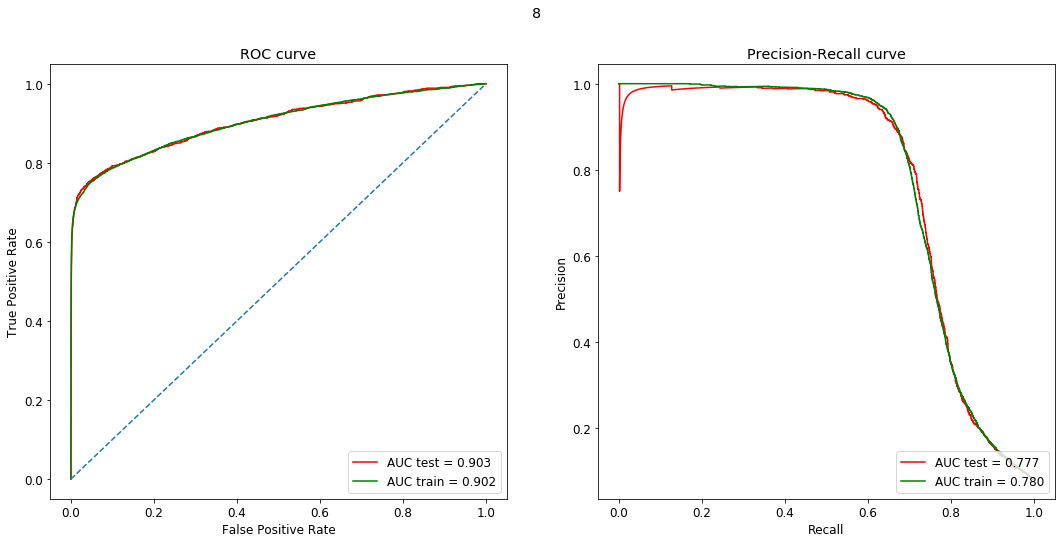

TRAIN SET: ROC AUC=0.902, PR AUC=0.780
TEST SET:  ROC AUC=0.903, PR AUC=0.777


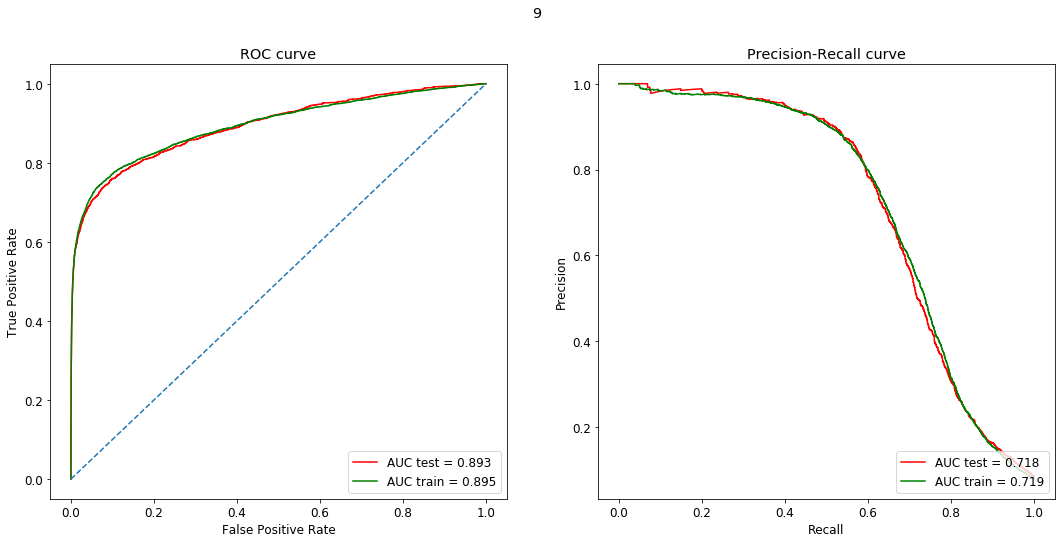

TRAIN SET: ROC AUC=0.895, PR AUC=0.719
TEST SET:  ROC AUC=0.893, PR AUC=0.718


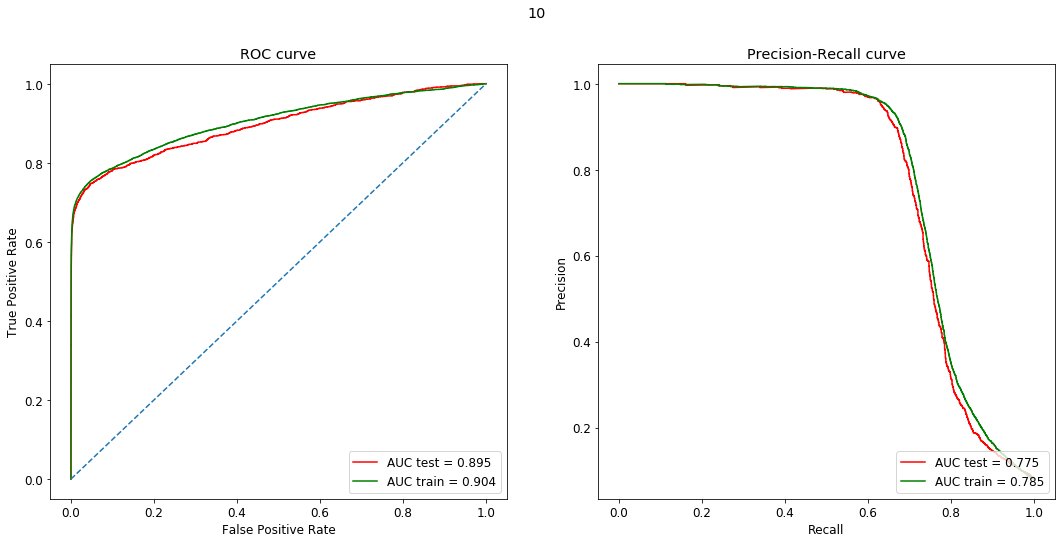

TRAIN SET: ROC AUC=0.904, PR AUC=0.785
TEST SET:  ROC AUC=0.895, PR AUC=0.775


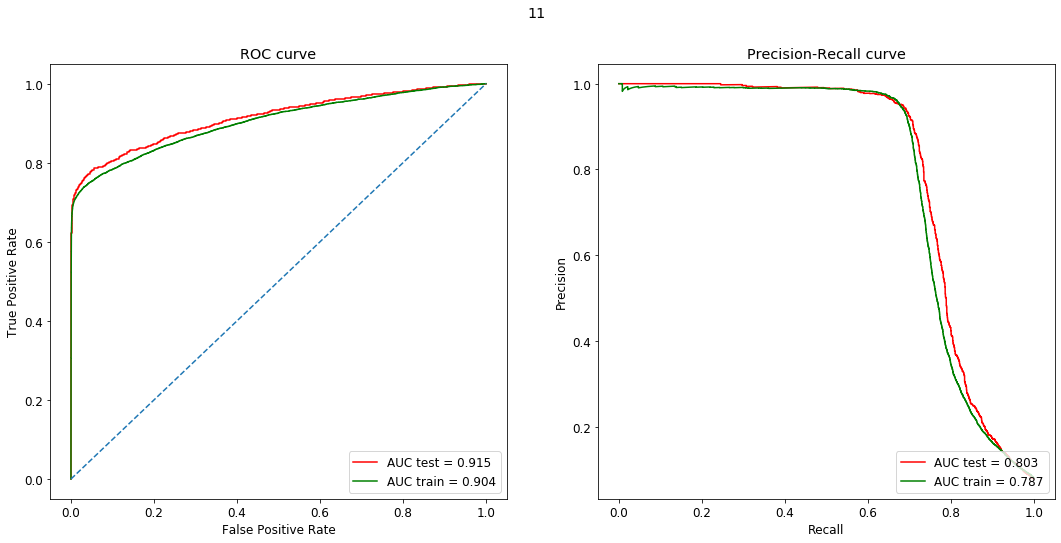

TRAIN SET: ROC AUC=0.904, PR AUC=0.787
TEST SET:  ROC AUC=0.915, PR AUC=0.803


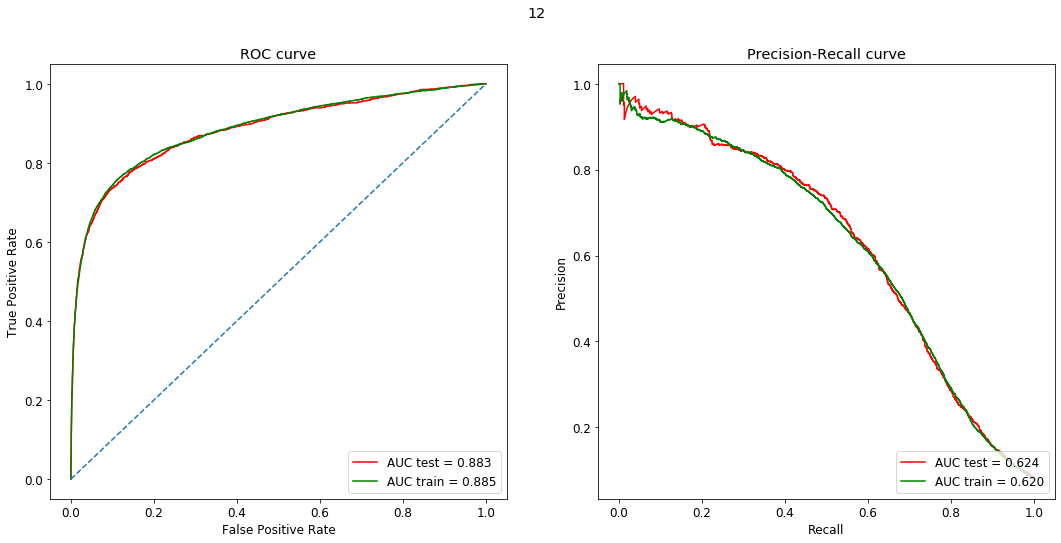

TRAIN SET: ROC AUC=0.885, PR AUC=0.620
TEST SET:  ROC AUC=0.883, PR AUC=0.624


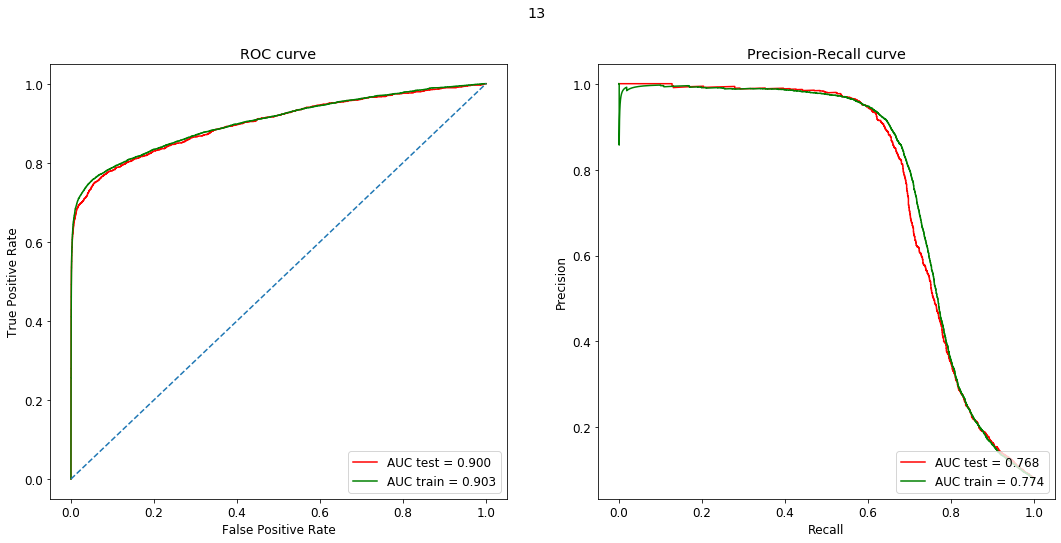

TRAIN SET: ROC AUC=0.903, PR AUC=0.774
TEST SET:  ROC AUC=0.900, PR AUC=0.768


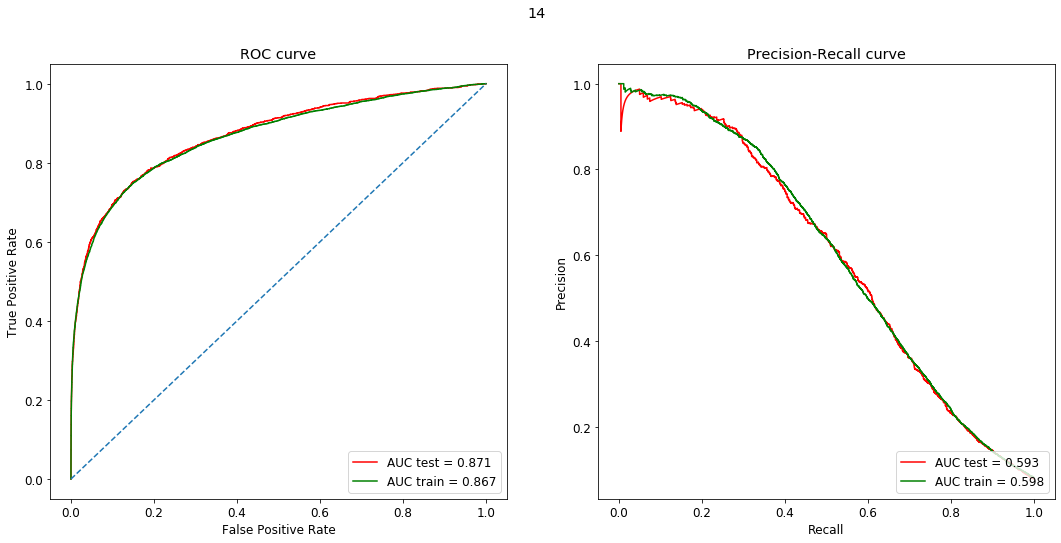

TRAIN SET: ROC AUC=0.867, PR AUC=0.598
TEST SET:  ROC AUC=0.871, PR AUC=0.593


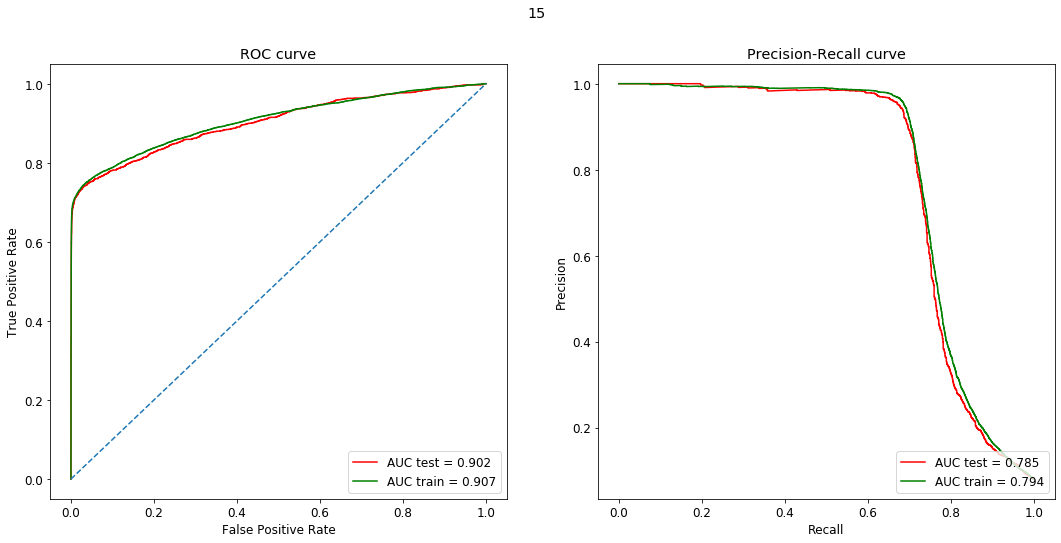

TRAIN SET: ROC AUC=0.907, PR AUC=0.794
TEST SET:  ROC AUC=0.902, PR AUC=0.785


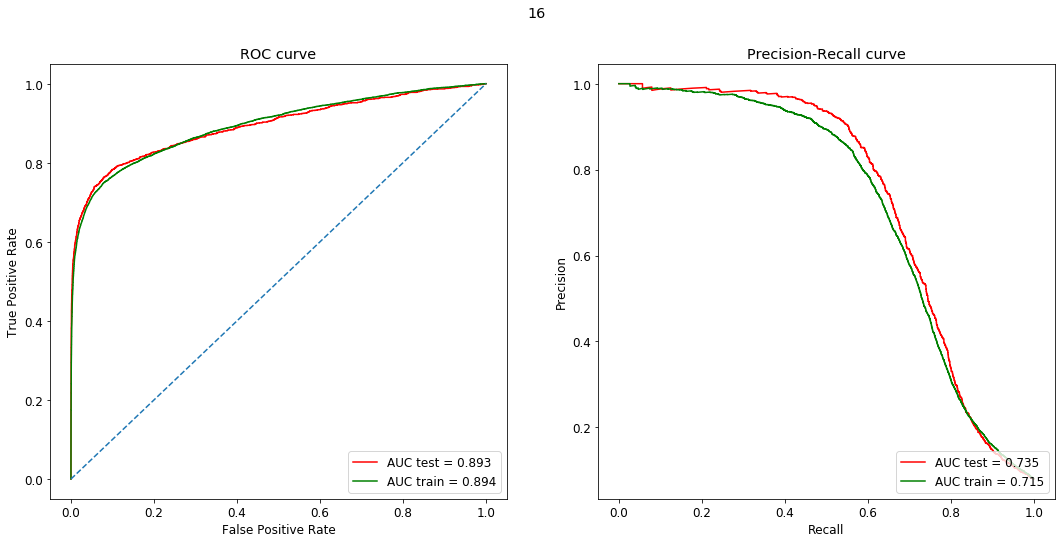

TRAIN SET: ROC AUC=0.894, PR AUC=0.715
TEST SET:  ROC AUC=0.893, PR AUC=0.735


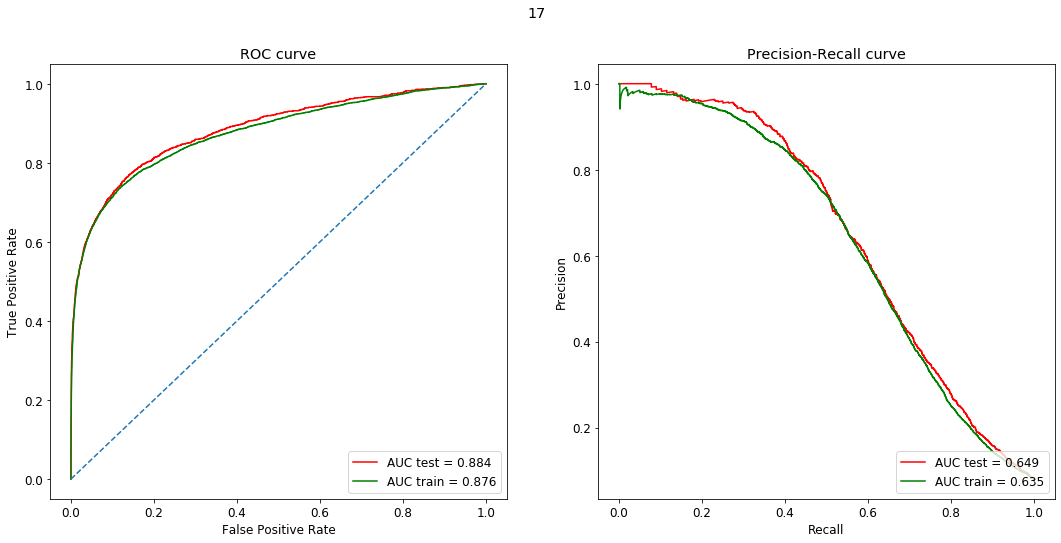

TRAIN SET: ROC AUC=0.876, PR AUC=0.635
TEST SET:  ROC AUC=0.884, PR AUC=0.649


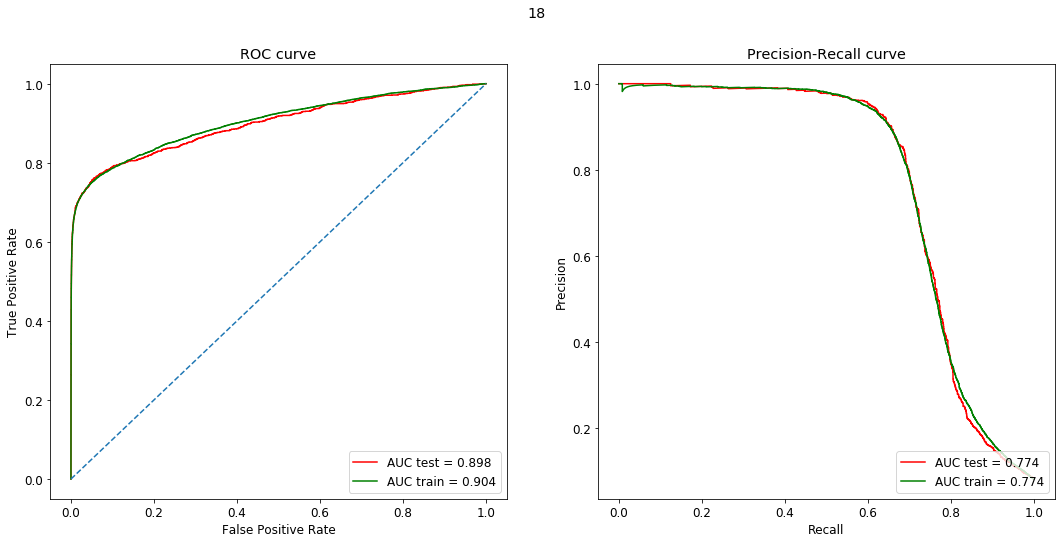

TRAIN SET: ROC AUC=0.904, PR AUC=0.774
TEST SET:  ROC AUC=0.898, PR AUC=0.774


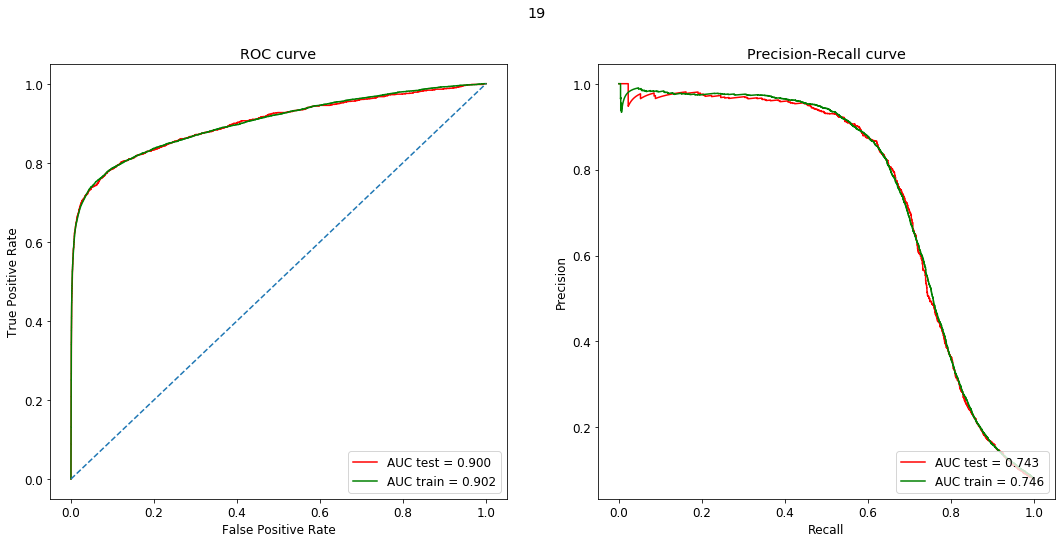

TRAIN SET: ROC AUC=0.902, PR AUC=0.746
TEST SET:  ROC AUC=0.900, PR AUC=0.743


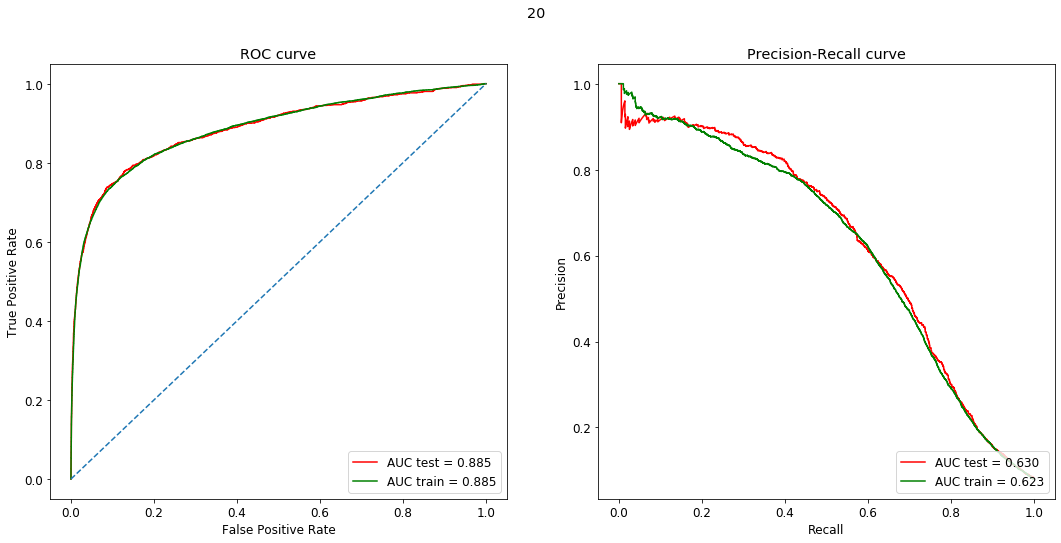

TRAIN SET: ROC AUC=0.885, PR AUC=0.623
TEST SET:  ROC AUC=0.885, PR AUC=0.630


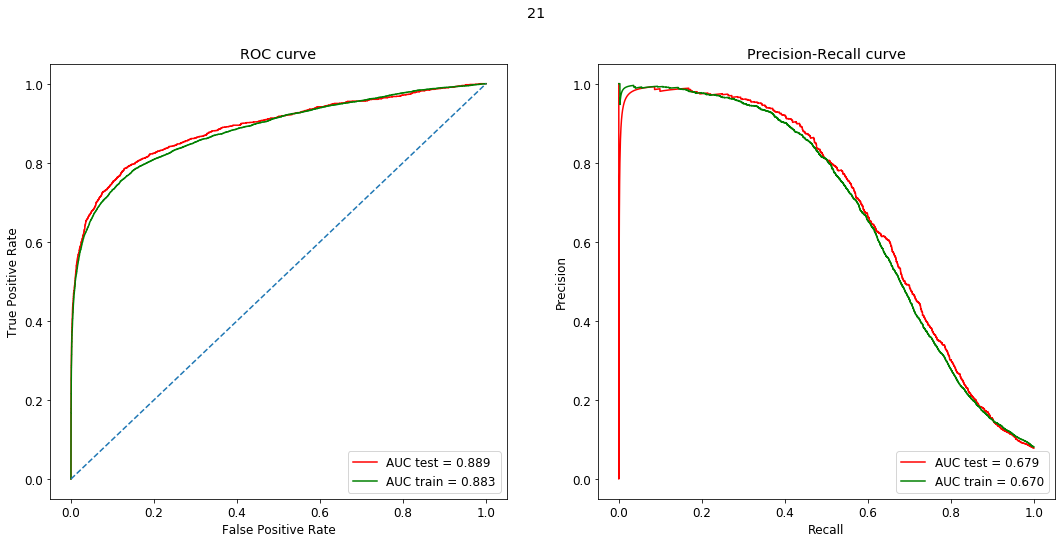

TRAIN SET: ROC AUC=0.883, PR AUC=0.670
TEST SET:  ROC AUC=0.889, PR AUC=0.679


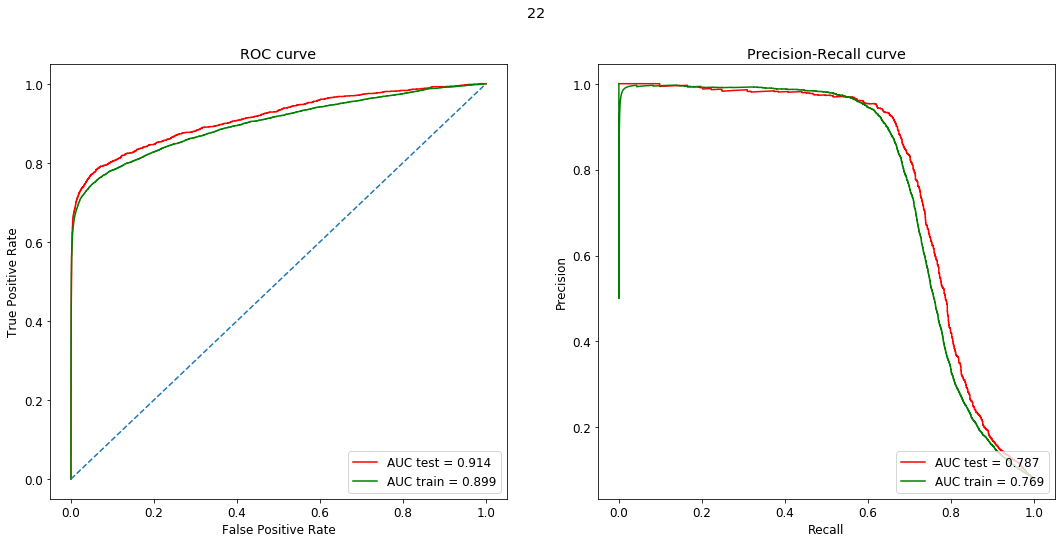

TRAIN SET: ROC AUC=0.899, PR AUC=0.769
TEST SET:  ROC AUC=0.914, PR AUC=0.787


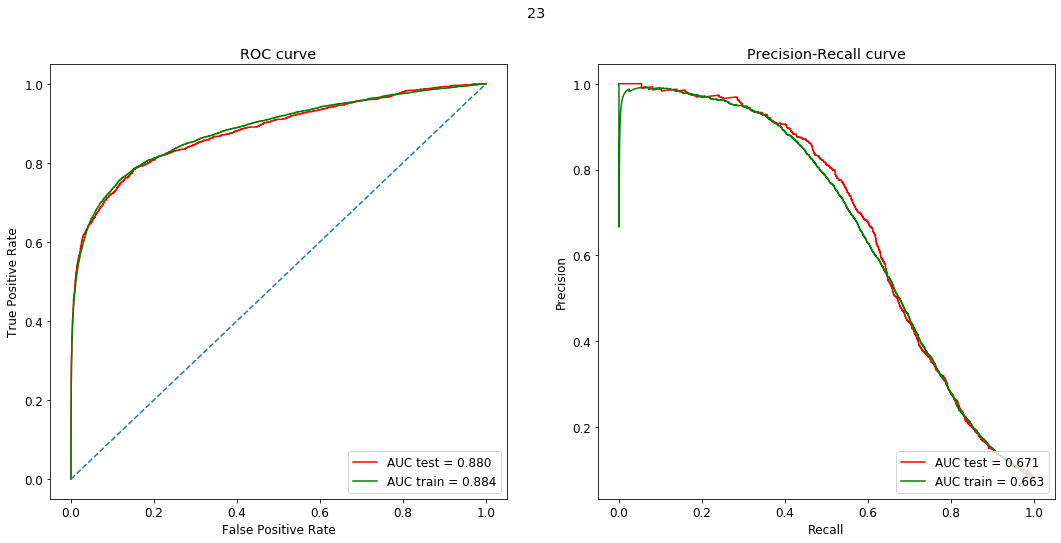

TRAIN SET: ROC AUC=0.884, PR AUC=0.663
TEST SET:  ROC AUC=0.880, PR AUC=0.671


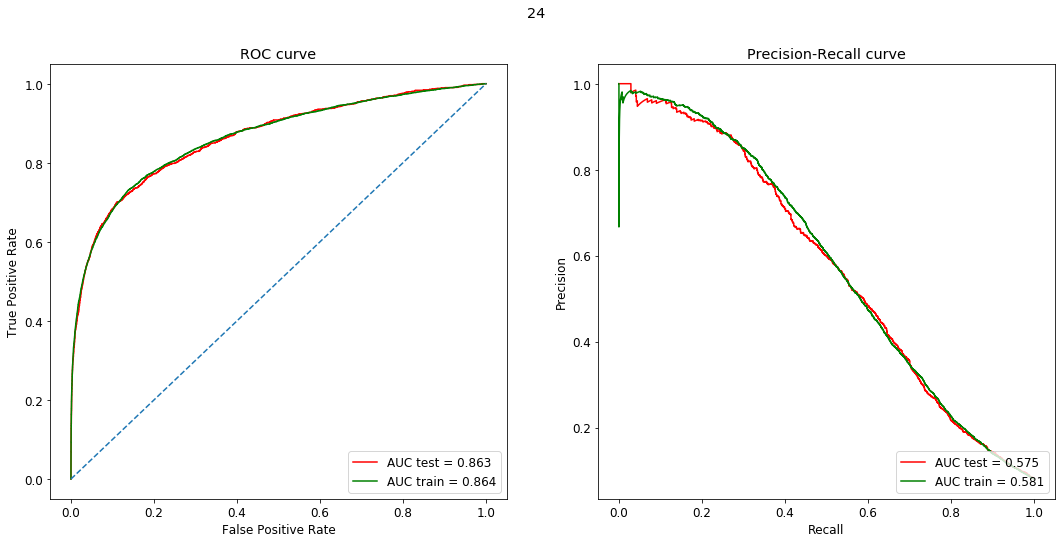

TRAIN SET: ROC AUC=0.864, PR AUC=0.581
TEST SET:  ROC AUC=0.863, PR AUC=0.575


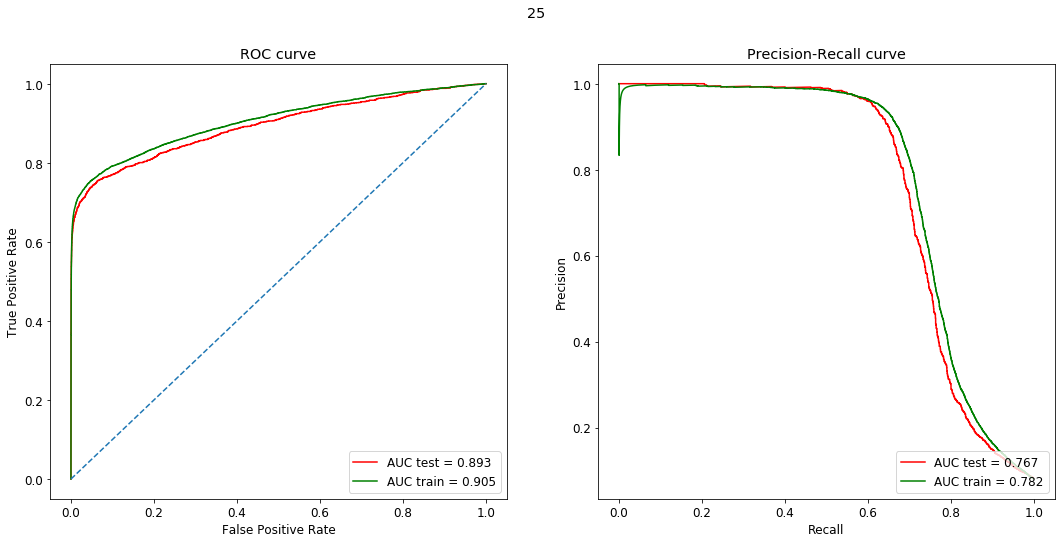

TRAIN SET: ROC AUC=0.905, PR AUC=0.782
TEST SET:  ROC AUC=0.893, PR AUC=0.767


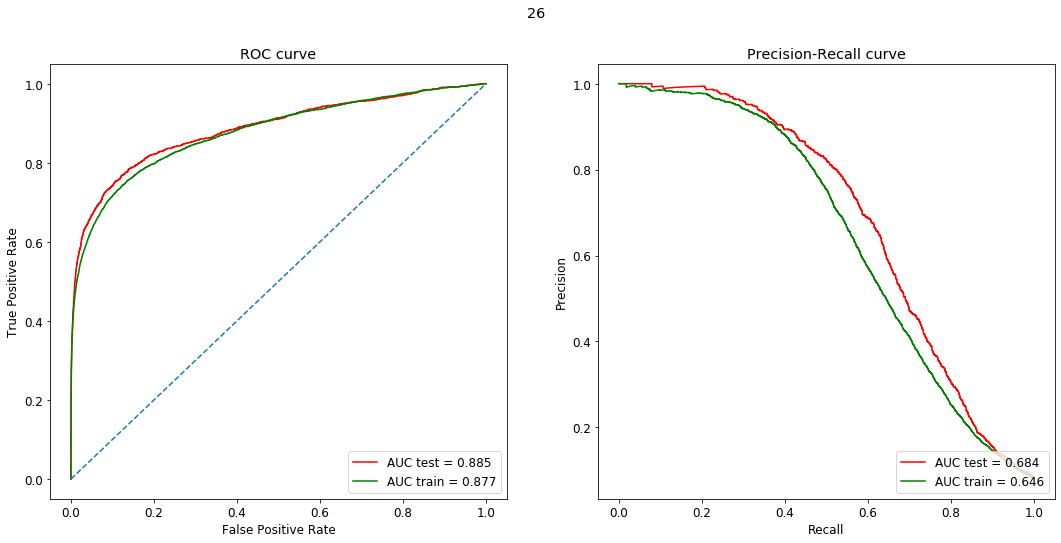

TRAIN SET: ROC AUC=0.877, PR AUC=0.646
TEST SET:  ROC AUC=0.885, PR AUC=0.684


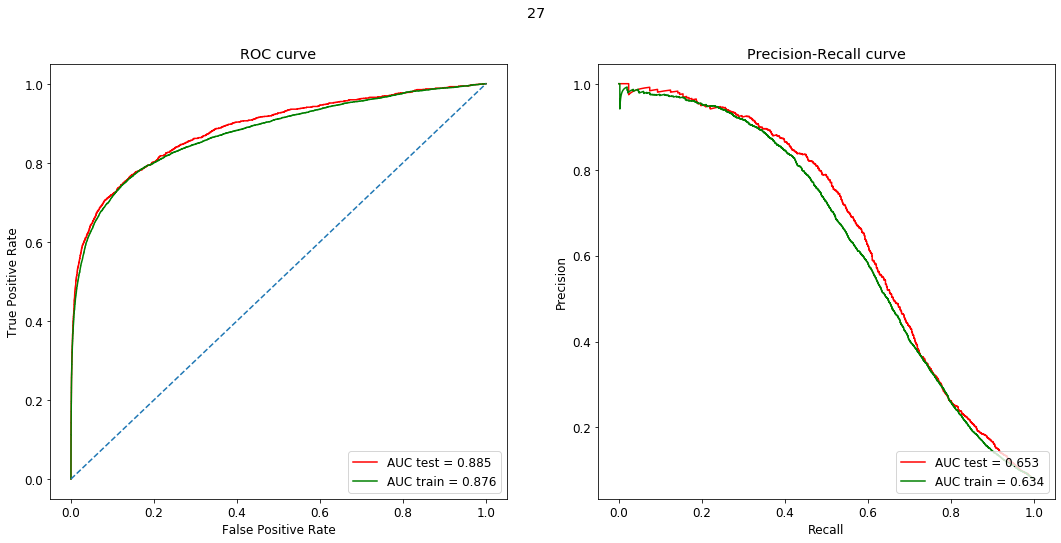

TRAIN SET: ROC AUC=0.876, PR AUC=0.634
TEST SET:  ROC AUC=0.885, PR AUC=0.653


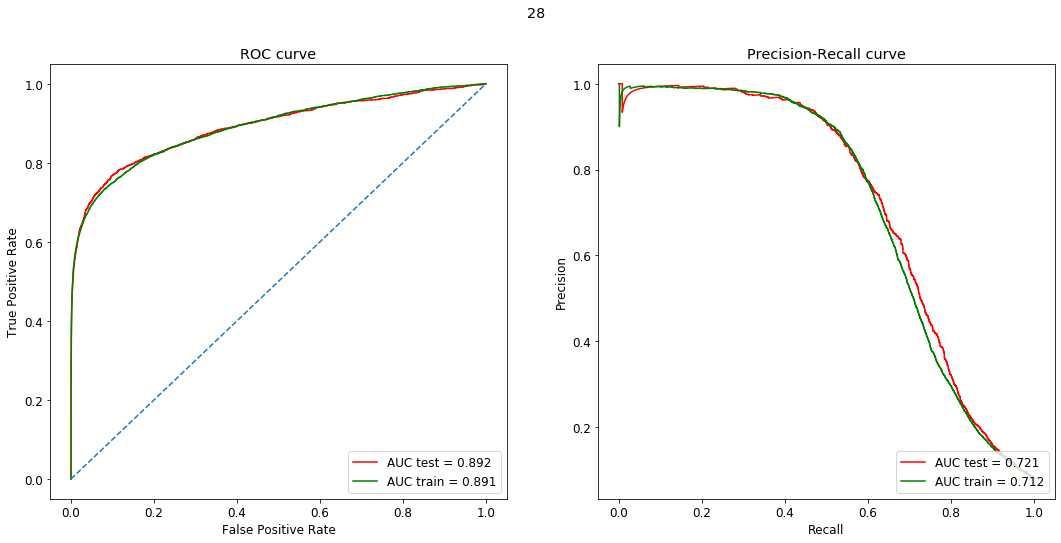

TRAIN SET: ROC AUC=0.891, PR AUC=0.712
TEST SET:  ROC AUC=0.892, PR AUC=0.721


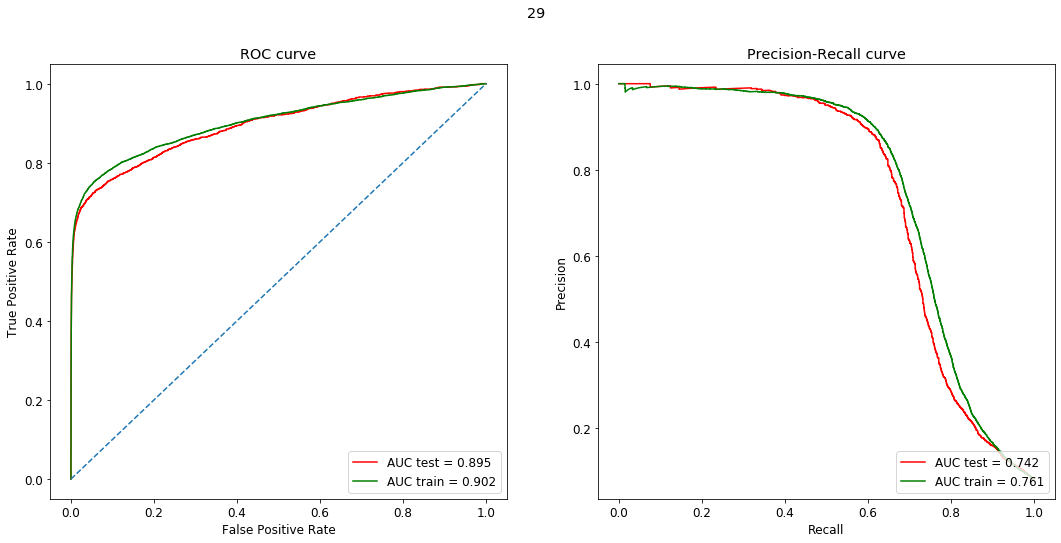

TRAIN SET: ROC AUC=0.902, PR AUC=0.761
TEST SET:  ROC AUC=0.895, PR AUC=0.742


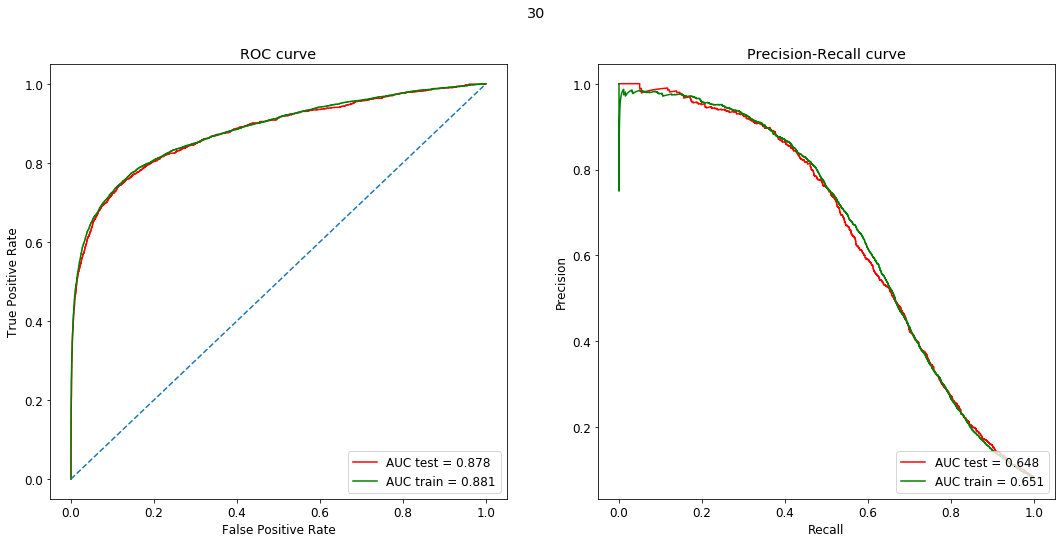

TRAIN SET: ROC AUC=0.881, PR AUC=0.651
TEST SET:  ROC AUC=0.878, PR AUC=0.648


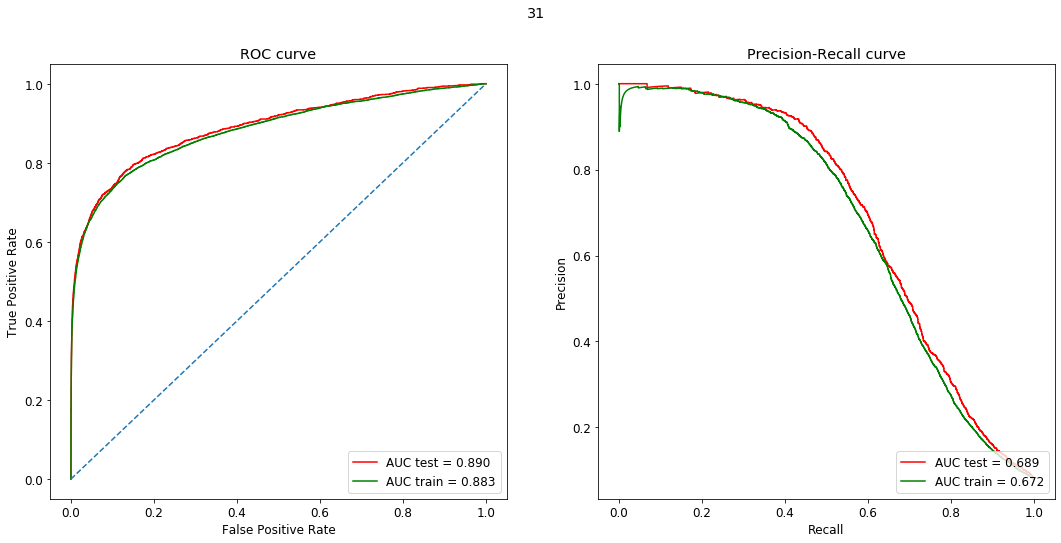

TRAIN SET: ROC AUC=0.883, PR AUC=0.672
TEST SET:  ROC AUC=0.890, PR AUC=0.689


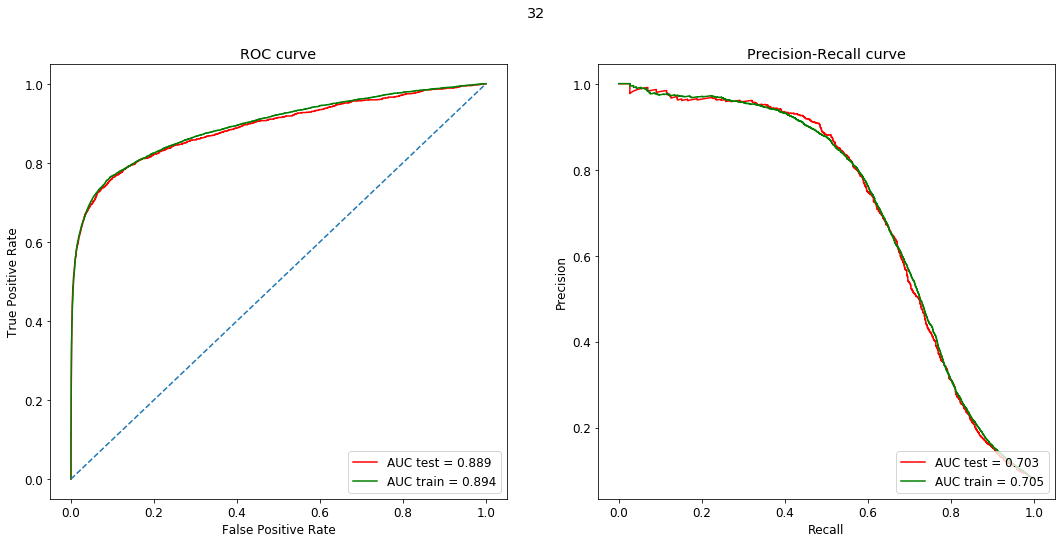

TRAIN SET: ROC AUC=0.894, PR AUC=0.705
TEST SET:  ROC AUC=0.889, PR AUC=0.703


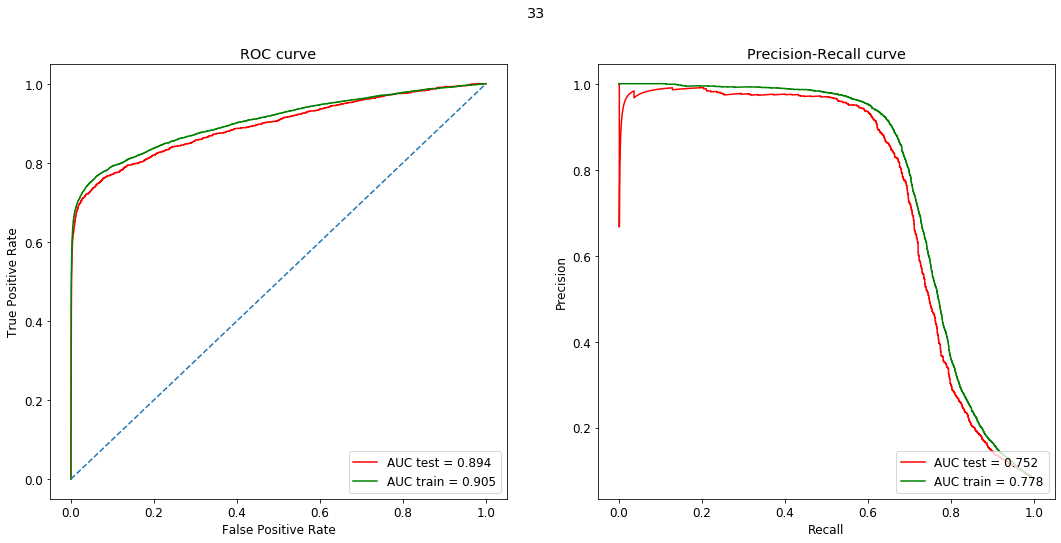

TRAIN SET: ROC AUC=0.905, PR AUC=0.778
TEST SET:  ROC AUC=0.894, PR AUC=0.752


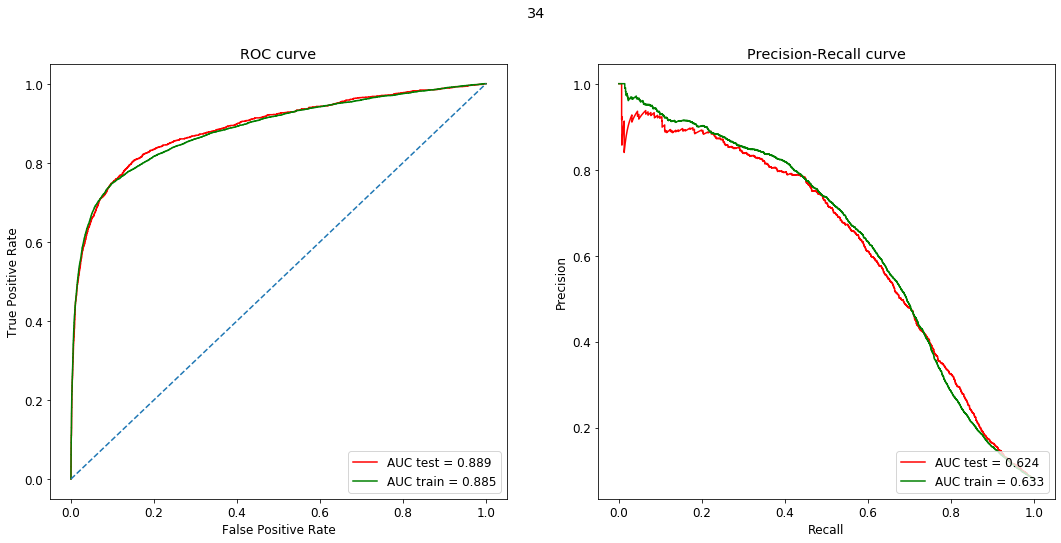

TRAIN SET: ROC AUC=0.885, PR AUC=0.633
TEST SET:  ROC AUC=0.889, PR AUC=0.624


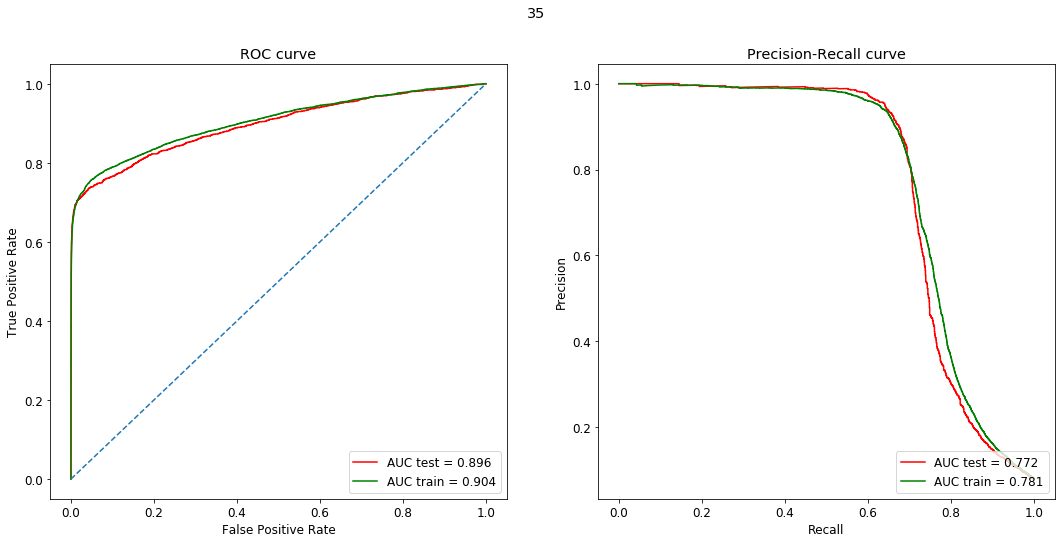

TRAIN SET: ROC AUC=0.904, PR AUC=0.781
TEST SET:  ROC AUC=0.896, PR AUC=0.772


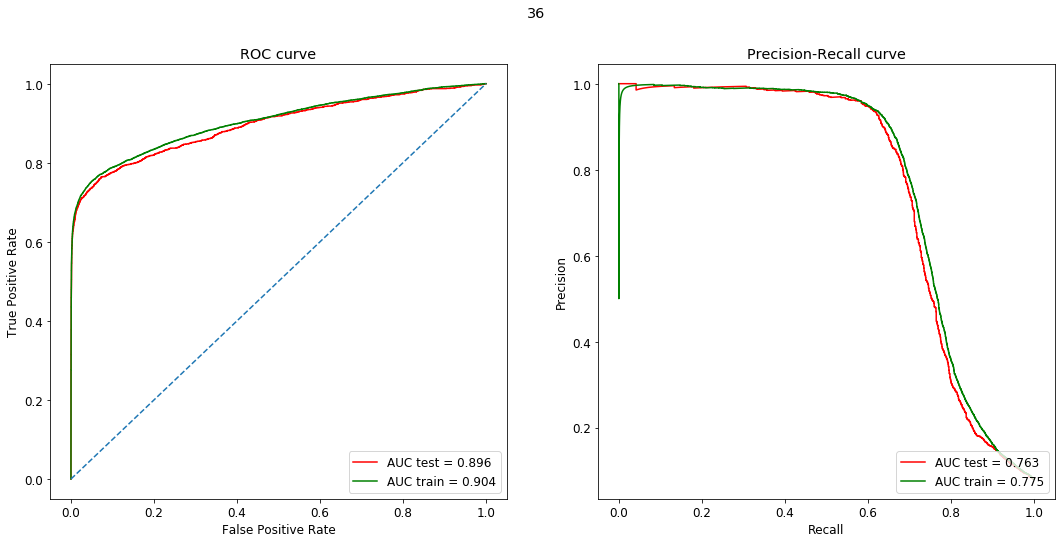

TRAIN SET: ROC AUC=0.904, PR AUC=0.775
TEST SET:  ROC AUC=0.896, PR AUC=0.763


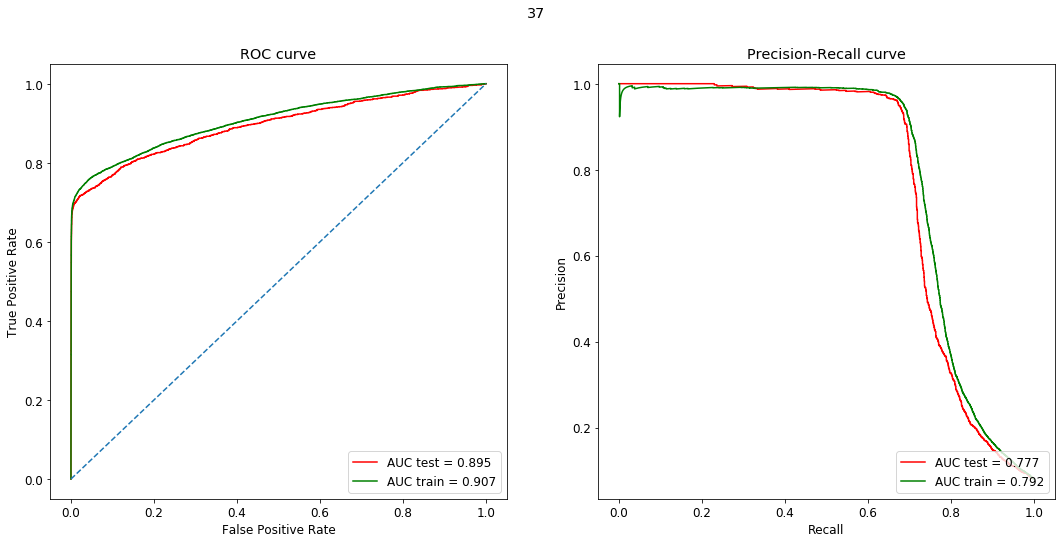

TRAIN SET: ROC AUC=0.907, PR AUC=0.792
TEST SET:  ROC AUC=0.895, PR AUC=0.777


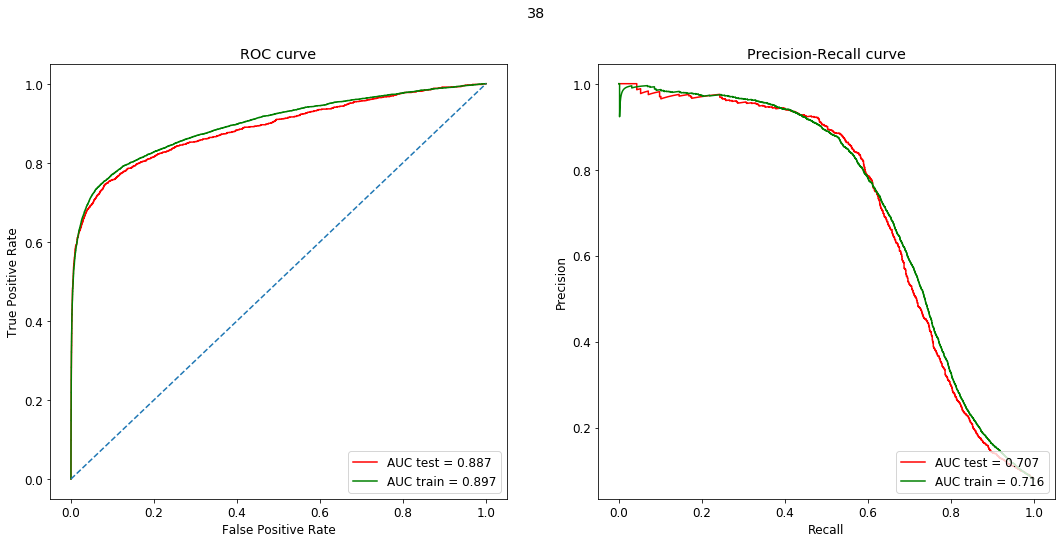

TRAIN SET: ROC AUC=0.897, PR AUC=0.716
TEST SET:  ROC AUC=0.887, PR AUC=0.707


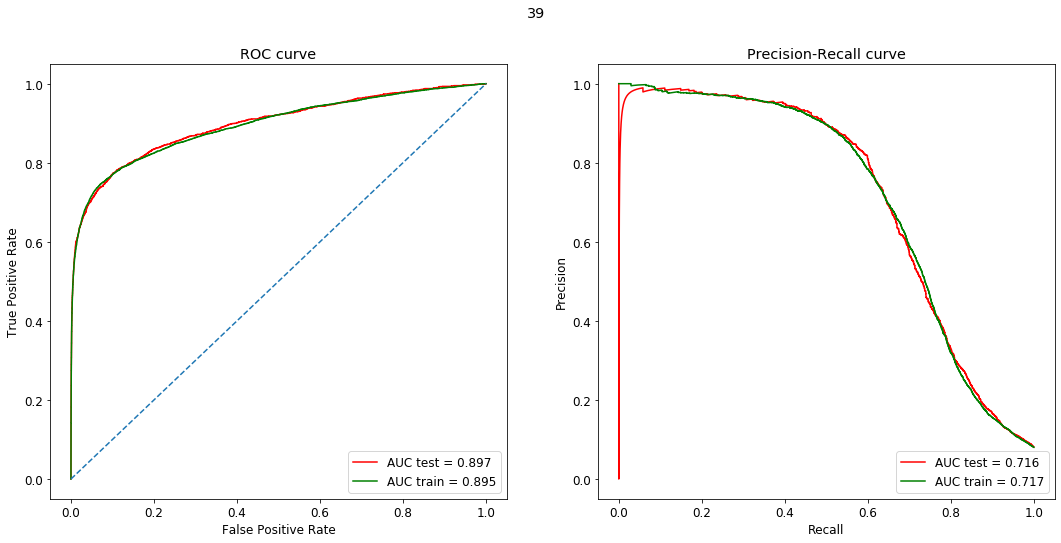

TRAIN SET: ROC AUC=0.895, PR AUC=0.717
TEST SET:  ROC AUC=0.897, PR AUC=0.716


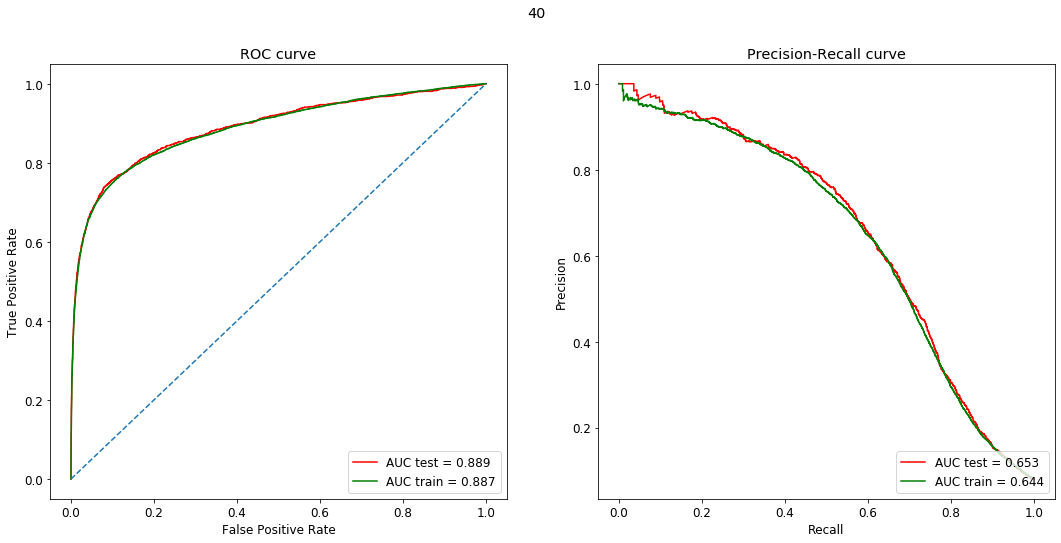

TRAIN SET: ROC AUC=0.887, PR AUC=0.644
TEST SET:  ROC AUC=0.889, PR AUC=0.653


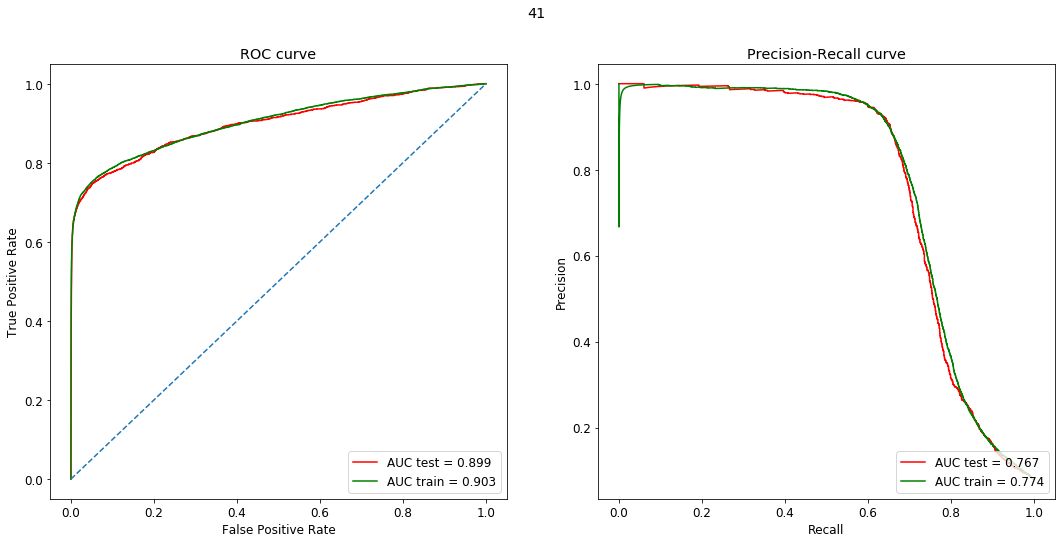

TRAIN SET: ROC AUC=0.903, PR AUC=0.774
TEST SET:  ROC AUC=0.899, PR AUC=0.767


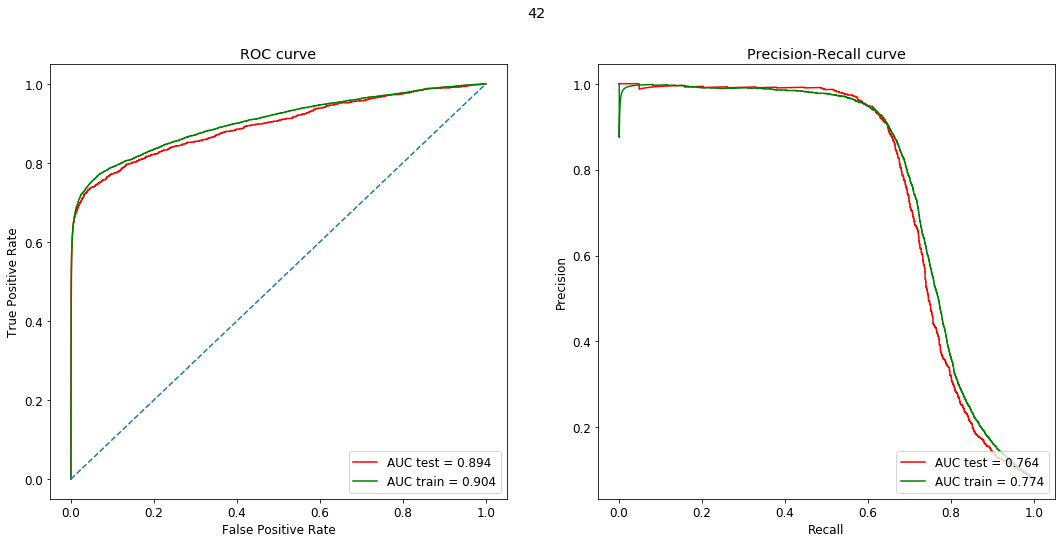

TRAIN SET: ROC AUC=0.904, PR AUC=0.774
TEST SET:  ROC AUC=0.894, PR AUC=0.764


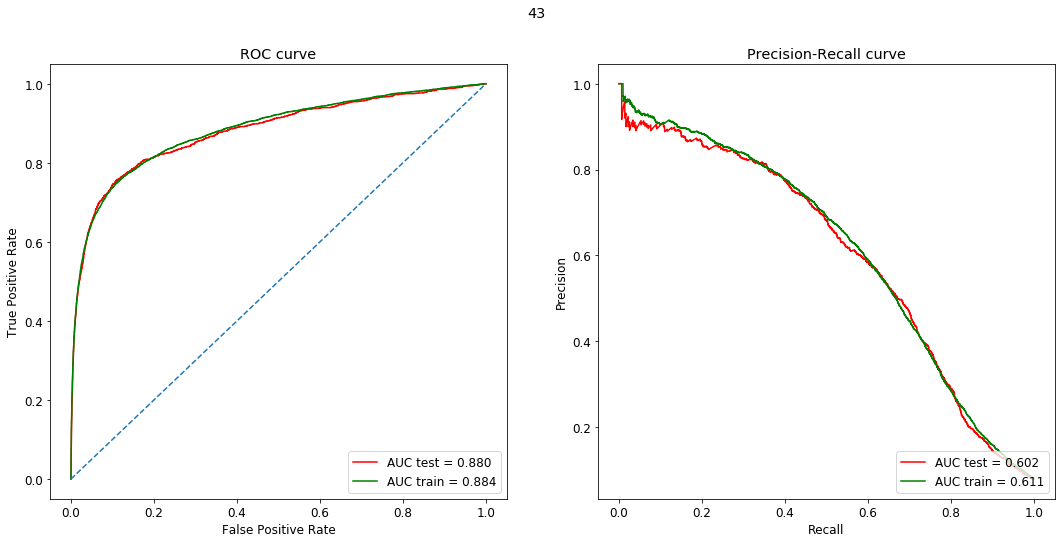

TRAIN SET: ROC AUC=0.884, PR AUC=0.611
TEST SET:  ROC AUC=0.880, PR AUC=0.602


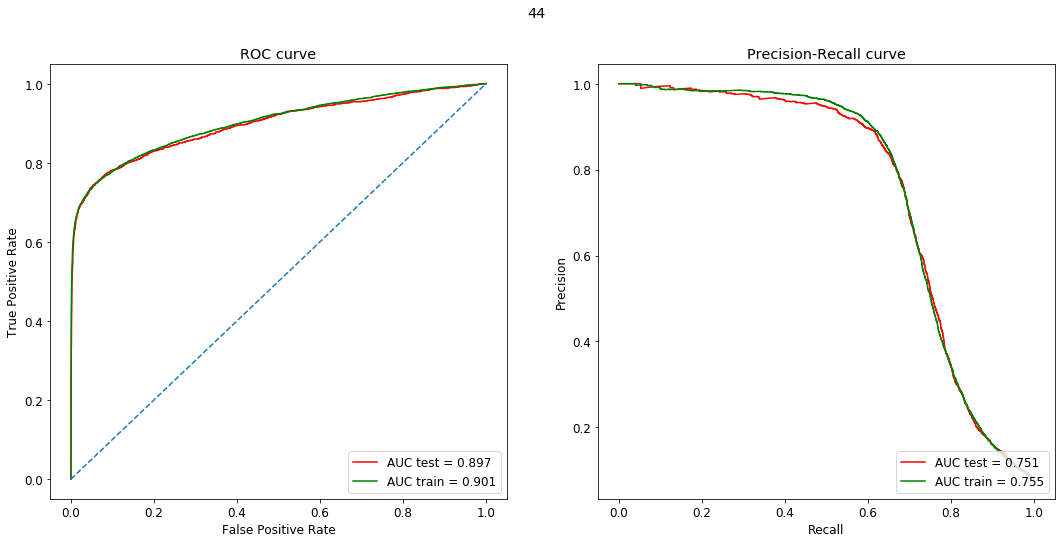

TRAIN SET: ROC AUC=0.901, PR AUC=0.755
TEST SET:  ROC AUC=0.897, PR AUC=0.751


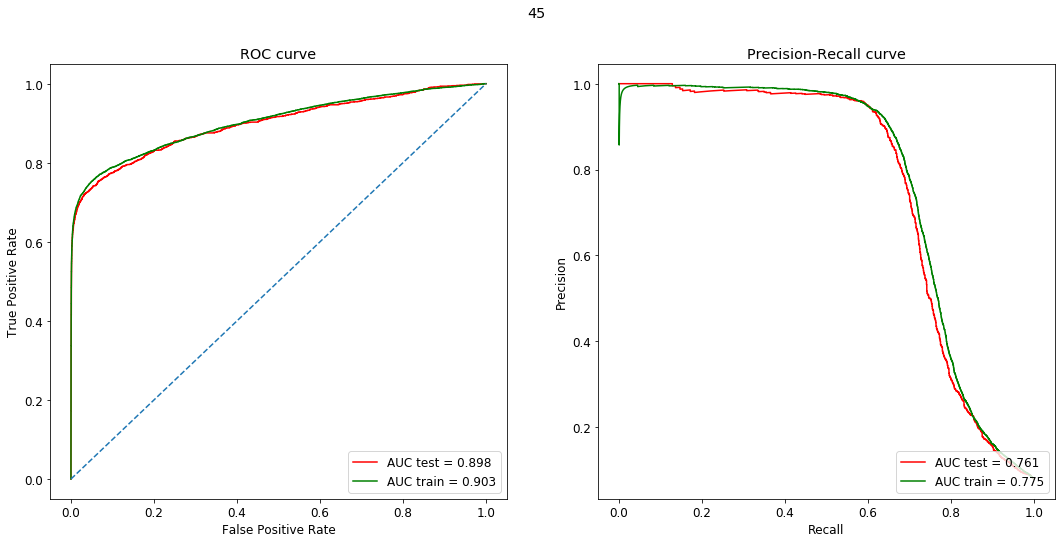

TRAIN SET: ROC AUC=0.903, PR AUC=0.775
TEST SET:  ROC AUC=0.898, PR AUC=0.761


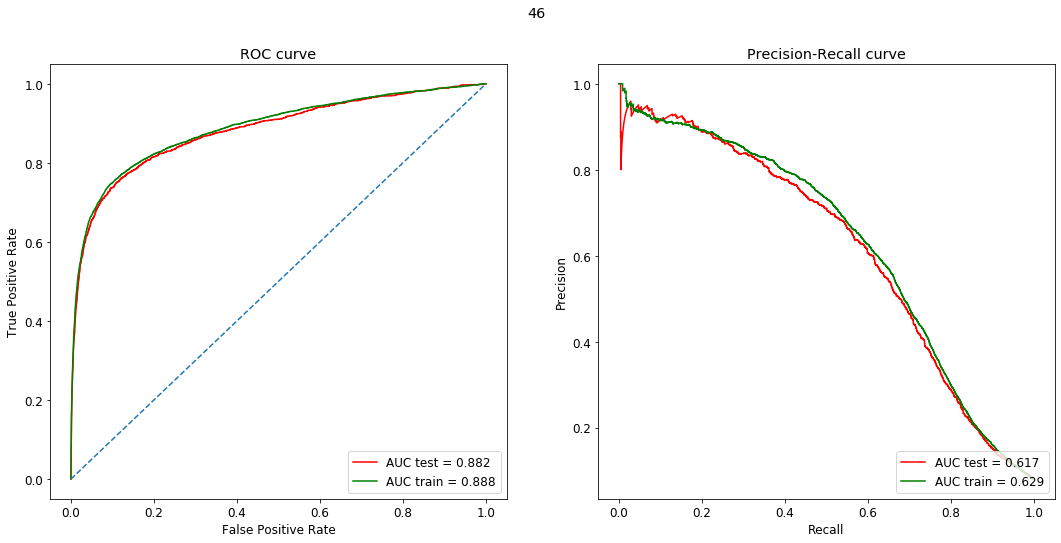

TRAIN SET: ROC AUC=0.888, PR AUC=0.629
TEST SET:  ROC AUC=0.882, PR AUC=0.617


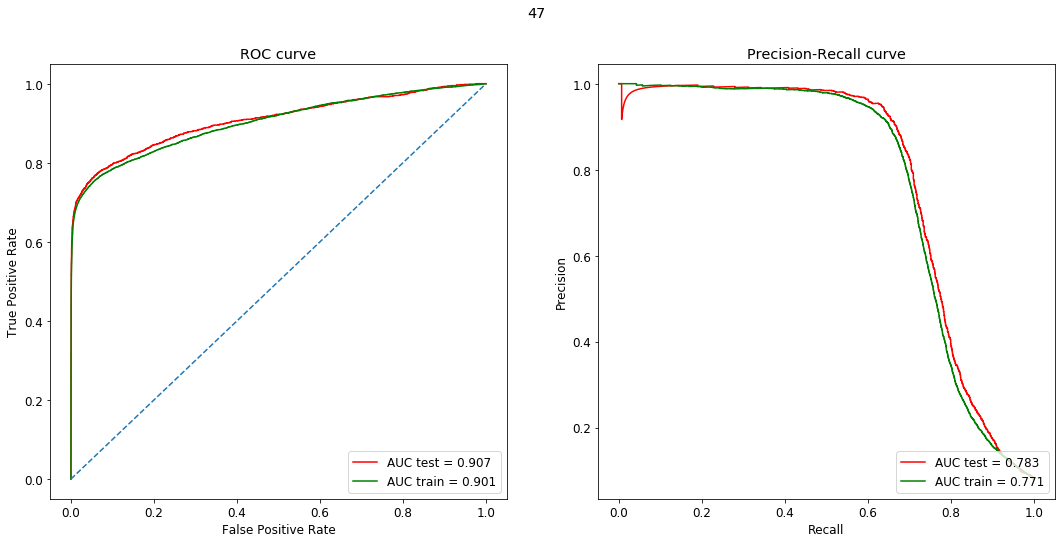

TRAIN SET: ROC AUC=0.901, PR AUC=0.771
TEST SET:  ROC AUC=0.907, PR AUC=0.783


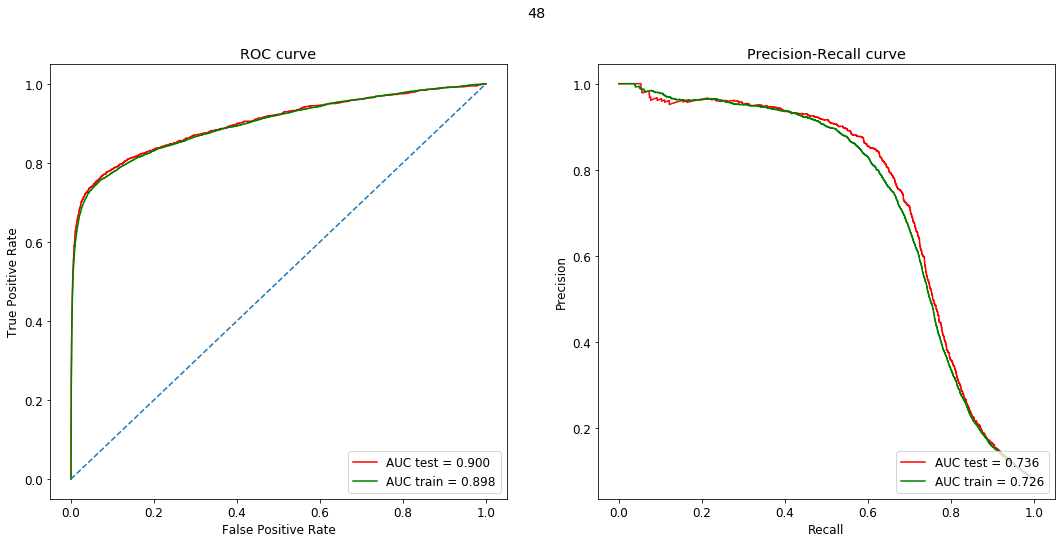

TRAIN SET: ROC AUC=0.898, PR AUC=0.726
TEST SET:  ROC AUC=0.900, PR AUC=0.736


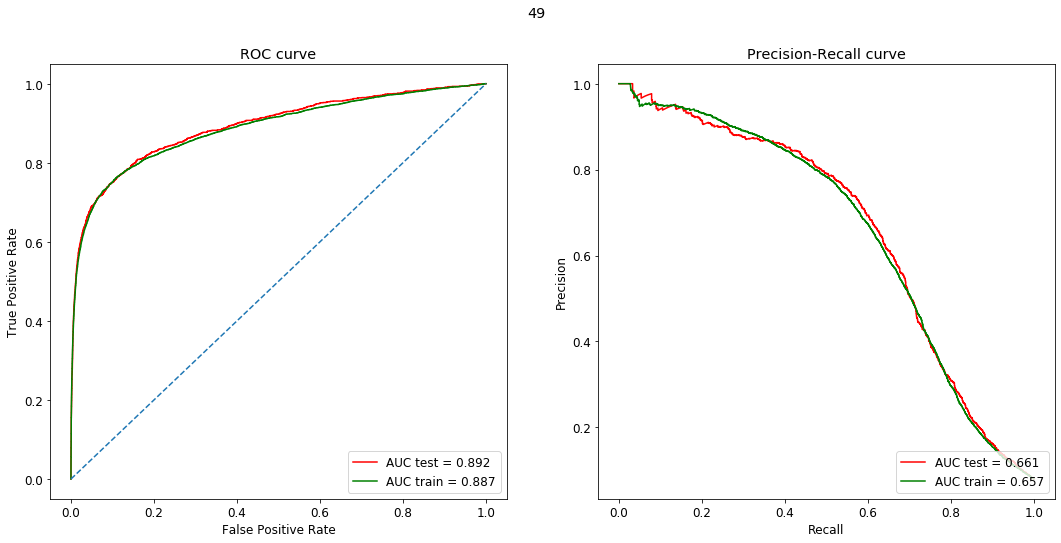

TRAIN SET: ROC AUC=0.887, PR AUC=0.657
TEST SET:  ROC AUC=0.892, PR AUC=0.661


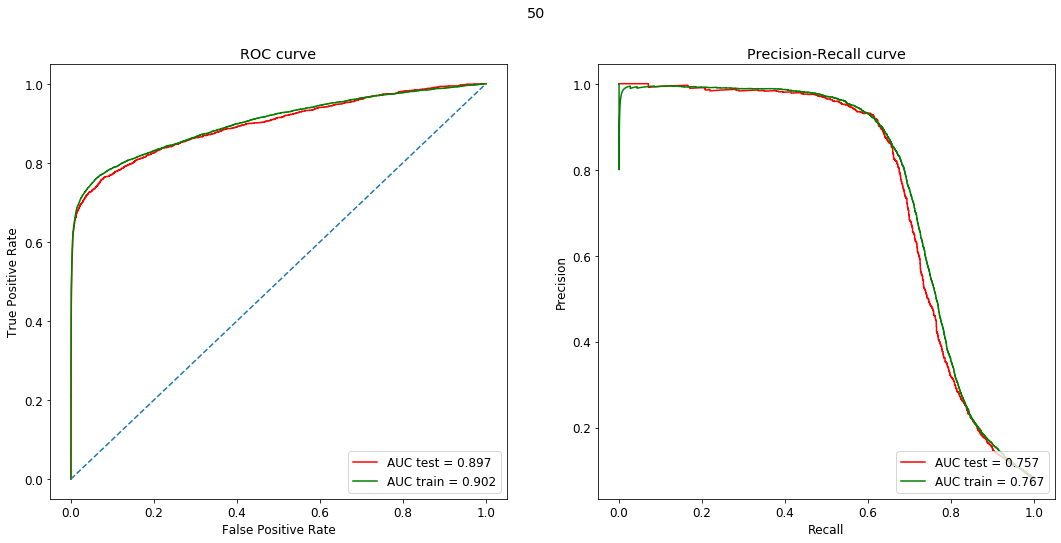

TRAIN SET: ROC AUC=0.902, PR AUC=0.767
TEST SET:  ROC AUC=0.897, PR AUC=0.757


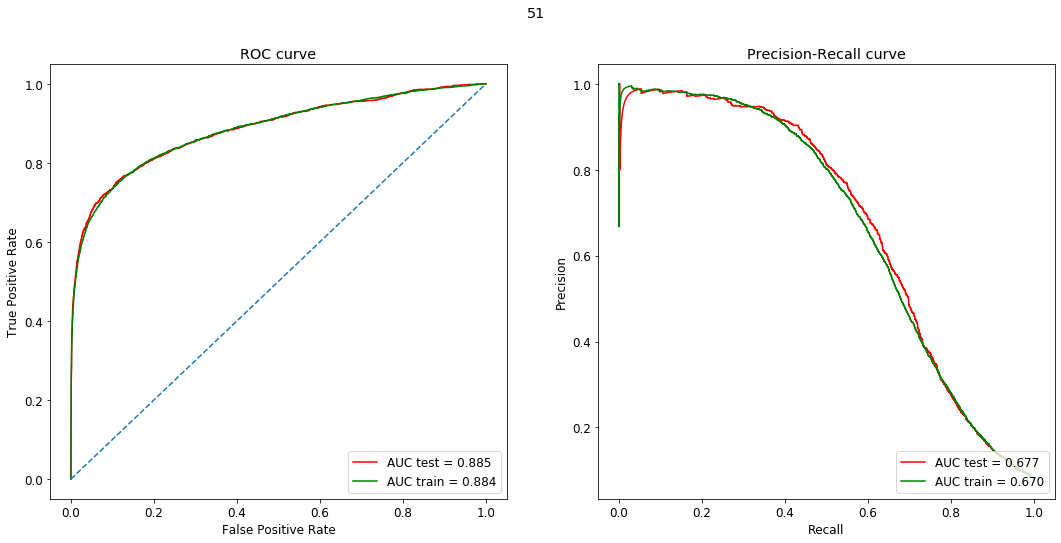

TRAIN SET: ROC AUC=0.884, PR AUC=0.670
TEST SET:  ROC AUC=0.885, PR AUC=0.677


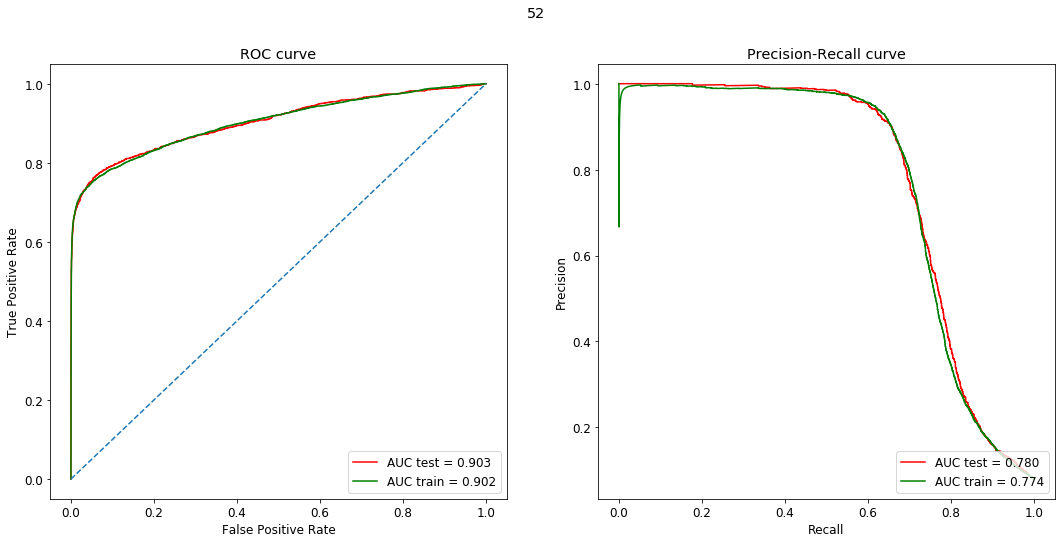

TRAIN SET: ROC AUC=0.902, PR AUC=0.774
TEST SET:  ROC AUC=0.903, PR AUC=0.780


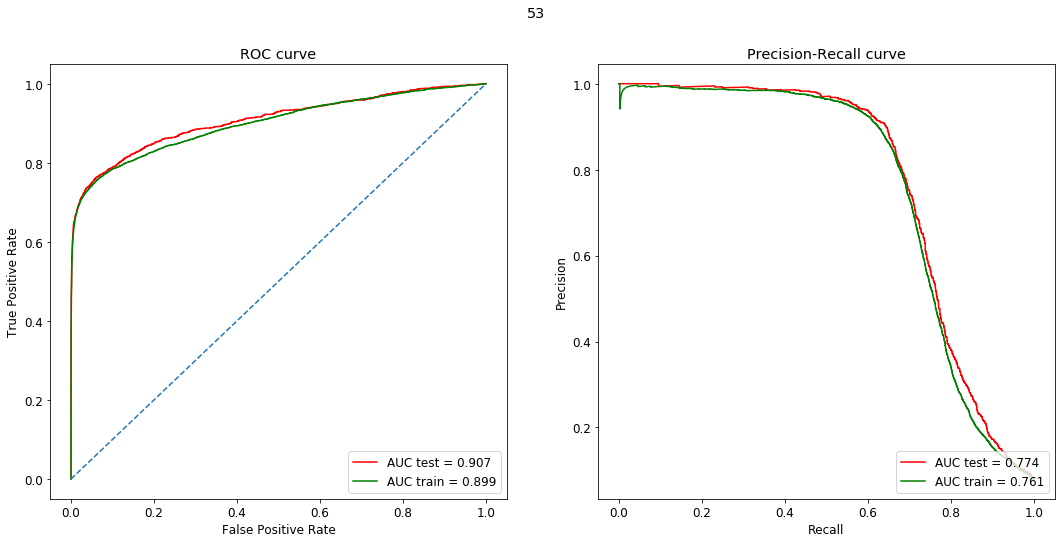

TRAIN SET: ROC AUC=0.899, PR AUC=0.761
TEST SET:  ROC AUC=0.907, PR AUC=0.774


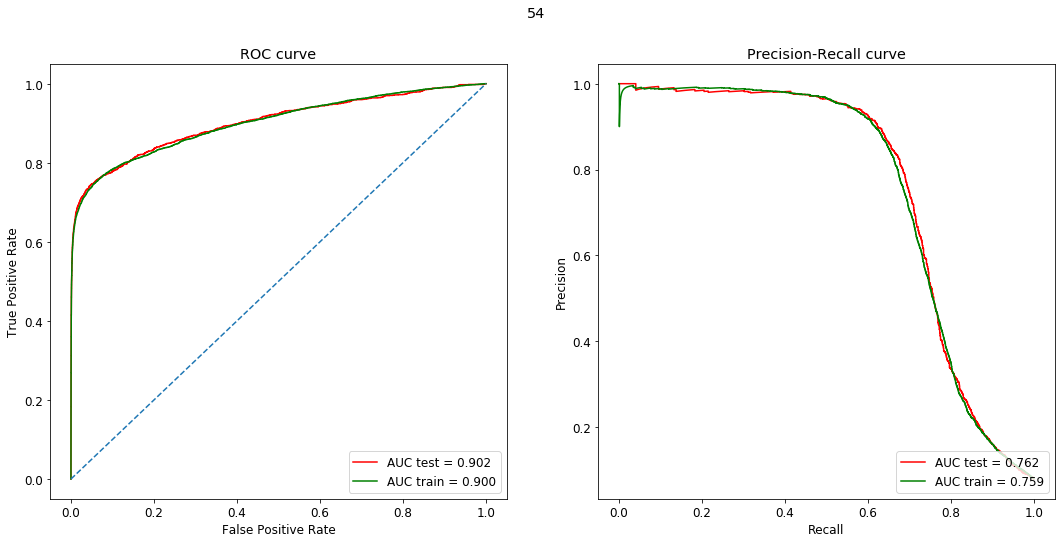

TRAIN SET: ROC AUC=0.900, PR AUC=0.759
TEST SET:  ROC AUC=0.902, PR AUC=0.762


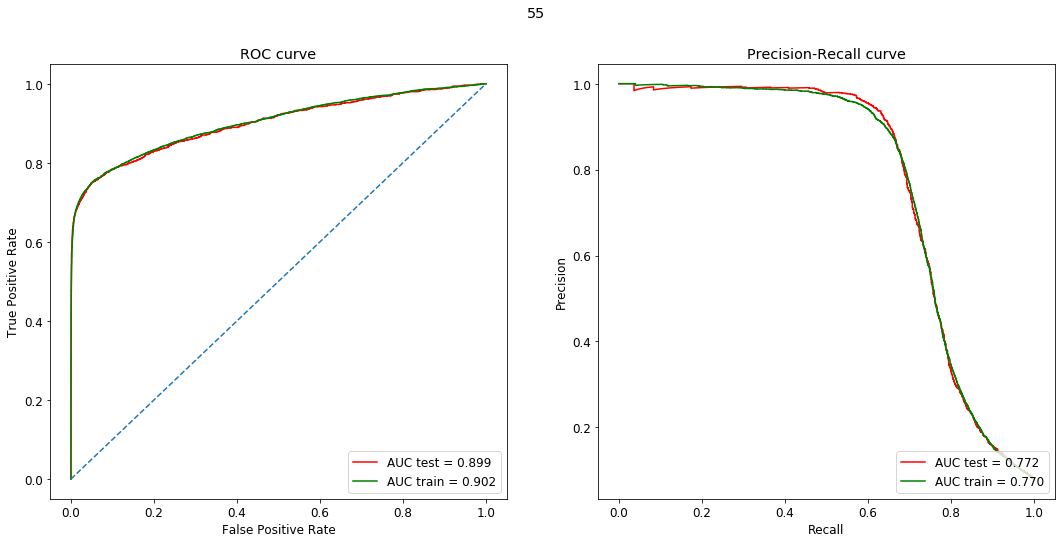

TRAIN SET: ROC AUC=0.902, PR AUC=0.770
TEST SET:  ROC AUC=0.899, PR AUC=0.772


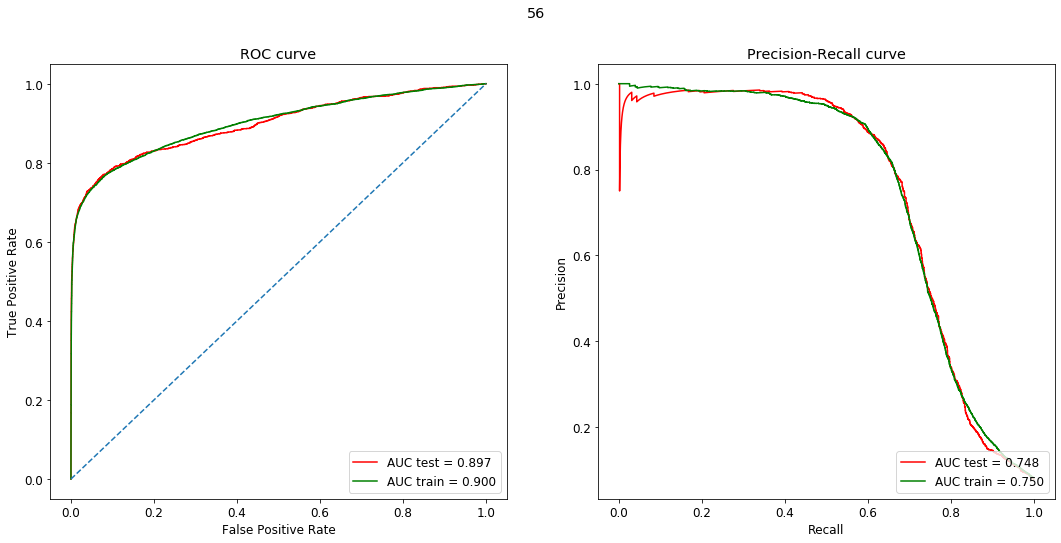

TRAIN SET: ROC AUC=0.900, PR AUC=0.750
TEST SET:  ROC AUC=0.897, PR AUC=0.748


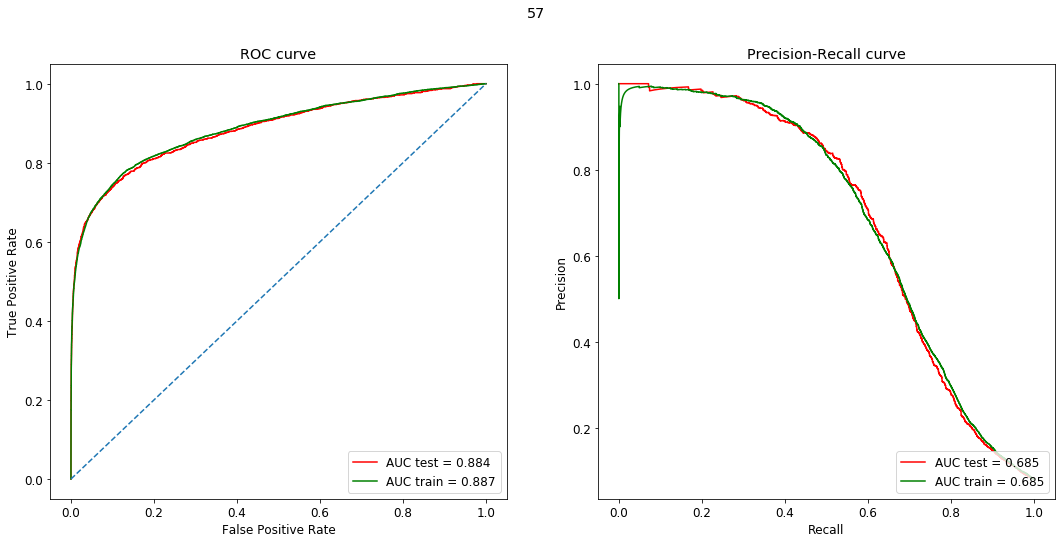

TRAIN SET: ROC AUC=0.887, PR AUC=0.685
TEST SET:  ROC AUC=0.884, PR AUC=0.685


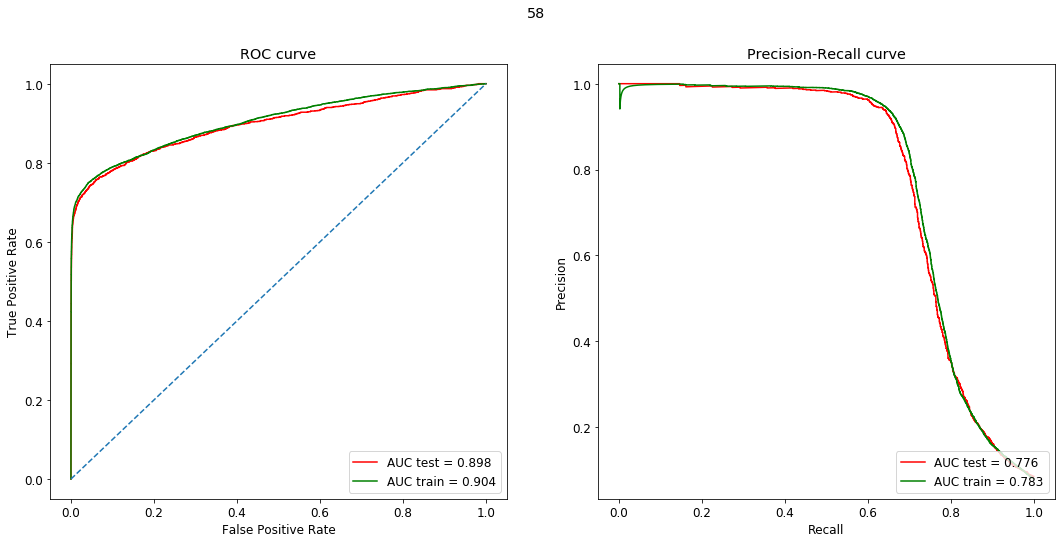

TRAIN SET: ROC AUC=0.904, PR AUC=0.783
TEST SET:  ROC AUC=0.898, PR AUC=0.776


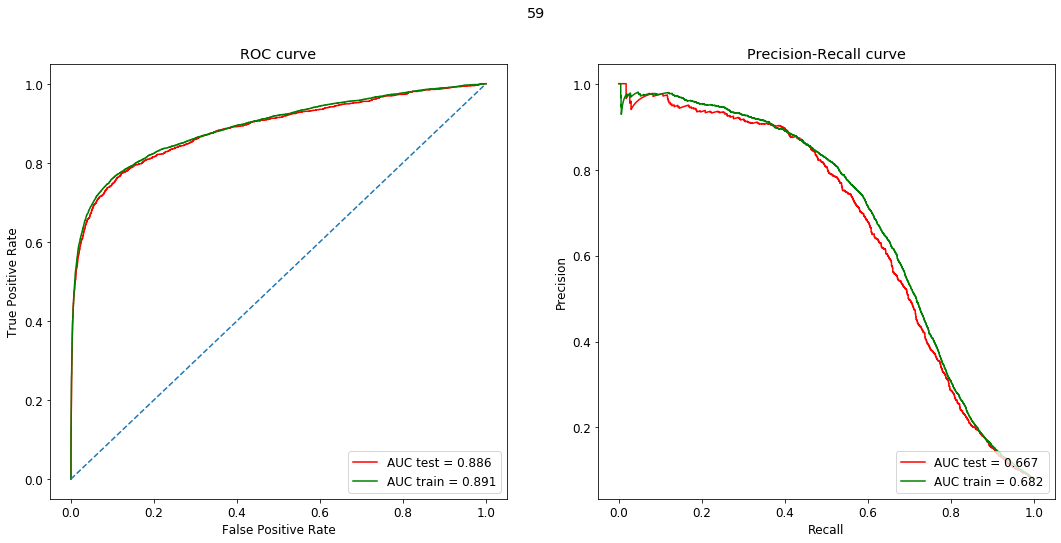

TRAIN SET: ROC AUC=0.891, PR AUC=0.682
TEST SET:  ROC AUC=0.886, PR AUC=0.667


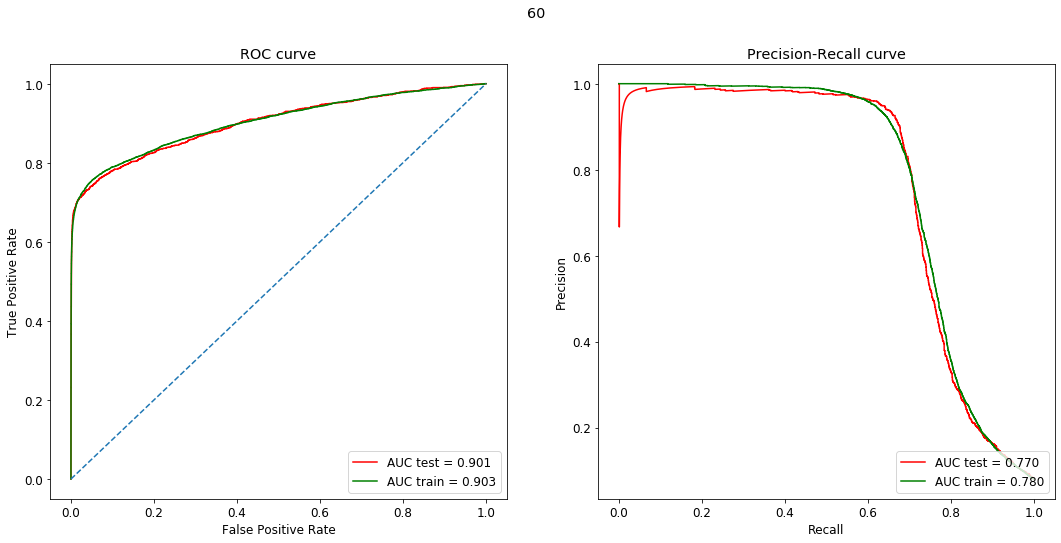

TRAIN SET: ROC AUC=0.903, PR AUC=0.780
TEST SET:  ROC AUC=0.901, PR AUC=0.770


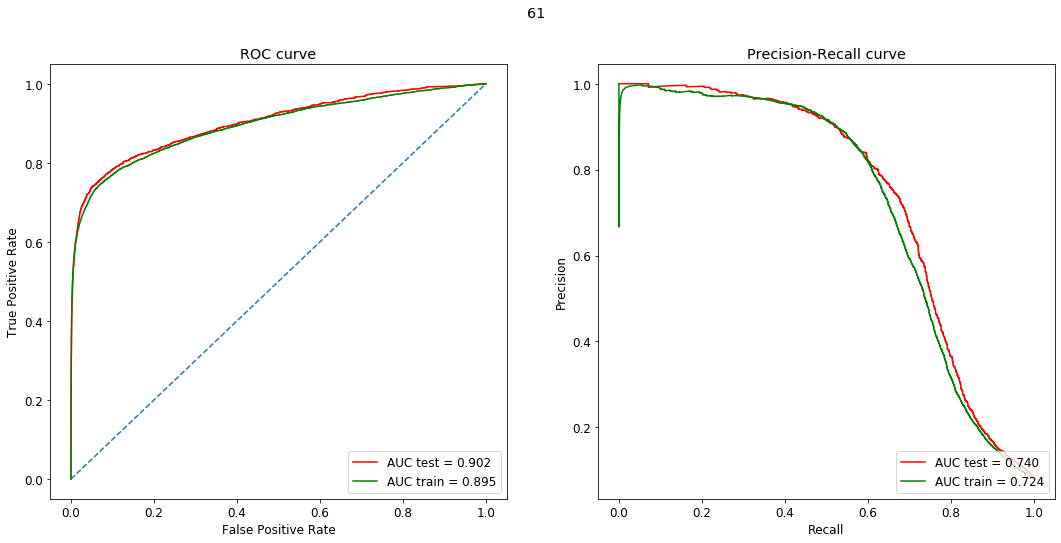

TRAIN SET: ROC AUC=0.895, PR AUC=0.724
TEST SET:  ROC AUC=0.902, PR AUC=0.740


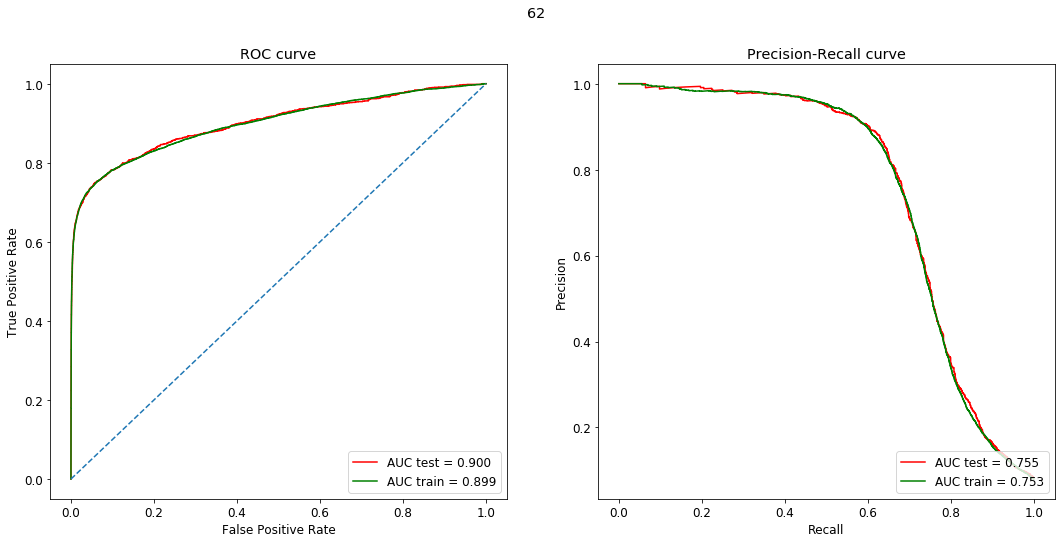

TRAIN SET: ROC AUC=0.899, PR AUC=0.753
TEST SET:  ROC AUC=0.900, PR AUC=0.755


IndexError: index 58 is out of bounds for axis 1 with size 58

In [24]:
for random_state in np.arange(10000):
    metrics.append(evaluateRocPrCurves(dfApplicationReduced,
                                        target='TARGET', 
                                        identifier='SK_ID_CURR', 
                                        ordinalThreshold=100,
                                        defaultEncoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-10),
                                        meanImputer=meanImputer, iterativeImputer=iterativeImputer, mostFrequentImputer=mostFrequentImputer, constantImputer=constantImputer,
                                        power=power, quantile=quantile, kbins10=kbins10,kbins50=kbins50, kbins100=kbins100,
                                        minmax=minmax, standard=standard, robust=robust, noScale=noScale,
                                        ordinal=ordinal, onehot=onehot,
                                        model=model,
                                        random_state=random_state,
                                        #seed=0,
                                        test_size=0.2,
                                        display_plot=True,
                                        title_plot=str(random_state)))

In [25]:
dump(metrics, open('metrics_random.pkl','wb'))

In [9]:
dfTrain, dfTest = train_test_split(dfApplicationReduced, test_size=0.2, random_state=2)   

In [12]:
pipeline = getPipeline(
                        dfTrain,
                        target='TARGET', 
                        identifier='SK_ID_CURR', 
                        meanImputer=meanImputer, iterativeImputer=iterativeImputer, mostFrequentImputer=mostFrequentImputer, constantImputer=constantImputer,
                        power=power, quantile=quantile, kbins10=kbins10, kbins50=kbins50, kbins100=kbins100,
                        minmax=minmax, standard=standard, robust=robust, noScale=noScale,
                        ordinal=ordinal, onehot=onehot,
                        model=model)

In [14]:
features = list(dfTrain.columns).copy()
features.remove('SK_ID_CURR')
features.remove('TARGET')   

In [17]:
y_pred_train = pipeline.predict_proba(dfTrain[features]).transpose()[1]
y_pred_test = pipeline.predict_proba(dfTest[features]).transpose()[1]

In [ ]:
model = LGBMClassifier(max_depth=4, learning_rate=0.1, num_leaves=8, min_child_samples=200, subsample_for_bin=25000, n_estimators=250, n_jobs=-1)


In [57]:
model = XGBClassifier(max_depth=2, learning_rate=0.2, eval_metric='aucpr', n_estimators=250)


# Feature importance

In [58]:
meanImputer = []
iterativeImputer = []
mostFrequentImputer = []
constantImputer = {}
power = []
quantile = []
kbins10 = []
kbins50 = ['POSCASH_CNT_INSTALMENT']
kbins100 = ['CREDCARD_AMT_DRAWINGS_ATM_CURRENT','PREV_HOUR_APPR_PROCESS_START']
minmax = []
standard = []
robust =[]
noScale = []
ordinal = []
onehot = [] # ['NAME_TYPE_SUITE','CODE_GENDER']   

df = dfApplication.copy()


#base_estimator = XGBClassifier(max_depth=3, learning_rate=0.2, eval_metric='auc', n_estimators=200)
pipeline = getPipeline(
                            df,
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            ordinalThreshold=100,
                            defaultNumImputer=SimpleImputer(strategy='mean'), 
                            defaultOrdImputer=SimpleImputer(strategy='most_frequent'), 
                            defaultCatImputer=SimpleImputer(strategy='constant', fill_value='missing'), 
                            meanImputer=meanImputer, iterativeImputer=iterativeImputer, mostFrequentImputer=mostFrequentImputer, constantImputer={},
                            power=power, quantile=quantile, kbins10=kbins10,kbins50=kbins50, kbins100=kbins100,
                            defaultScaler=MinMaxScaler(), 
                            minmax=minmax, standard=standard, robust=robust, noScale=noScale,
                            defaultEncoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-10),
                            ordinal=ordinal, onehot=onehot,
                            model=model)


imp = featureImportance(df, 
                          target='TARGET', 
                          identifier='SK_ID_CURR', 
                          model= pipeline)

imp

feat_imp_classement                                        feature  \
0                      1                      AMT_REQ_CREDIT_BUREAU_DAY   
1                      2                     AMT_REQ_CREDIT_BUREAU_HOUR   
2                      3                       BURO_AMT_CREDIT_SUM_DEBT   
3                      4                  CREDCARD_AMT_TOTAL_RECEIVABLE   
4                      5                       NONLIVINGAPARTMENTS_MODE   
5                      6                                     AMT_CREDIT   
6                      7                   PREV_HOUR_APPR_PROCESS_START   
7                      8                                 FLAG_EMP_PHONE   
8                      9                               AMT_INCOME_TOTAL   
9                     10                    LIVE_REGION_NOT_WORK_REGION   
10                    11                               FLAG_DOCUMENT_21   
11                    12                                    CODE_GENDER   
12                    13                           PREV_AMT_GOODS_PRICE   
13                    14                                FLAG_DOCUMENT_4   
14                    15                            BURO_AMT_CREDIT_SUM   
15                    16                 INSTALPAYMT_DAYS_ENTRY_PAYMENT   
16                    17                     REG_REGION_NOT_WORK_REGION   
17                    18                 PREV_NFLAG_INSURED_ON_APPROVAL   
18                    19                                  DAYS_EMPLOYED   
19                    20                         POSCASH_MONTHS_BALANCE   
20                    21                               FLAG_DOCUMENT_17   
21                    22                               FLAG_DOCUMENT_16   
22                    23                            PREV_NAME_PORTFOLIO   
23                    24              CREDCARD_CNT_DRAWINGS_ATM_CURRENT   
24                    25                               FLAG_DOCUMENT_18   
25                    26                              PREV_CHANNEL_TYPE   
26                    27                                   FLAG_OWN_CAR   
27                    28             CREDCARD_AMT_PAYMENT_TOTAL_CURRENT   
28                    29                              ORGANIZATION_TYPE   
29                    30                               FLAG_DOCUMENT_15   
30                    31                         BURO_DAYS_ENDDATE_FACT   
31                    32                                PREV_AMT_CREDIT   
32                    33                  POSCASH_CNT_INSTALMENT_FUTURE   
33                    34                          PREV_SELLERPLACE_AREA   
34                    35                                 FLOORSMIN_MODE   
35                    36                    PREV_NFLAG_LAST_APPL_IN_DAY   
36                    37                     REGION_POPULATION_RELATIVE   
37                    38                                  ELEVATORS_AVG   
38                    39                               YEARS_BUILD_MODE   
39                    40                         PREV_NAME_PRODUCT_TYPE   
40                    41               PREV_FLAG_LAST_APPL_PER_CONTRACT   
41                    42                               FLAG_DOCUMENT_14   
42                    43                    PREV_NAME_CASH_LOAN_PURPOSE   
43                    44                          PREV_NAME_YIELD_GROUP   
44                    45                           CREDCARD_AMT_BALANCE   
45                    46                      AMT_REQ_CREDIT_BUREAU_QRT   
46                    47                 PREV_DAYS_LAST_DUE_1ST_VERSION   
47                    48                                NAME_TYPE_SUITE   
48                    49                     PREV_RATE_INTEREST_PRIMARY   
49                    50                      PREV_NAME_SELLER_INDUSTRY   
50                    51                                FLAG_DOCUMENT_3   
51                    52                           LIVINGAPARTMENTS_AVG   
52                    53      

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='aucpr',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.2, max_delta_step=0,
              max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)


In [55]:
imp[imp.feature == 'EXT_SOURCE_3']

feat_imp_classement       feature  impMin  impQ25  impMean  impMedian  \
68                   69  EXT_SOURCE_3       7     7.0      7.0        7.0   

    impQ75  impMax  
68     7.0       7

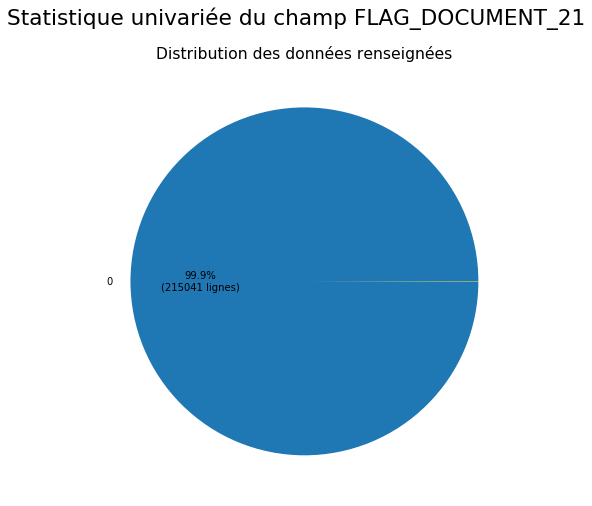

In [56]:
myDf(dfApplication).Stat('FLAG_DOCUMENT_21')